In [2]:
import os

In [3]:
!pwd

/home/jovyan/notebooks/analysis/predictive_distribution


In [4]:
import sys
sys.path.append('/home/jovyan/')

In [5]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import evaluate_genome, get_dataset
from neat.genome import Genome
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [8]:
PROJECT = 'neuro-evolution'

### Configuration

In [9]:
from neat.analysis.experiment_data import ExperimentDataNE, ExperimentDataNAS
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_pca import plot_dimensionality_reduction
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.plotting.plot_prediction_probabilities import plot_prediction_probabilities
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [10]:
config_versions = {'NE': {'project': 'neuro-evolution',
                         'algorithm_version': 'bayes-neat'},
                  'NAS': {'project': 'nas',
                         'algorithm_version': 'nas'}
                  }
datasets = ['iris', 'wine', 'breast_cancer', 'titanic', 'spambase', 'mnist_downsampled']
# datasets = ['titanic']
# datasets = [ 'mnist_downsampled']
# dataset = 'iris'

In [11]:
# df_versions = pd.DataFrame([['Bayesian-NEAT', 'NE', True, 'bayesian_neat_ft_21_iris'],
#                            ['NEAT', 'NE', False, 'neat_ft_21_iris'],
#                            ['Bayesian-MLP', 'NAS', True, 'bayesian_nas_final'],
# #                            ['NAS', False, 'standard_nas_final_with_reps']
#                            ['MLP', 'NAS', False, 'standard_nas_final']
#                            ], columns=['method', 'search', 'is_bayesian', 'correlation_id'])
versions_map = {}
for dataset in datasets:
    df_versions = pd.read_csv(f'./../experiment_2/versions/{dataset}.csv')
    print(f'DATASET: {dataset}')
    df_versions = df_versions.loc[df_versions['is_bayesian']==True]
    print(df_versions)
    versions_map[dataset] = df_versions
    


DATASET: iris
          method search  is_bayesian                  correlation_id
0  Bayesian-NEAT     NE         True  bayesian_neat_ft_final_v1_iris
2   Bayesian-MLP    NAS         True              bayesian_nas_final
DATASET: wine
          method search  is_bayesian                  correlation_id
0  Bayesian-NEAT     NE         True  bayesian_neat_ft_final_v1_wine
2   Bayesian-MLP    NAS         True    bayesian_nas_final_v1_lenovo
DATASET: breast_cancer
          method search  is_bayesian                           correlation_id
0  Bayesian-NEAT     NE         True  bayesian_neat_ft_final_v1_breast_cancer
2   Bayesian-MLP    NAS         True                       bayesian_nas_final
DATASET: titanic
          method search  is_bayesian                     correlation_id
0  Bayesian-NEAT     NE         True  bayesian_neat_ft_final_v1_titanic
2   Bayesian-MLP    NAS         True       bayesian_nas_final_new_layer
DATASET: spambase
          method search  is_bayesian              

In [12]:
data = pd.read_csv('./uncertainty.csv')
data.head()

order_std  accuracy        f1                          execution_id  \
0          0  0.972973  0.972868  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   
1          1  0.972222  0.972146  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   
2          2  0.971429  0.971300  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   
3          3  0.970588  0.970494  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   
4          4  0.969697  0.969537  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   

  version         method dataset  
0      NE  Bayesian-NEAT    iris  
1      NE  Bayesian-NEAT    iris  
2      NE  Bayesian-NEAT    iris  
3      NE  Bayesian-NEAT    iris  
4      NE  Bayesian-NEAT    iris

In [13]:
data = data.loc[~((data['dataset'] == 'spambase') &
               (data['order_std'] >= 1050))]

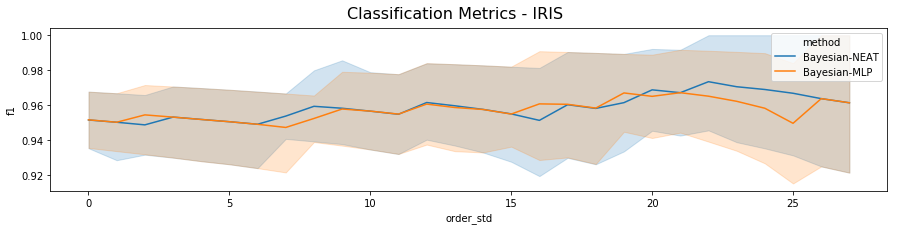

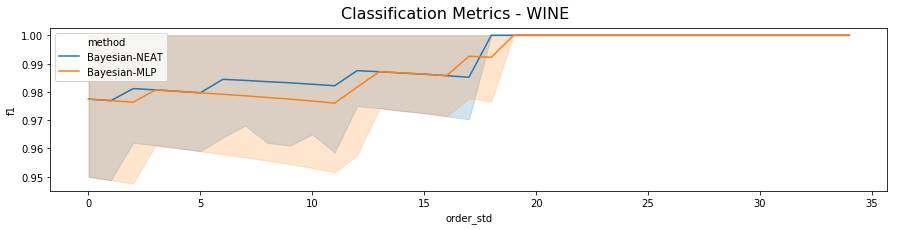

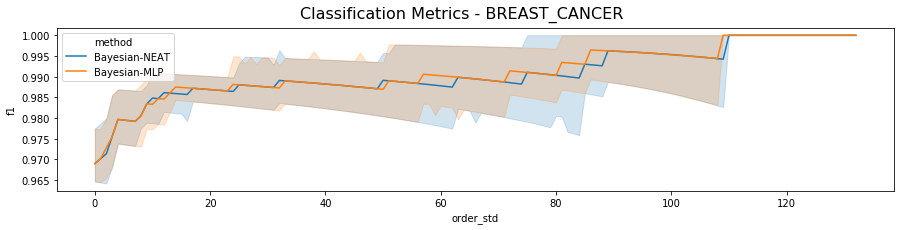

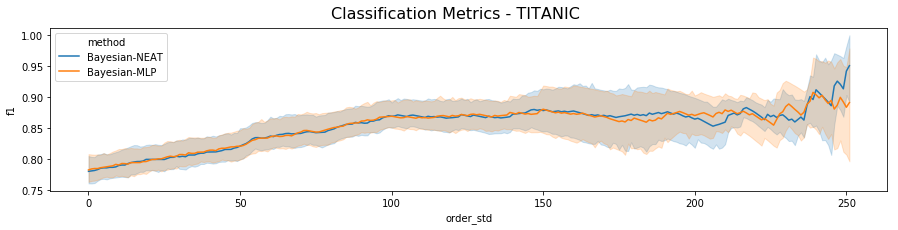

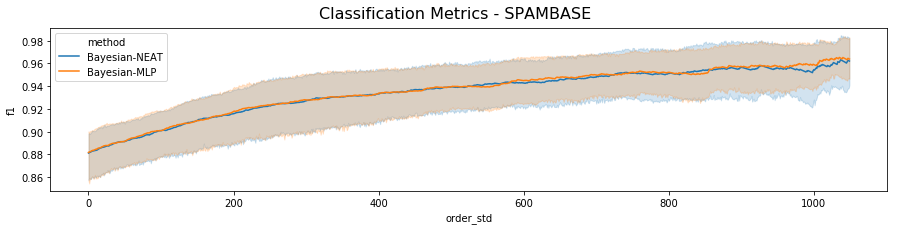

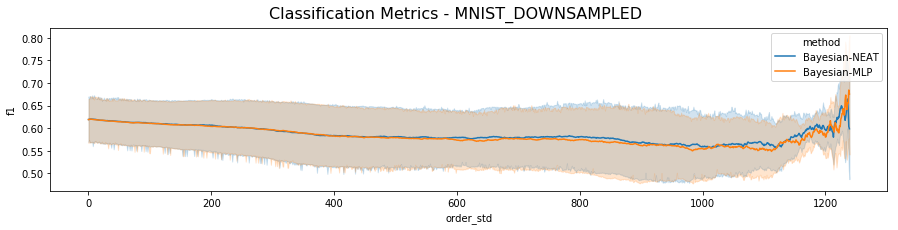

In [14]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]
    
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 3))
    fig.suptitle(f'Classification Metrics - {dataset.upper()}', fontsize=16)
    
    sns.lineplot(data=data_dataset, x='order_std', y='f1', ax=ax1, hue='method')
#     sns.lineplot(data=data_dataset, x='order_std', y='f1', ax=ax2)
    plt.savefig(f'./experiment_4_metrics_{dataset}.png')
    plt.show()

In [11]:
# from IPython.core.debugger import set_trace
# set_trace()
experiment_data = ExperimentDataNE(correlation_ids=correlation_ids, dataset_name=DATASET, n_samples=1000,
                                 project=PROJECT, algorithm_version=ALGORITHM_VERSION,
                                keep_top=1.0, filter_checkpoint_finish=True)\
                    .process_data()
data = experiment_data.get_experiment_data()
# data.head()

###########
CORRELATION ID: bayesian_neat_ft_final_v1_iris
5 executions
Train percentage: 0.75
Random state: 52
Sum Train: -41.176780700683594
Label Noise: 0.0
Sum of 10 first labels: 7
[2 1 0 1 1 0 1 0 0 1]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 52
Sum Train: -41.176780700683594
Label Noise: 0.0
Sum of 10 first labels: 7
[2 1 0 1 1 0 1 0 0 1]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 82
Sum Train: 0.3260765075683594
Label Noise: 0.0
Sum of 10 first labels: 13
[1 0 2 1 2 2 0 2 2 1]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 82
Sum Train: 0.3260765075683594
Label Noise: 0.0
Sum of 10 first labels: 13
[1 0 2 1 2 2 0 2 2 1]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 83
Sum Train: -16.439117431640625
Label Noise: 0.0
Sum of 10 first labels: 9
[2 0 1 1 1 0 1 0 2 1]
Training: 112. Testing: 38


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train percentage: 0.75
Random state: 83
Sum Train: -16.439117431640625
Label Noise: 0.0
Sum of 10 first labels: 9
[2 0 1 1 1 0 1 0 2 1]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 33
Sum Train: -32.15251159667969
Label Noise: 0.0
Sum of 10 first labels: 7
[1 0 1 1 1 0 0 1 0 2]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 33
Sum Train: -32.15251159667969
Label Noise: 0.0
Sum of 10 first labels: 7
[1 0 1 1 1 0 0 1 0 2]
Training: 112. Testing: 38
Train percentage: 0.75
Random state: 15
Sum Train: -0.34218311309814453
Label Noise: 0.0
Sum of 10 first labels: 9
[0 1 2 0 0 1 2 2 0 1]
Training: 112. Testing: 38


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train percentage: 0.75
Random state: 15
Sum Train: -0.34218311309814453
Label Noise: 0.0
Sum of 10 first labels: 9
[0 1 2 0 0 1 2 2 0 1]
Training: 112. Testing: 38


In [12]:
data.shape

(10, 22)

In [13]:
data.head(1)

correlation_id                          execution_id  \
0  bayesian_neat_ft_final_v1_iris  0f5a1f1c-048b-4e92-bc72-81b00fa4041d   

   train_percentage  noise  label_noise  is_bayesian    beta  loss_training  \
0              0.75    0.0          0.0         True  0.0001       0.886597   

   loss_testing        duration  ... n_nodes  n_connections  n_layers  \
0      0.940283  0:08:55.735616  ...       7             20         4   

   mean_genome_std   accuracy  precision    recall      f1       ece  \
0         0.574074  68.421053   0.766209  0.684211  0.6563  0.204795   

   absolute_best  
0          False  

[1 rows x 22 columns]

In [14]:
epd = ExecutionsPredictionDistributions(experiment_data=experiment_data).run(testing=True, filter_no_bayesian=True)

Sum Train: -41.176780700683594
Label Noise: 0.0
Sum of 10 first labels: 7
[2 1 0 1 1 0 1 0 0 1]
Training: 112. Testing: 38
Sum Train: 0.3260765075683594
Label Noise: 0.0
Sum of 10 first labels: 13
[1 0 2 1 2 2 0 2 2 1]
Training: 112. Testing: 38


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Sum Train: -16.439117431640625
Label Noise: 0.0
Sum of 10 first labels: 9
[2 0 1 1 1 0 1 0 2 1]
Training: 112. Testing: 38
Sum Train: -32.15251159667969
Label Noise: 0.0
Sum of 10 first labels: 7
[1 0 1 1 1 0 0 1 0 2]
Training: 112. Testing: 38
Sum Train: -0.34218311309814453
Label Noise: 0.0
Sum of 10 first labels: 9
[0 1 2 0 0 1 2 2 0 1]
Training: 112. Testing: 38


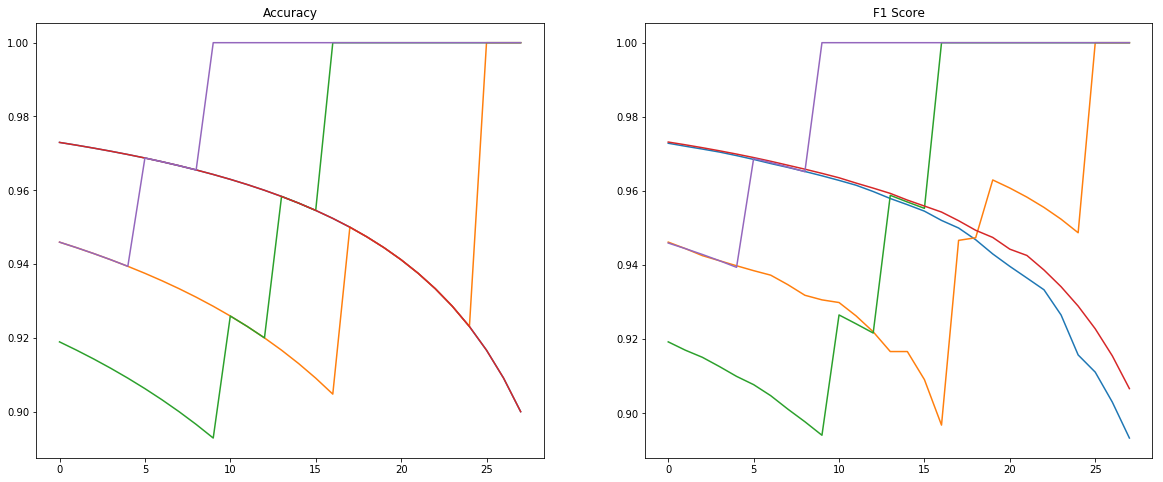

In [15]:
plot_metrics_by_quantile_several_executions(metrics_by_dispersion_quantile=epd.get_metrics_by_dispersion_quantile())

In [16]:
data = epd.get_metrics_by_dispersion_quantile()
data.head(1)

order_std  accuracy        f1                          execution_id
0          0  0.972973  0.972868  0f5a1f1c-048b-4e92-bc72-81b00fa4041d

In [17]:
import seaborn as sns

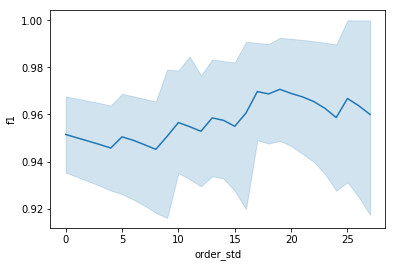

In [18]:
sns.lineplot(data=data, x='order_std', y='f1')

In [14]:
prediction_dist_estimators = epd.get_prediction_distribution_estimators()

In [15]:
best_execution = data.loc[data['is_bayesian']==True].sort_values(['f1'], ascending=True).head(1).squeeze()['execution_id']
estimator = prediction_dist_estimators[best_execution]

True -> 1
Predicted -> 1
STDS: 0.029110394418239594


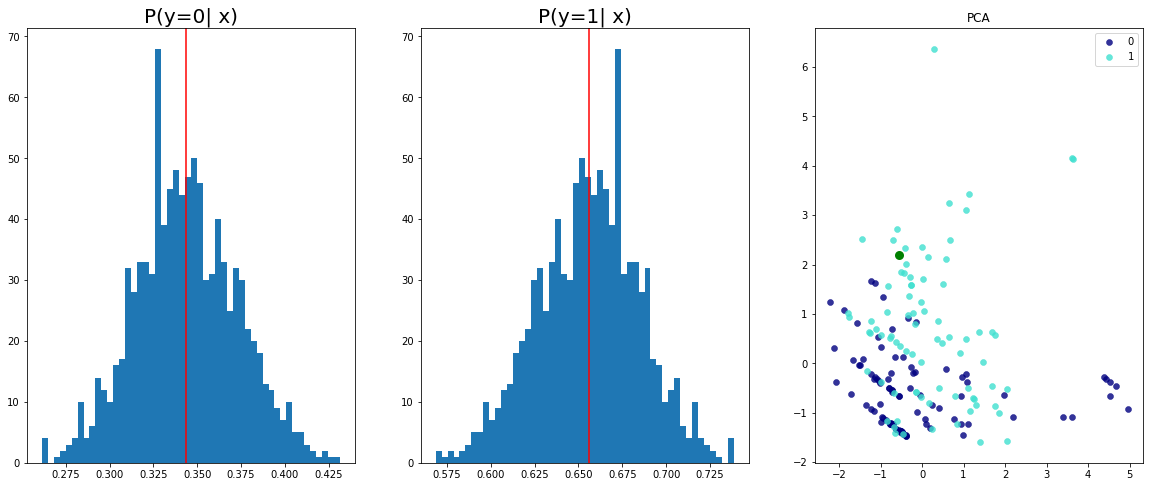

In [16]:
plot_prediction_probabilities(estimator=estimator, index_to_plot=1)

True -> 1
Predicted -> 1
STDS: 0.029635723680257797


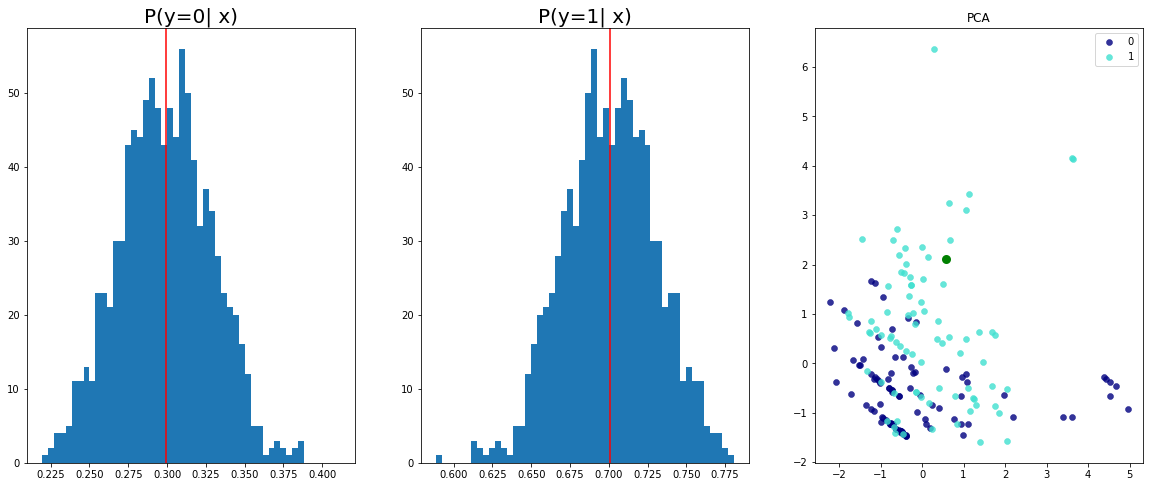

True -> 1
Predicted -> 1
STDS: 0.029110394418239594


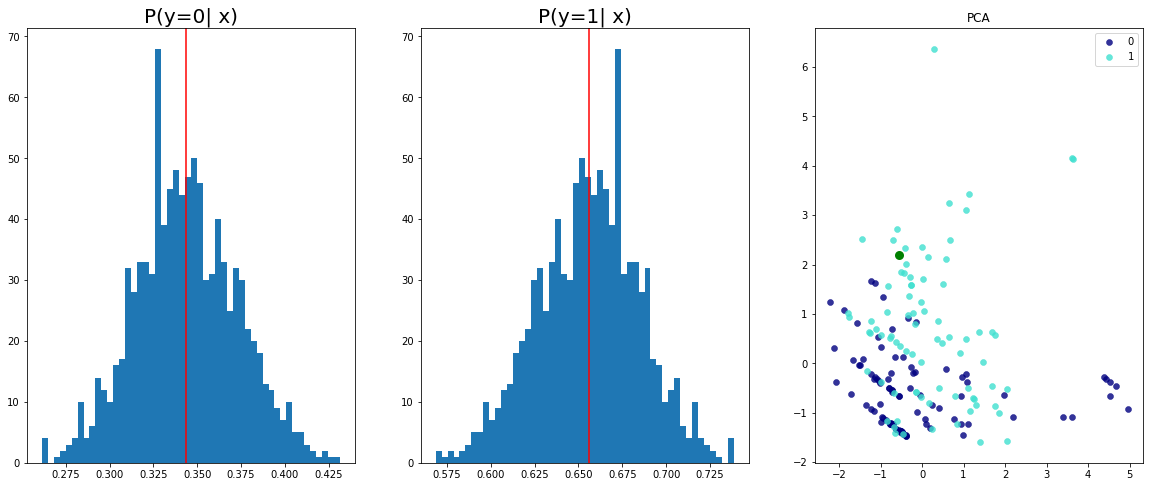

True -> 0
Predicted -> 1
STDS: 0.03339283540844917


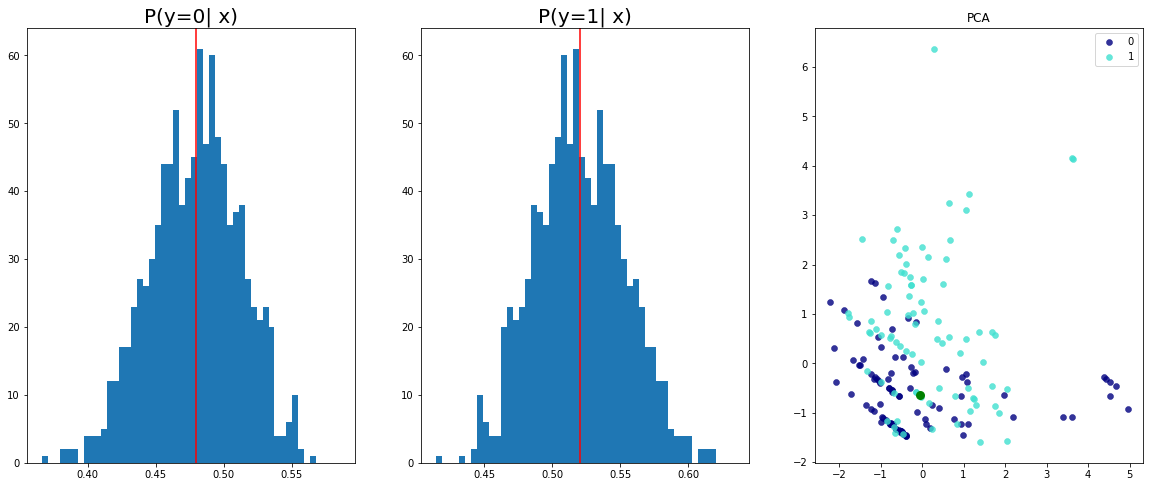

True -> 1
Predicted -> 1
STDS: 0.03485121205449104


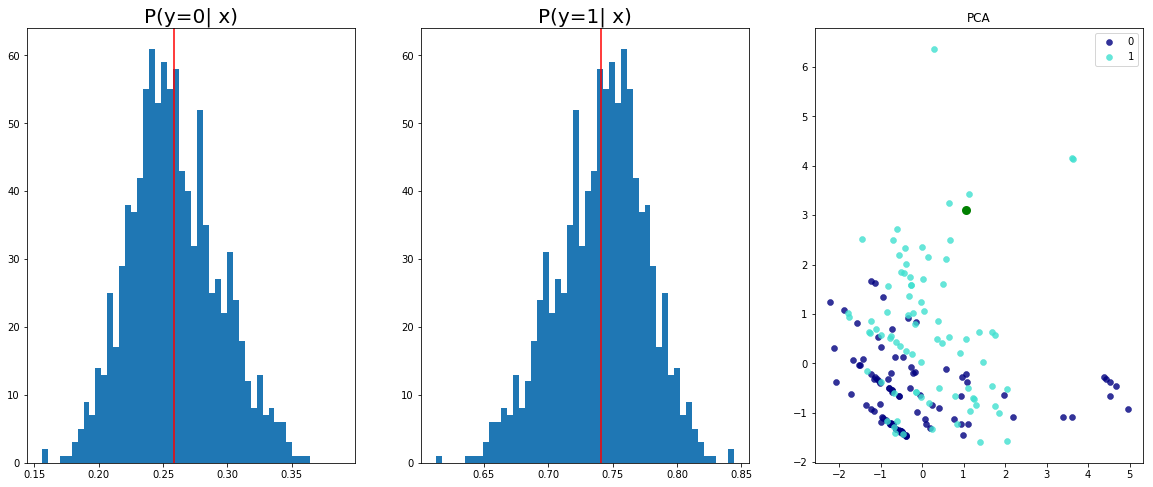

True -> 0
Predicted -> 0
STDS: 0.021292464807629585


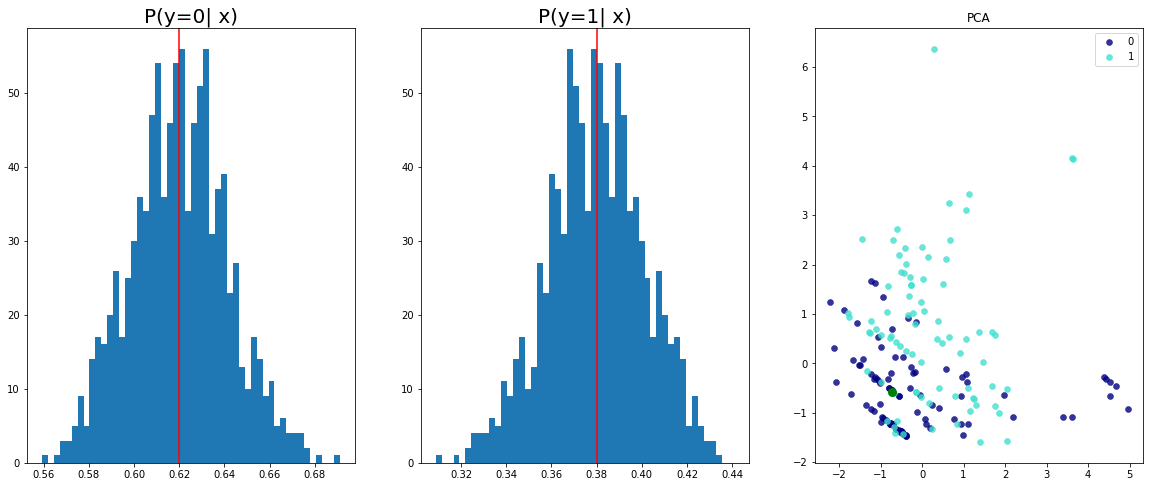

True -> 0
Predicted -> 0
STDS: 0.018386241048574448


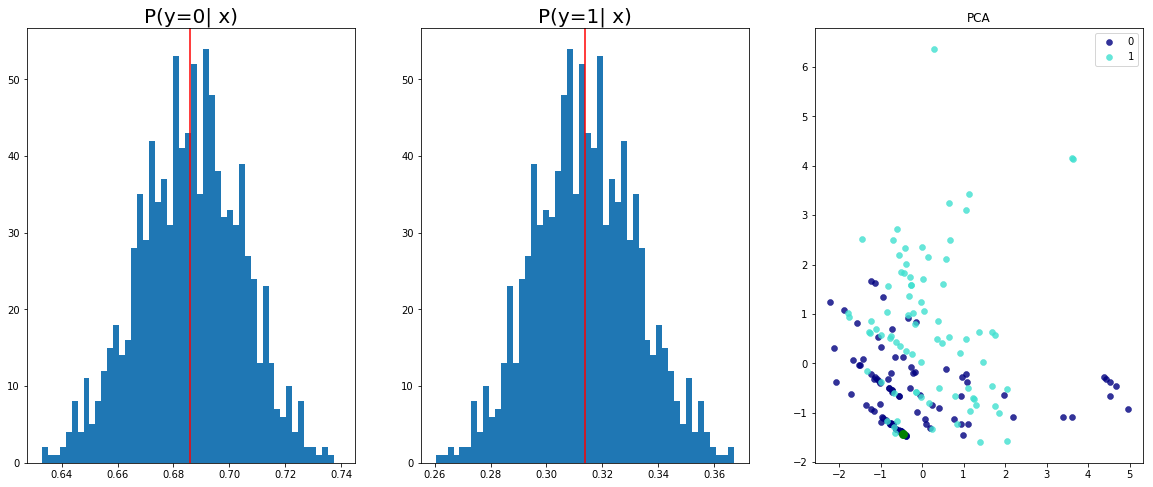

True -> 0
Predicted -> 1
STDS: 0.03234263136982918


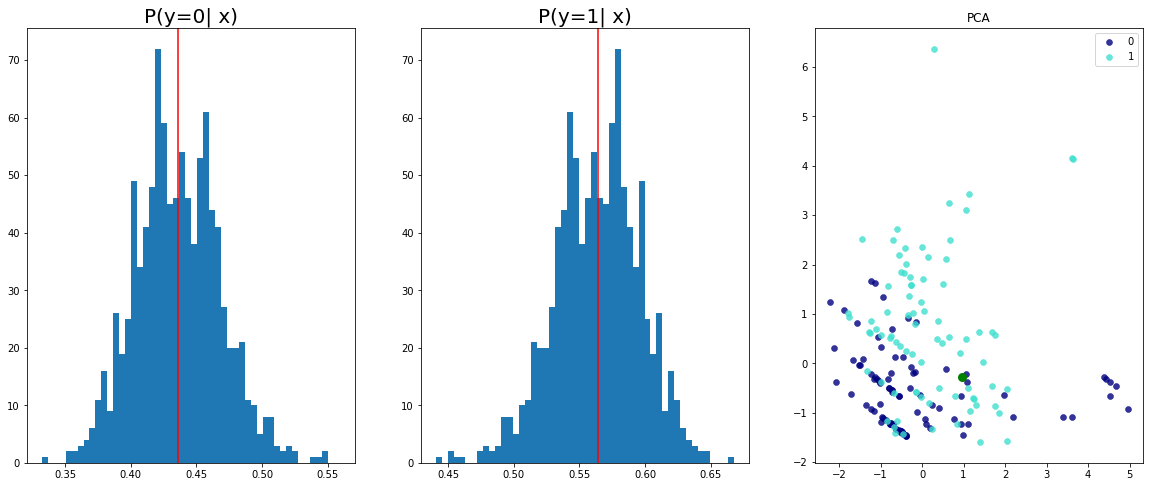

True -> 0
Predicted -> 0
STDS: 0.03868703171610832


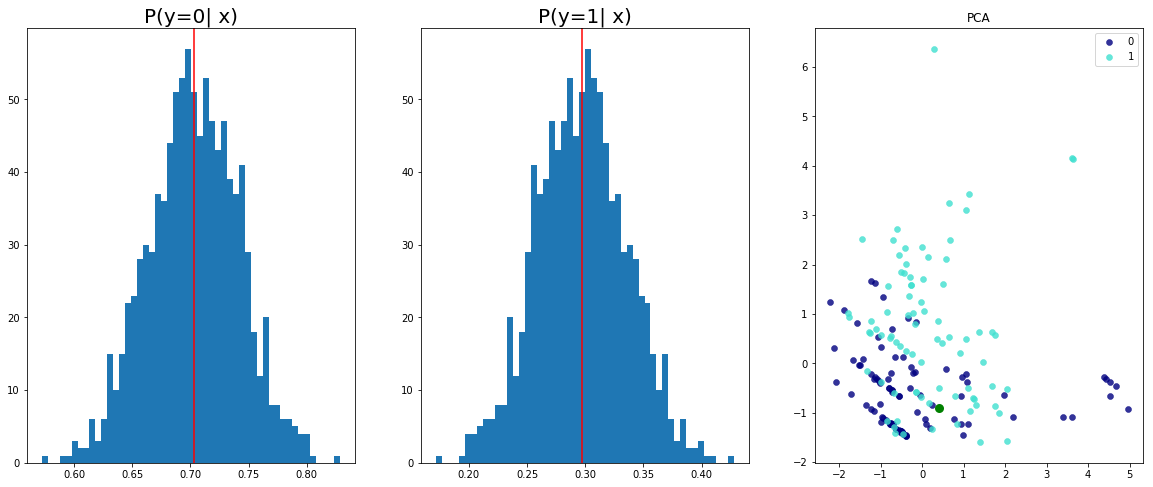

True -> 1
Predicted -> 1
STDS: 0.03319621458649635


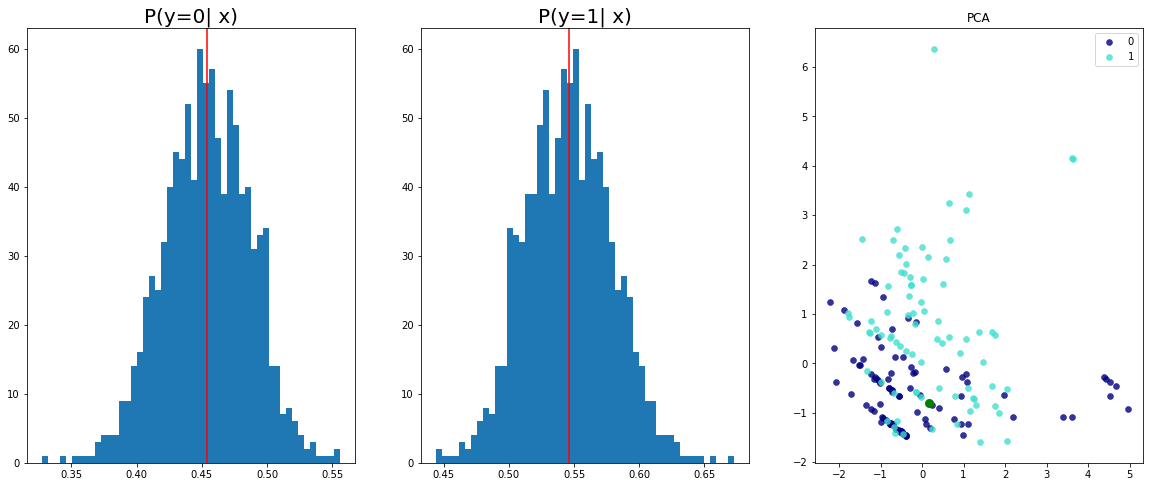

True -> 0
Predicted -> 0
STDS: 0.017429793253540993


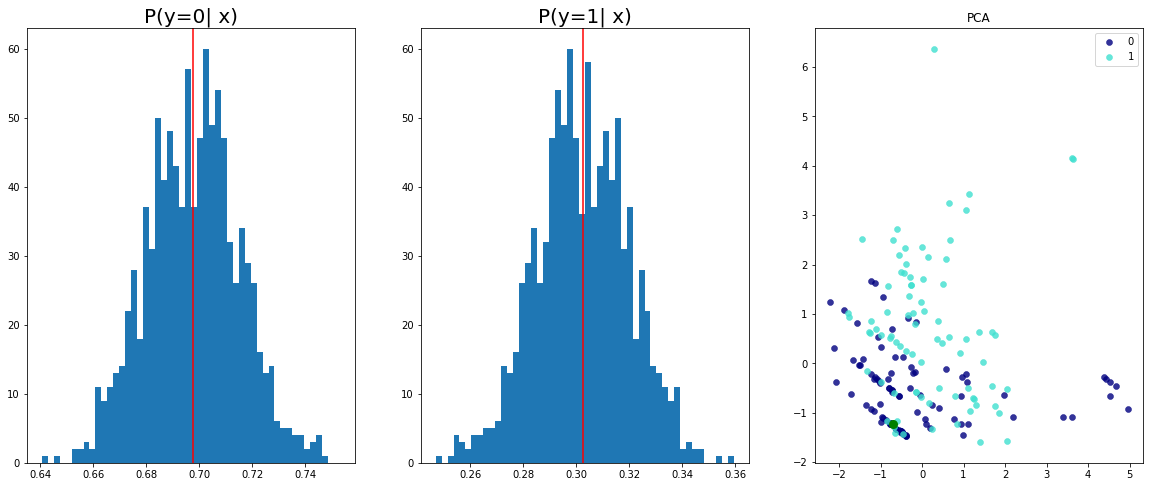

True -> 1
Predicted -> 0
STDS: 0.03552240505814552


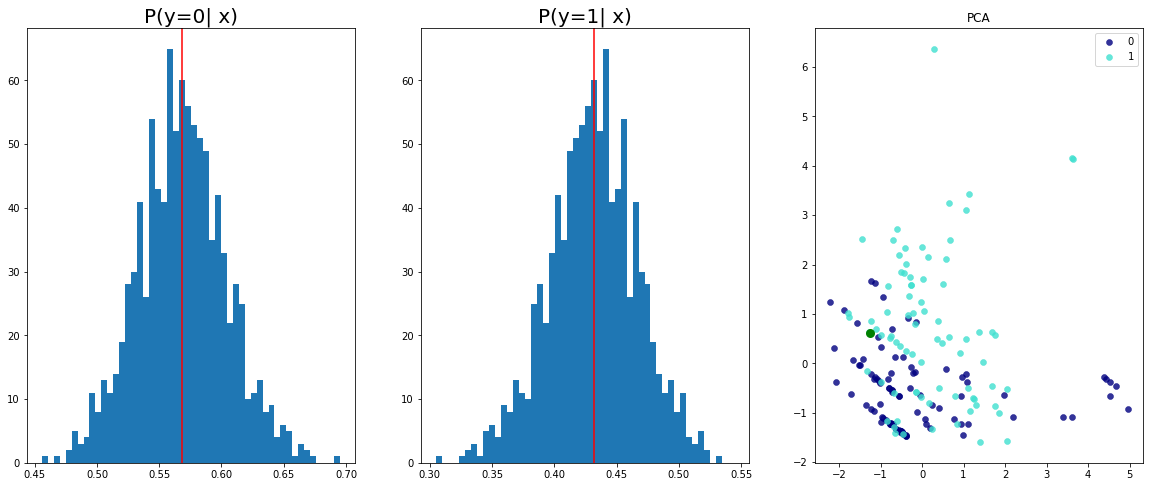

True -> 1
Predicted -> 0
STDS: 0.03557736054062843


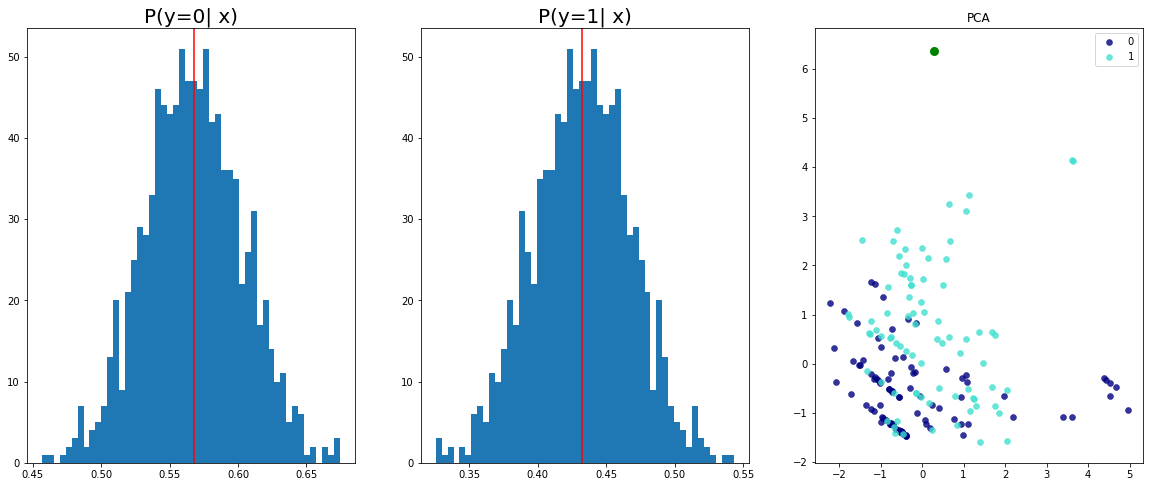

True -> 1
Predicted -> 1
STDS: 0.03387879207730293


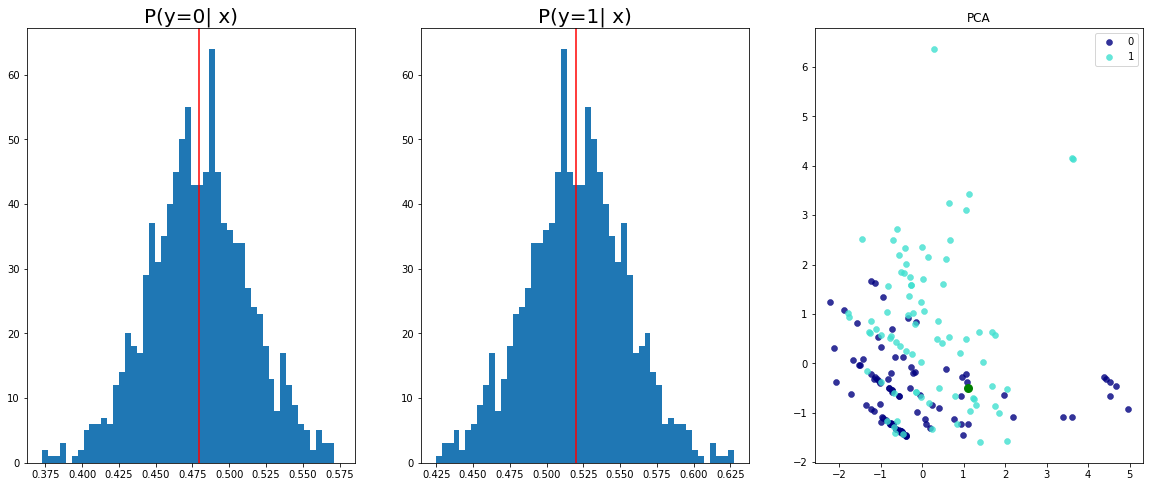

True -> 1
Predicted -> 0
STDS: 0.018263613805174828


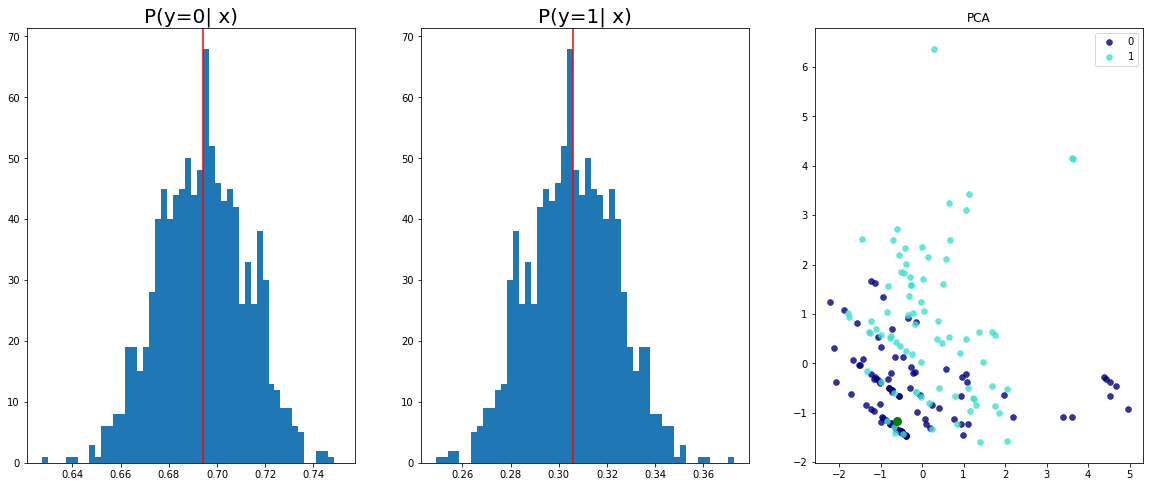

True -> 0
Predicted -> 0
STDS: 0.08292260020971298


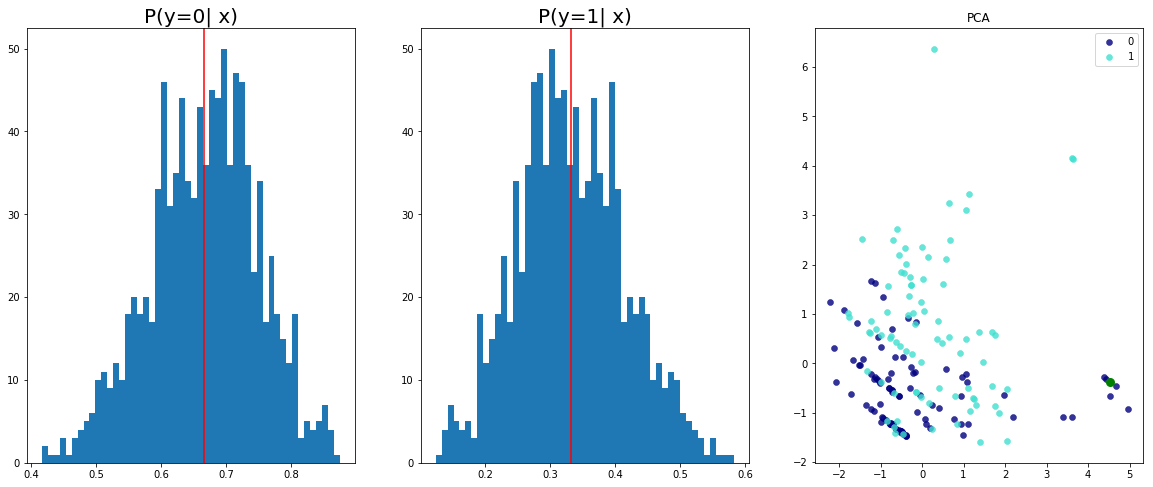

True -> 1
Predicted -> 0
STDS: 0.017204582691192627


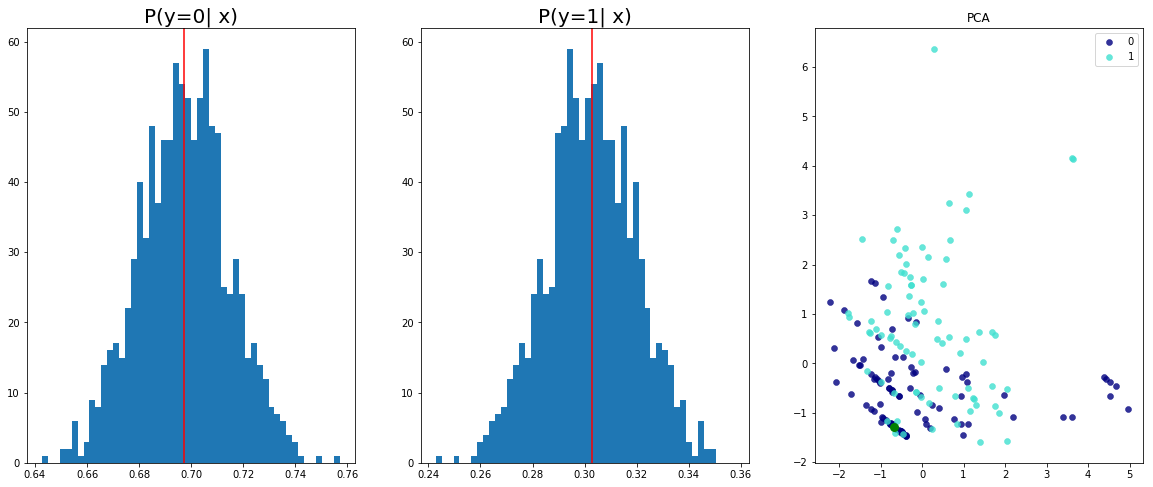

True -> 0
Predicted -> 0
STDS: 0.029971474781632423


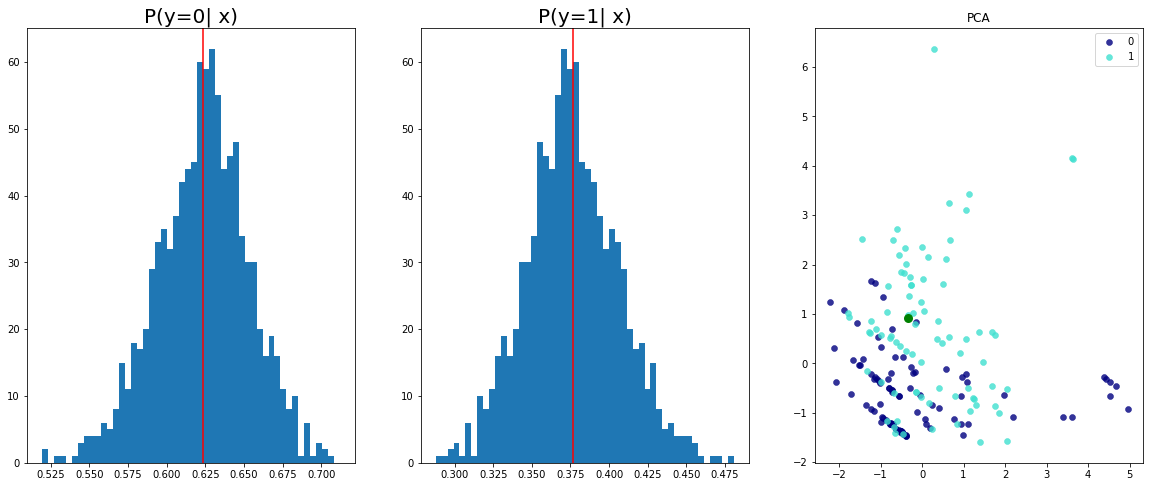

True -> 1
Predicted -> 1
STDS: 0.030022645369172096


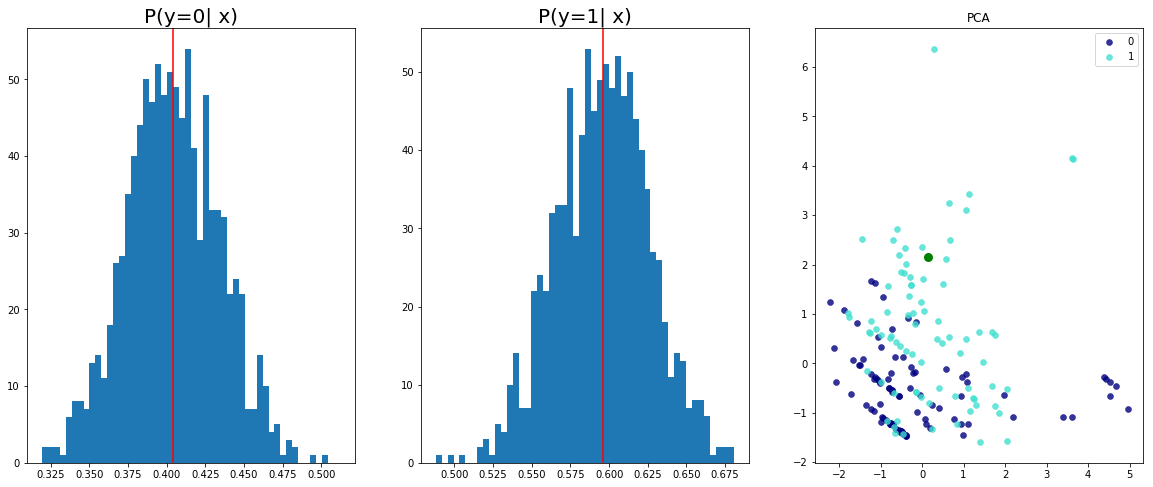

True -> 1
Predicted -> 1
STDS: 0.03025025874376297


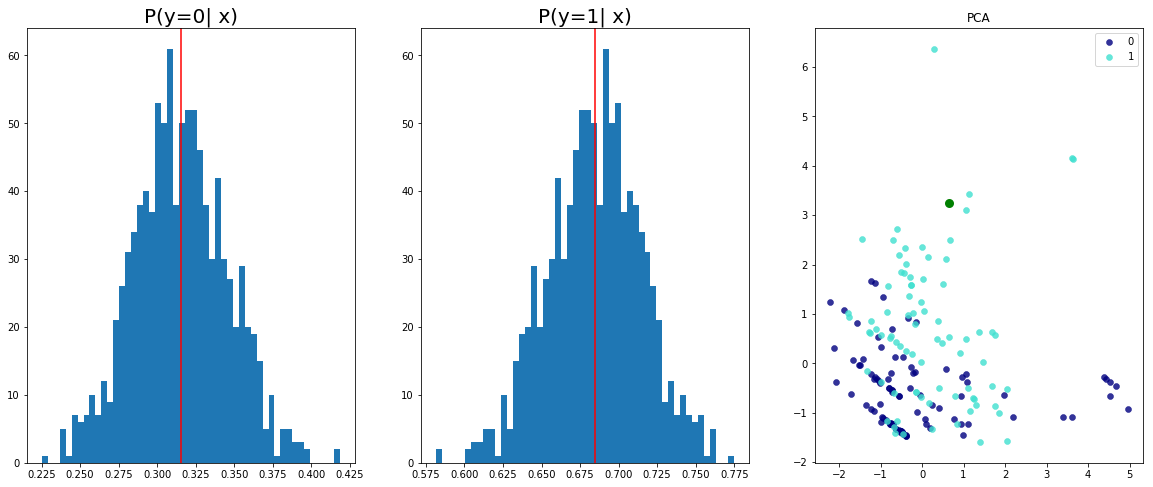

True -> 1
Predicted -> 1
STDS: 0.02656741626560688


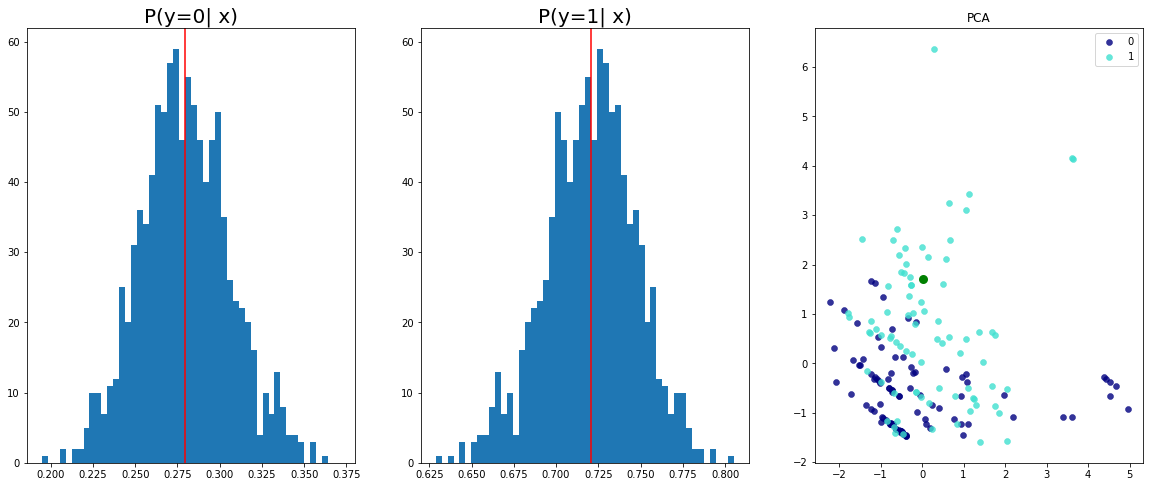

True -> 0
Predicted -> 0
STDS: 0.03335113078355789


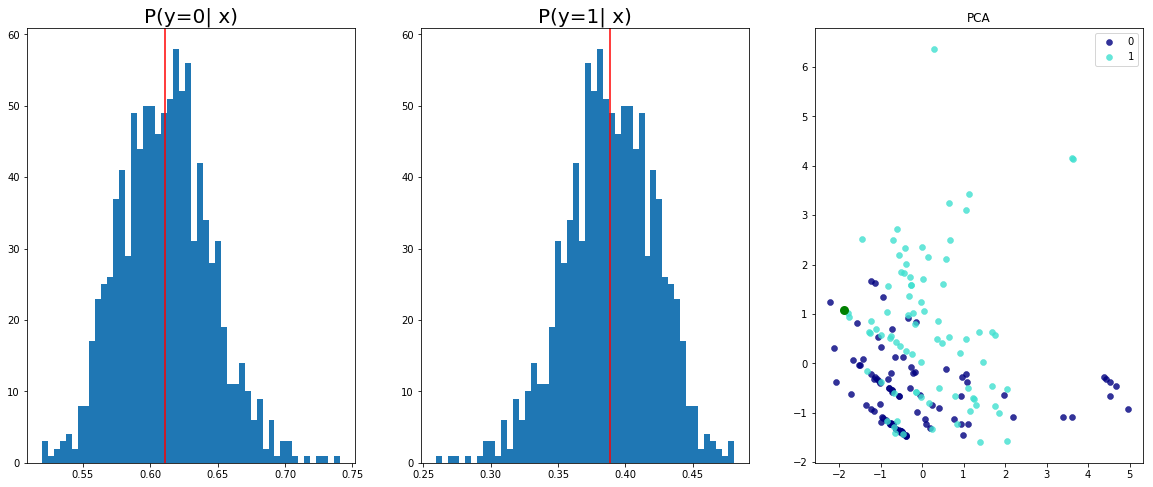

True -> 0
Predicted -> 1
STDS: 0.0340535007417202


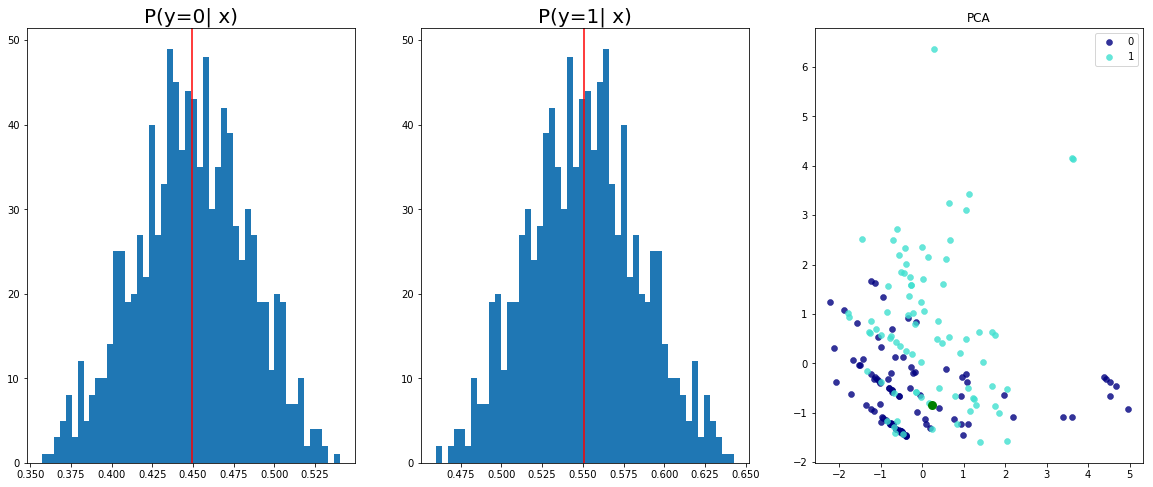

True -> 1
Predicted -> 1
STDS: 0.041191890835762024


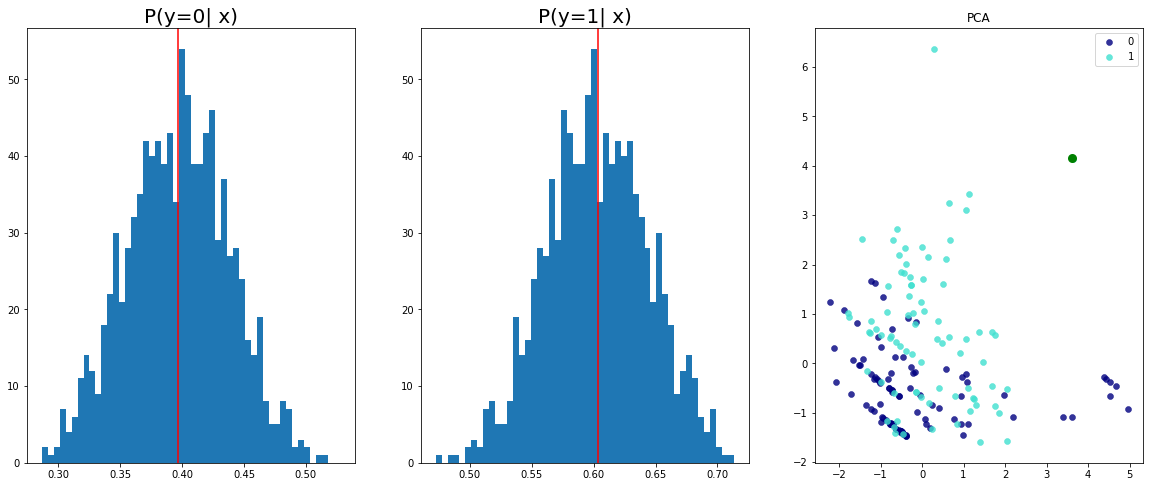

True -> 0
Predicted -> 0
STDS: 0.01713866926729679


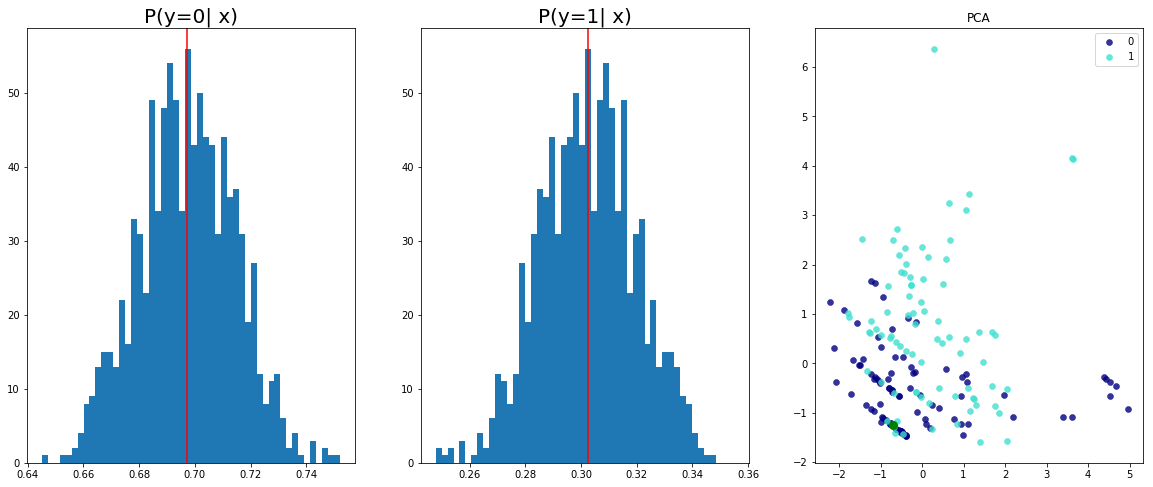

True -> 0
Predicted -> 0
STDS: 0.08602483570575714


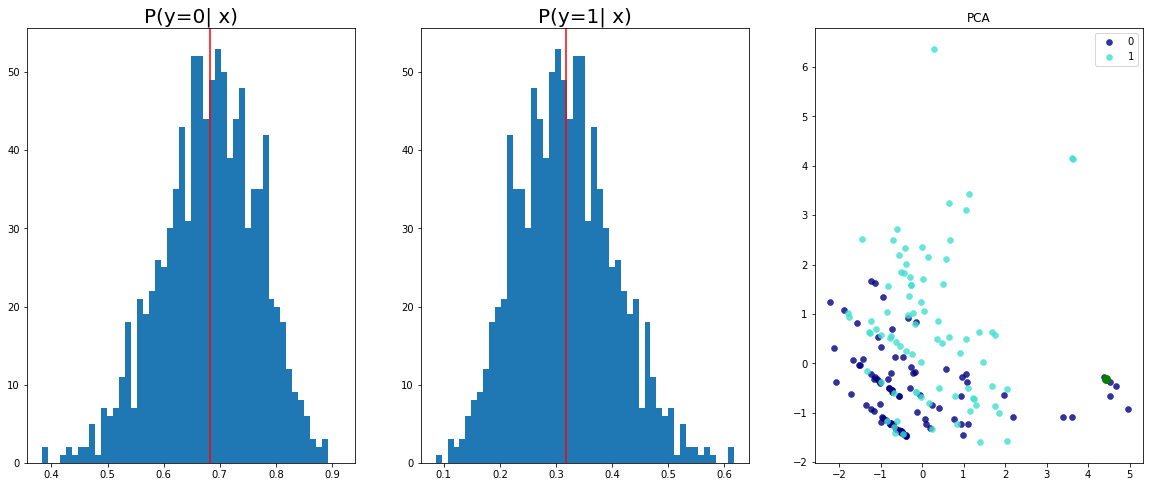

True -> 0
Predicted -> 0
STDS: 0.058466531336307526


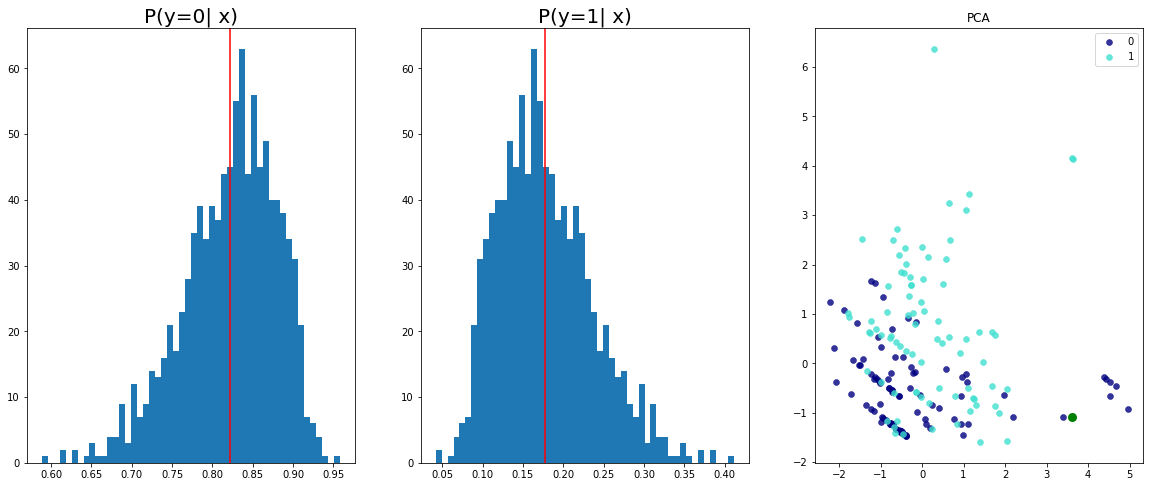

True -> 1
Predicted -> 0
STDS: 0.020502712577581406


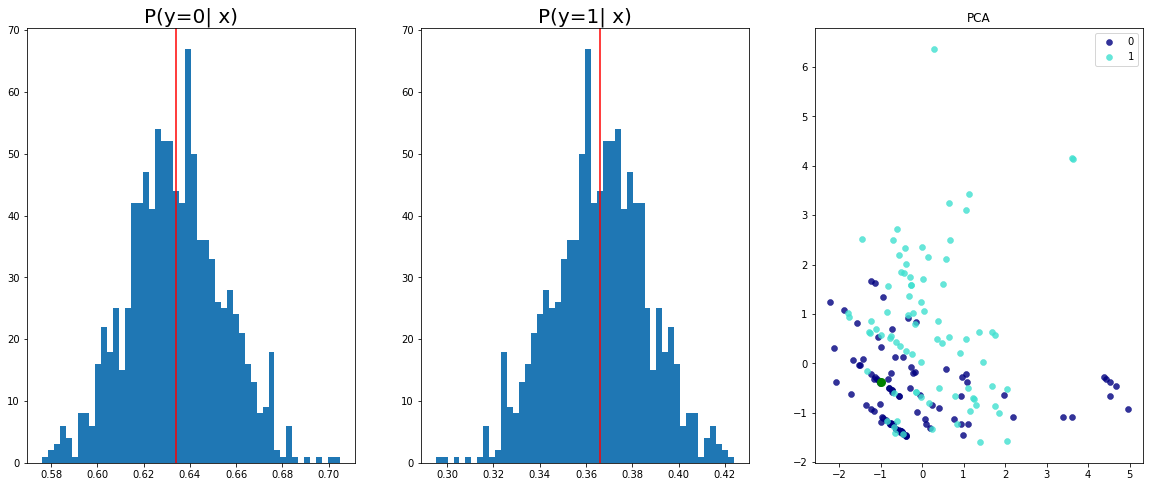

True -> 1
Predicted -> 1
STDS: 0.01908140629529953


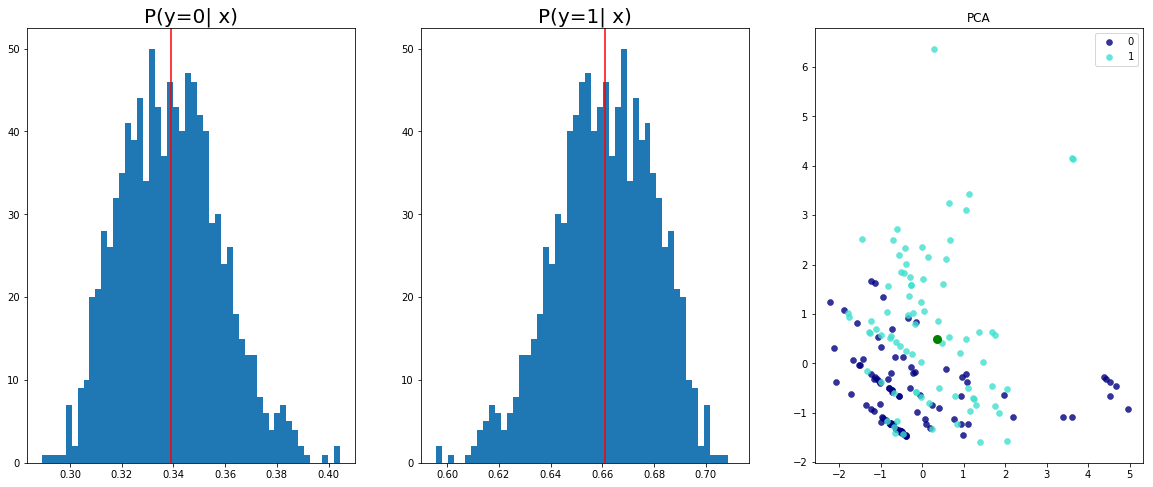

True -> 0
Predicted -> 0
STDS: 0.020724376663565636


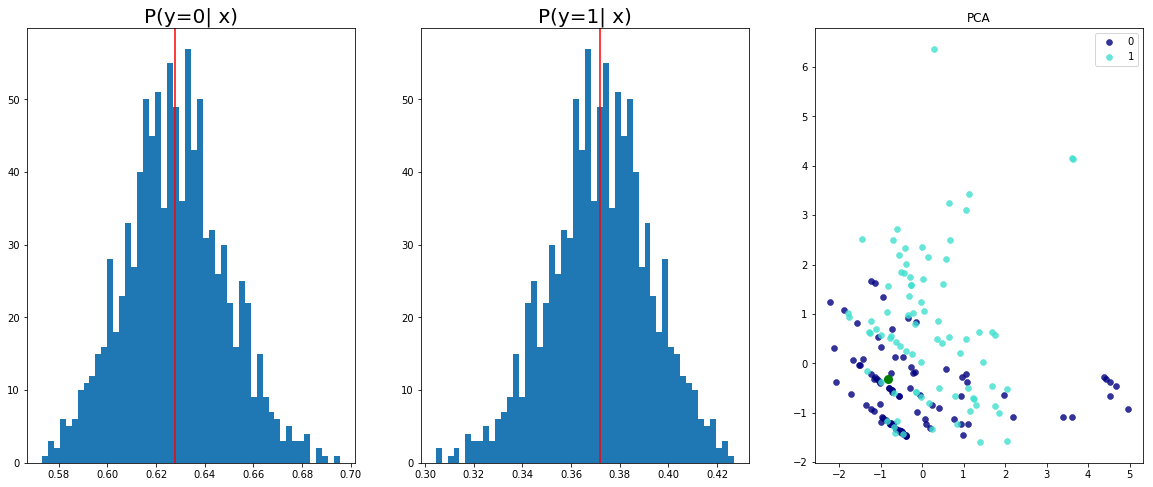

True -> 1
Predicted -> 1
STDS: 0.03367852047085762


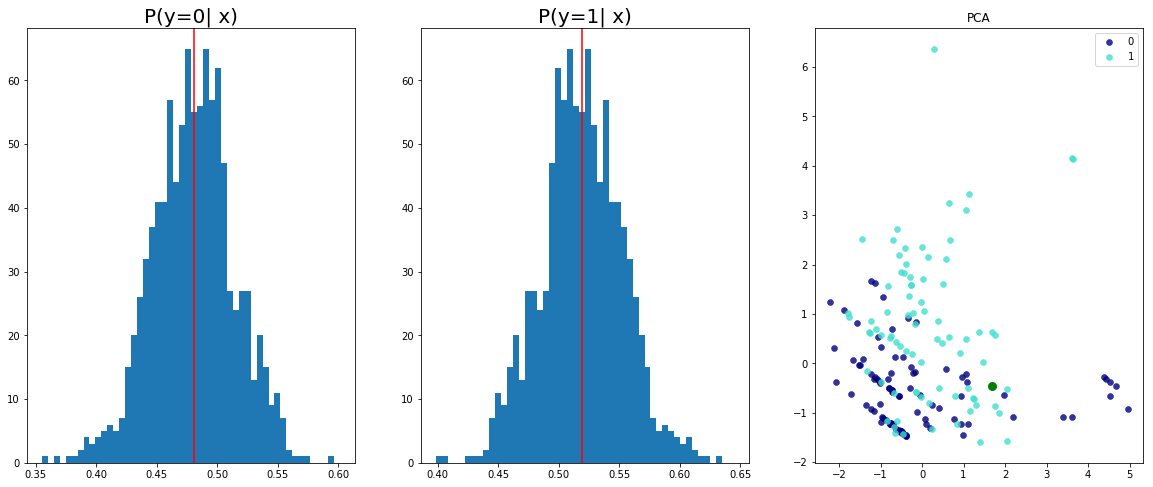

True -> 0
Predicted -> 0
STDS: 0.015862442553043365


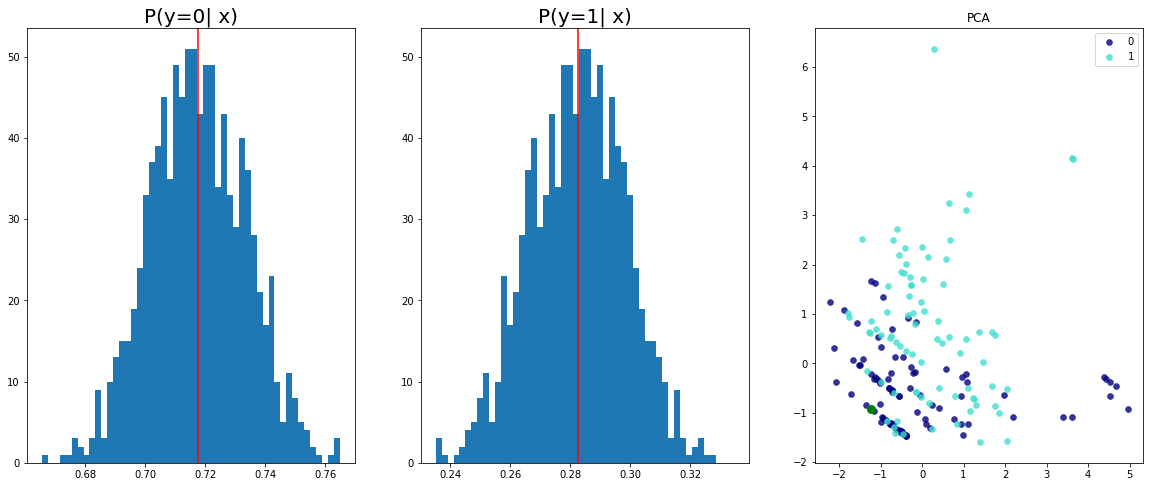

True -> 1
Predicted -> 0
STDS: 0.029438544064760208


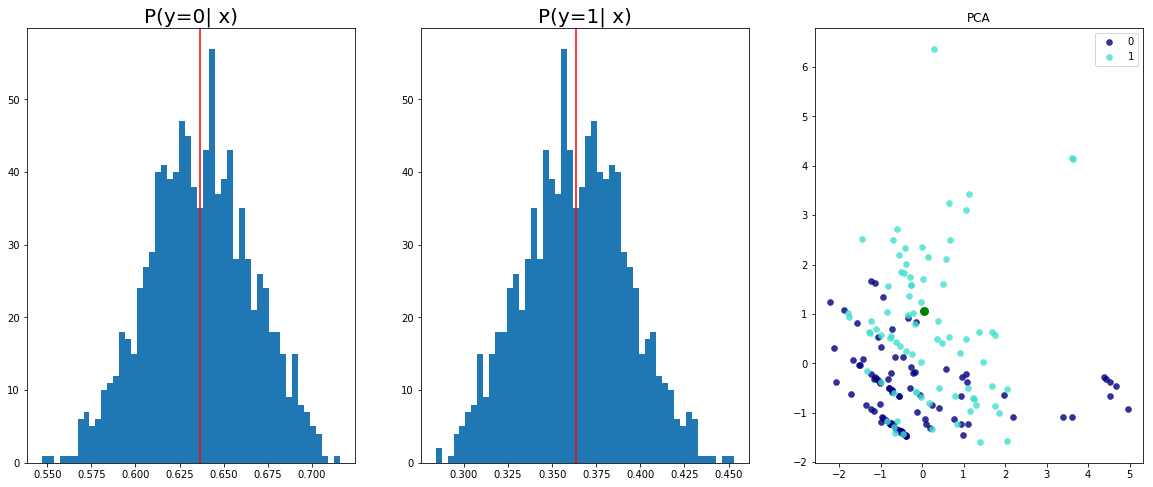

True -> 1
Predicted -> 0
STDS: 0.03866696357727051


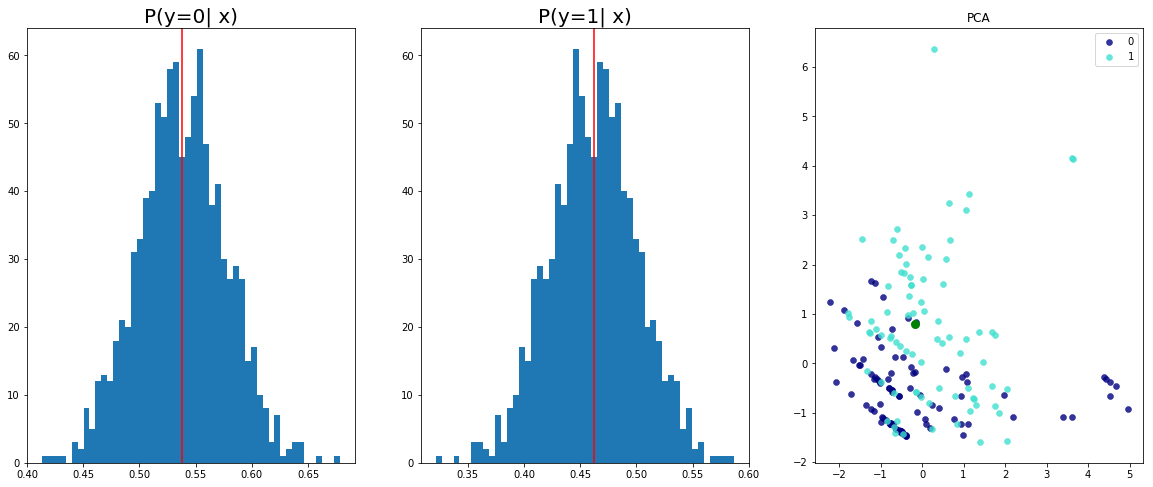

True -> 1
Predicted -> 0
STDS: 0.0479653999209404


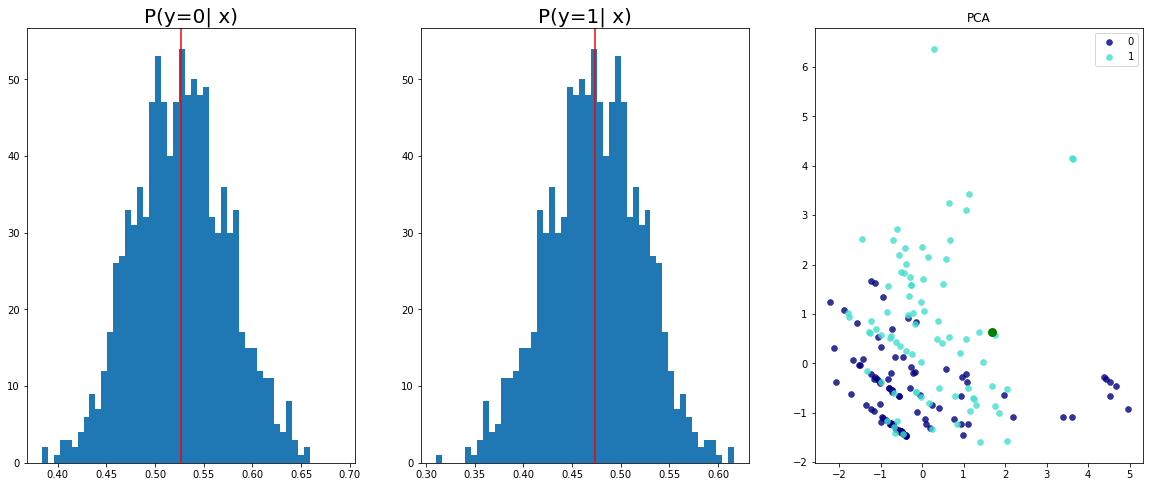

True -> 1
Predicted -> 1
STDS: 0.027073128148913383


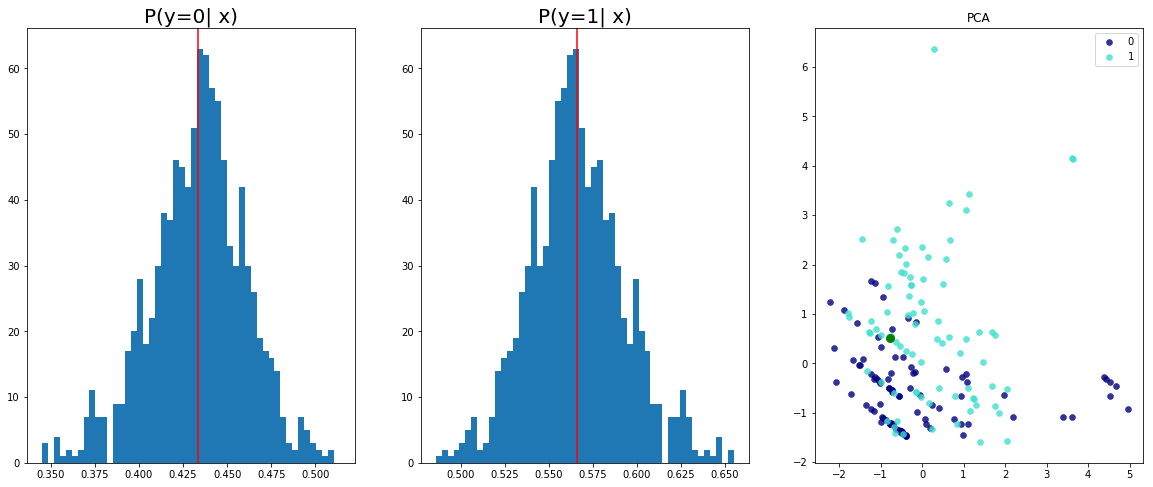

True -> 0
Predicted -> 0
STDS: 0.02881683222949505


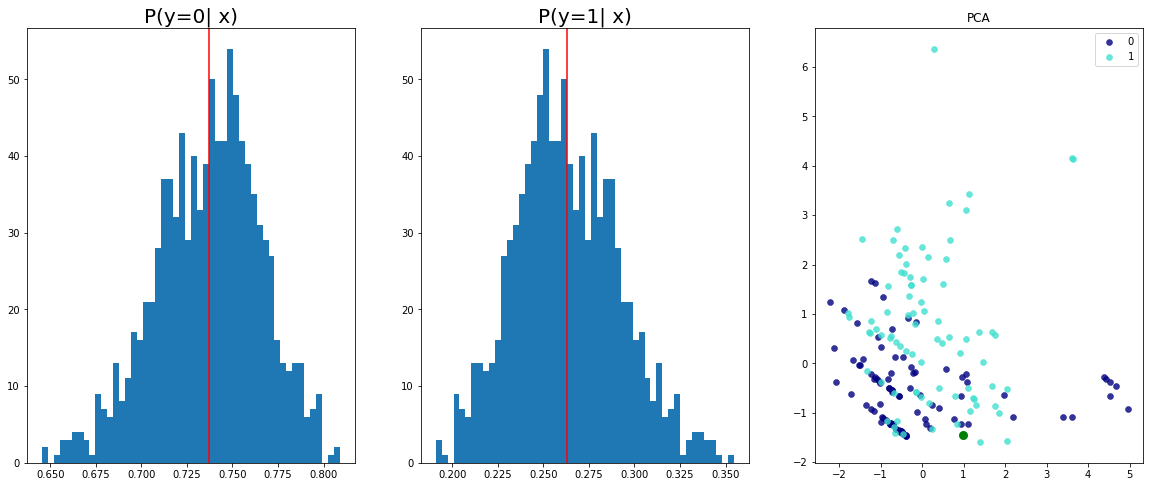

True -> 0
Predicted -> 0
STDS: 0.016616588458418846


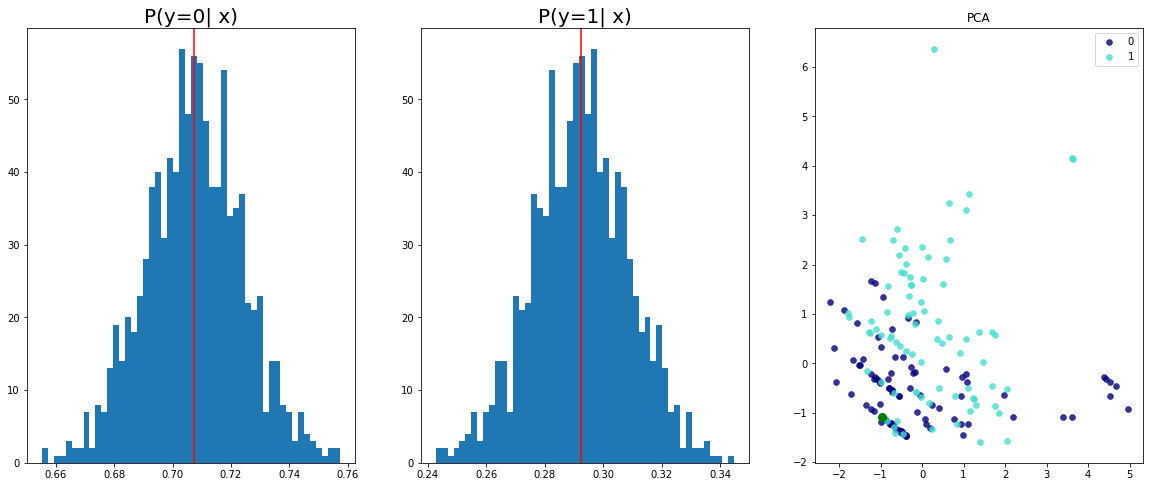

True -> 1
Predicted -> 0
STDS: 0.031197519972920418


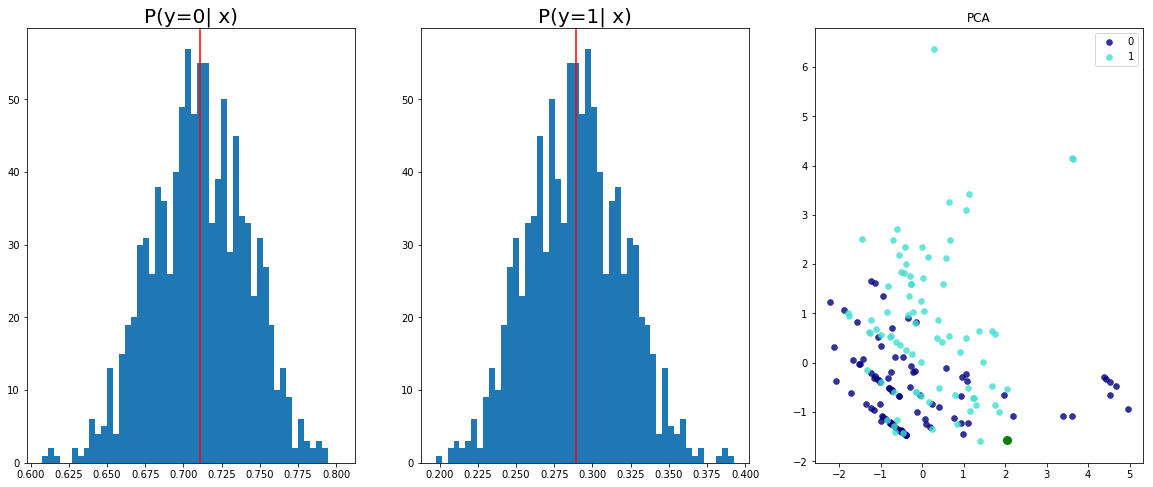

True -> 0
Predicted -> 0
STDS: 0.01855730079114437


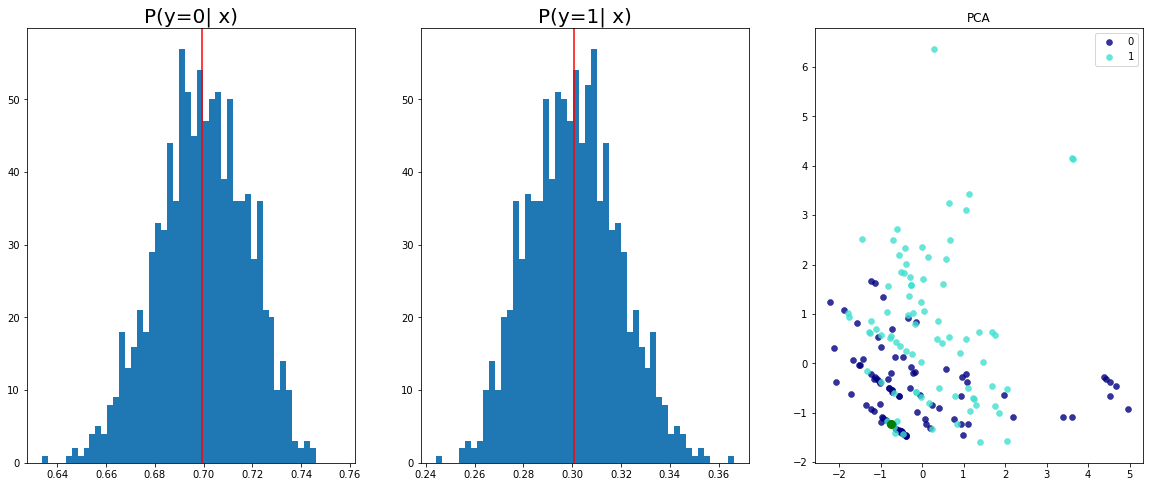

True -> 0
Predicted -> 0
STDS: 0.01792762242257595


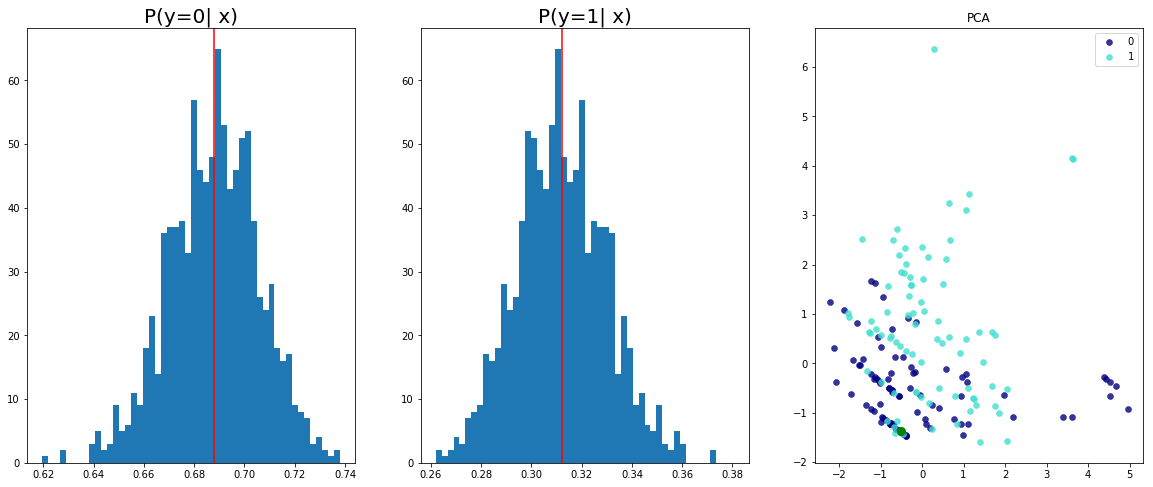

True -> 1
Predicted -> 1
STDS: 0.029992777854204178


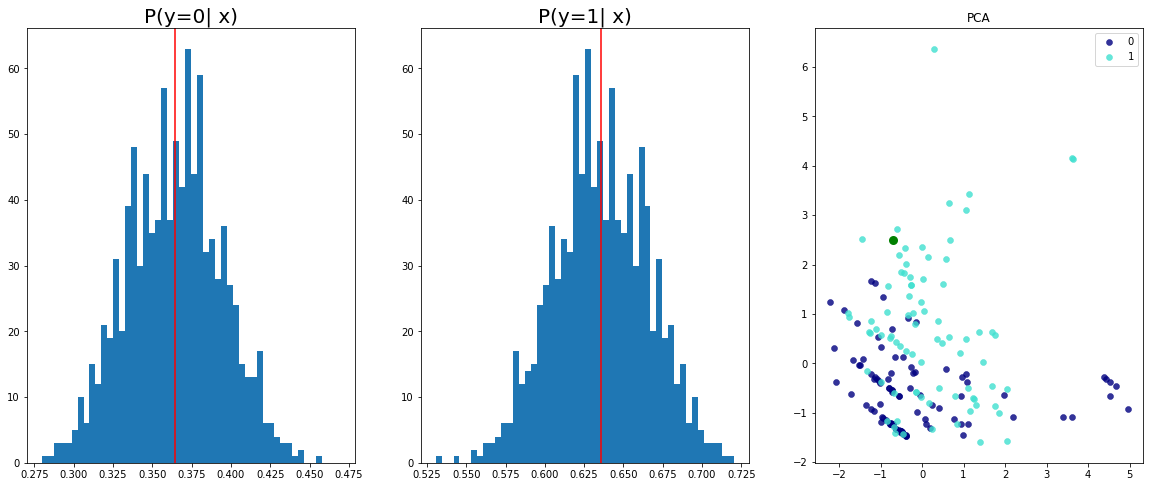

True -> 0
Predicted -> 0
STDS: 0.05265894904732704


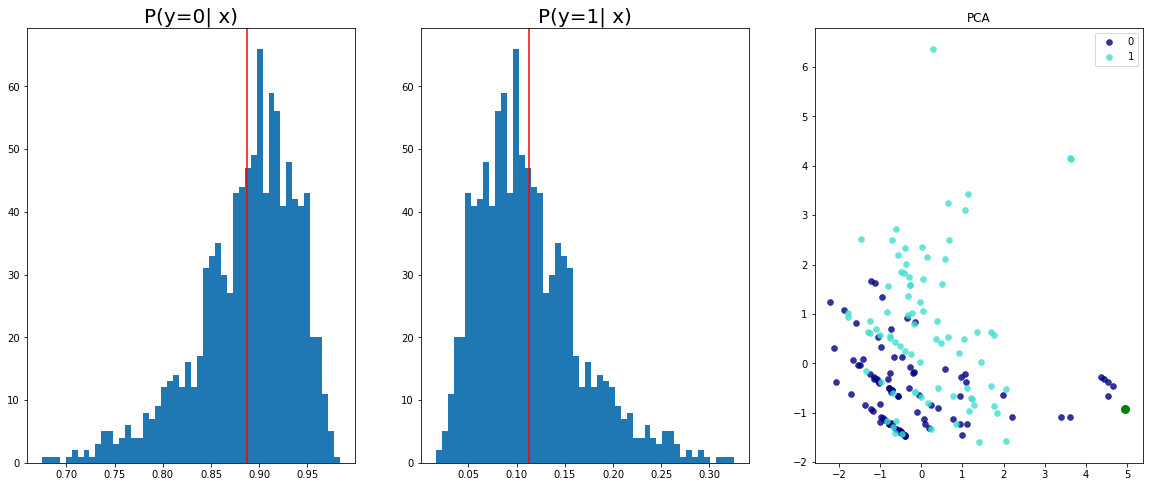

True -> 1
Predicted -> 1
STDS: 0.027213074266910553


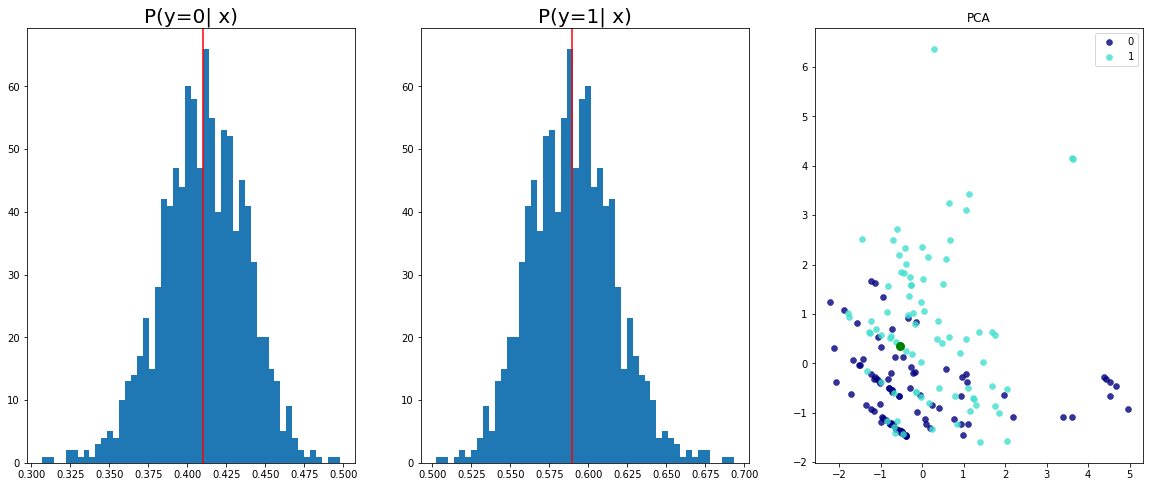

True -> 0
Predicted -> 0
STDS: 0.019235340878367424


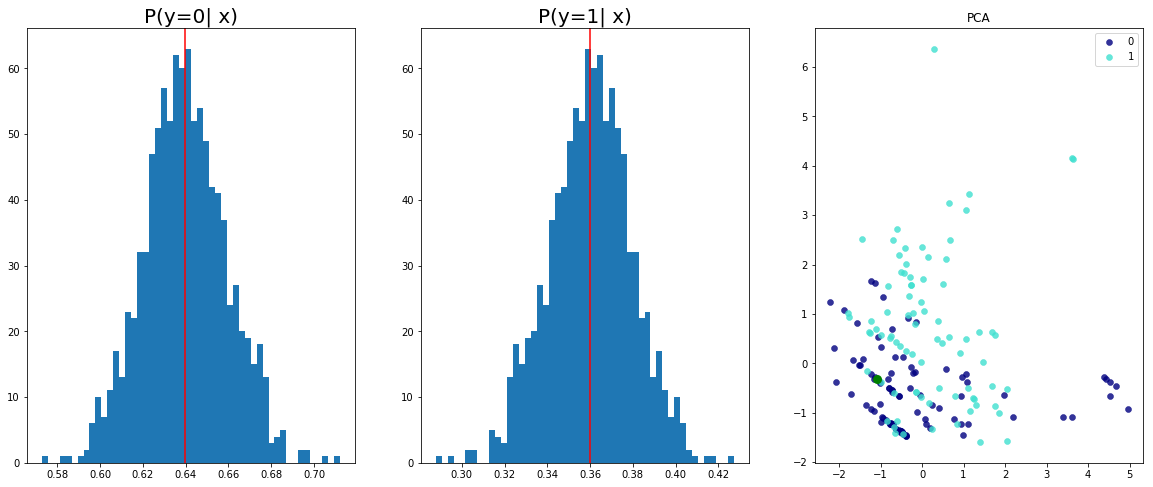

True -> 0
Predicted -> 0
STDS: 0.031186794862151146


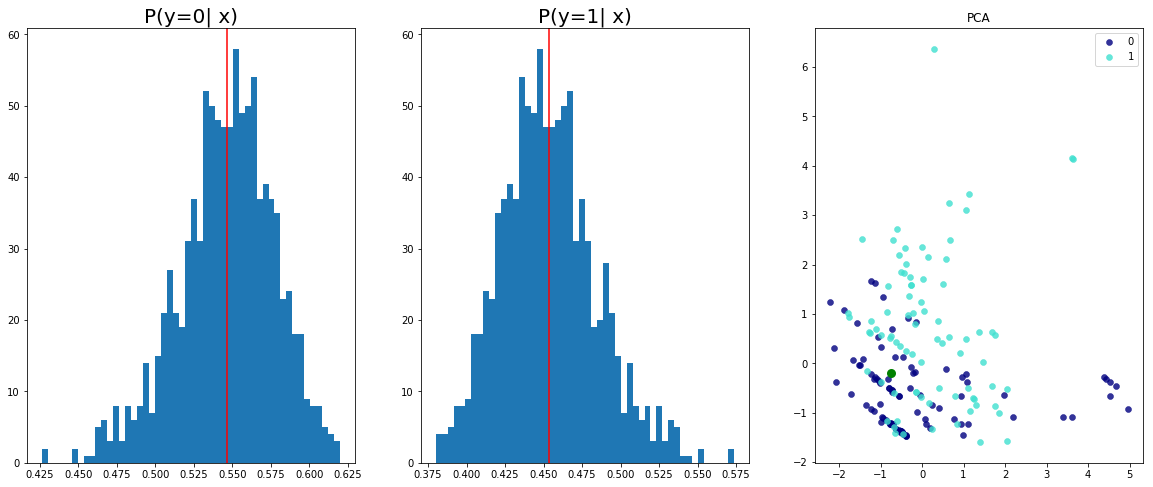

True -> 0
Predicted -> 0
STDS: 0.02098512090742588


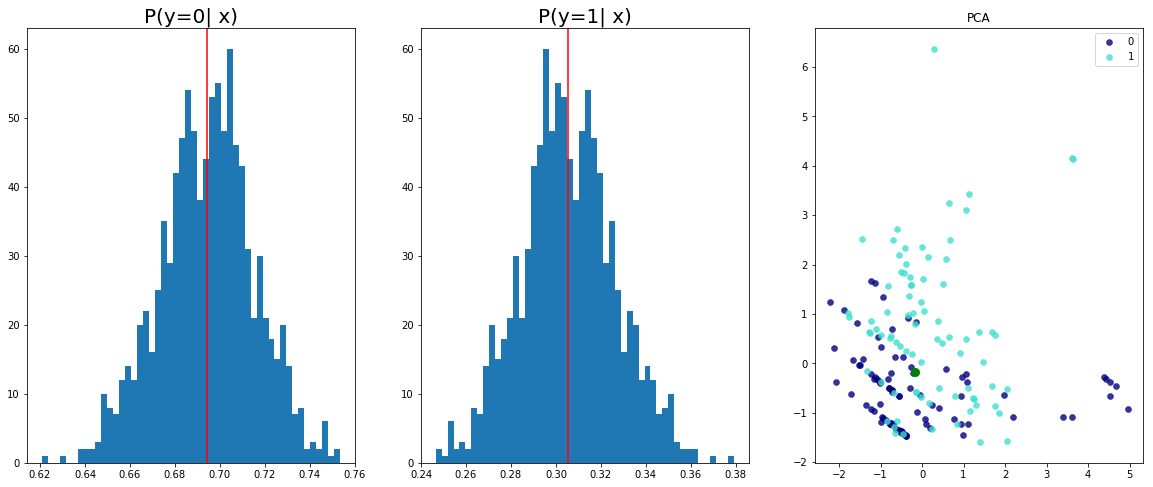

True -> 0
Predicted -> 0
STDS: 0.020534802228212357


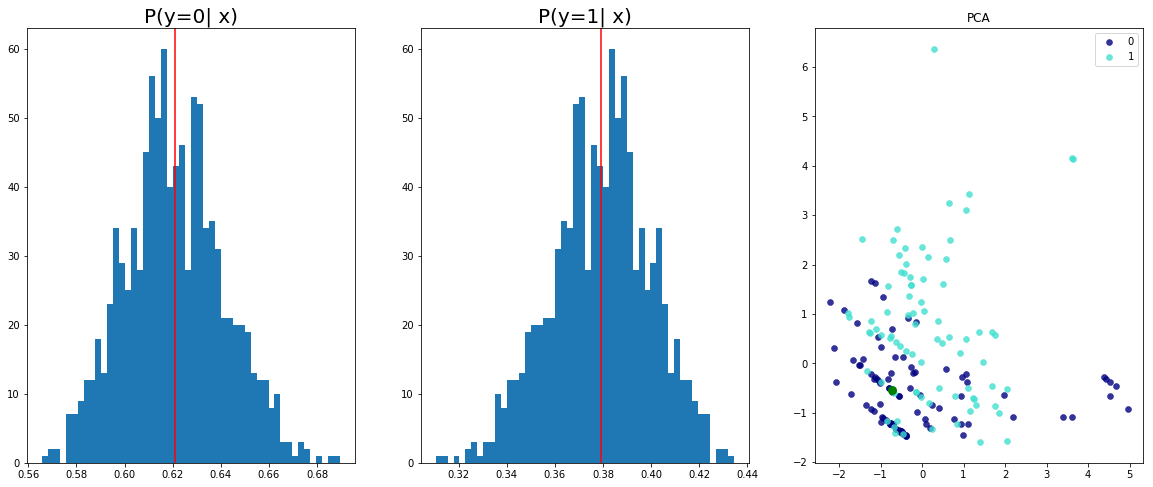

True -> 0
Predicted -> 0
STDS: 0.032435640692710876


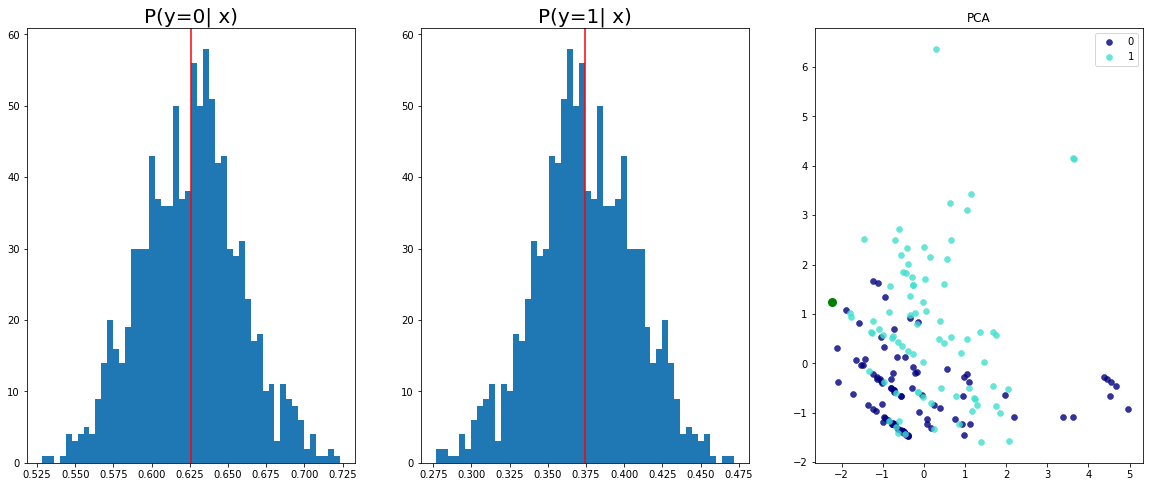

True -> 1
Predicted -> 0
STDS: 0.027773333713412285


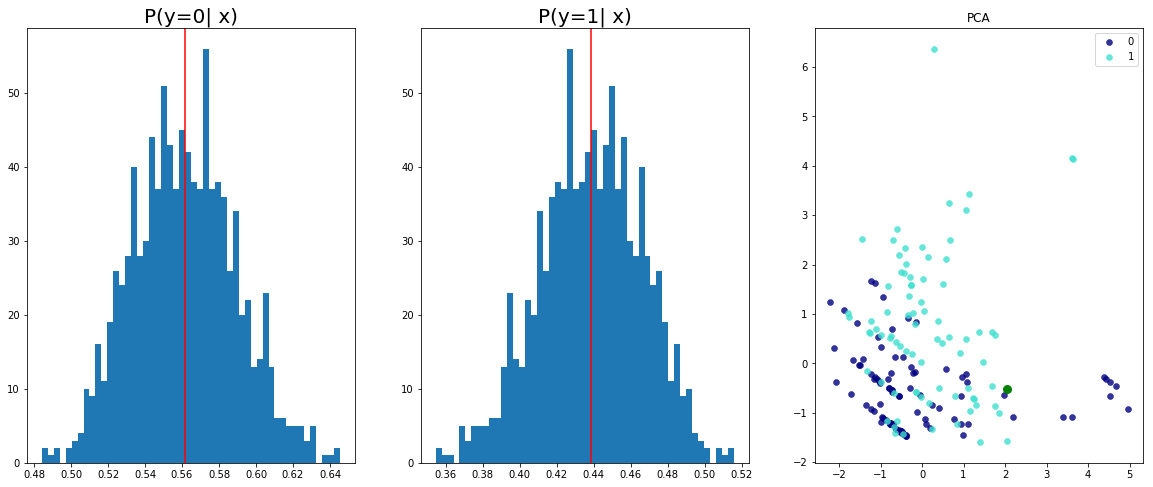

True -> 0
Predicted -> 0
STDS: 0.019969696179032326


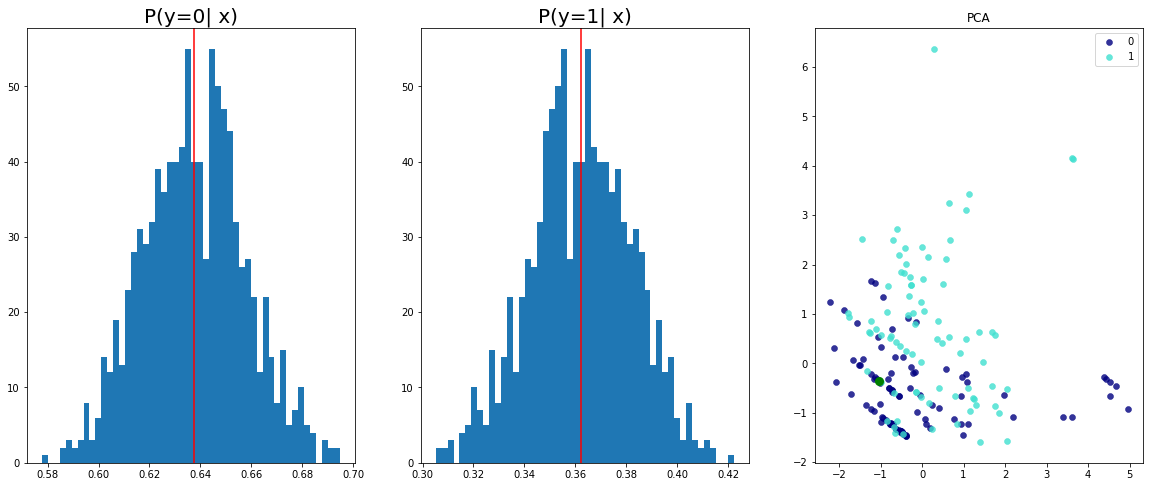

True -> 0
Predicted -> 0
STDS: 0.017986325547099113


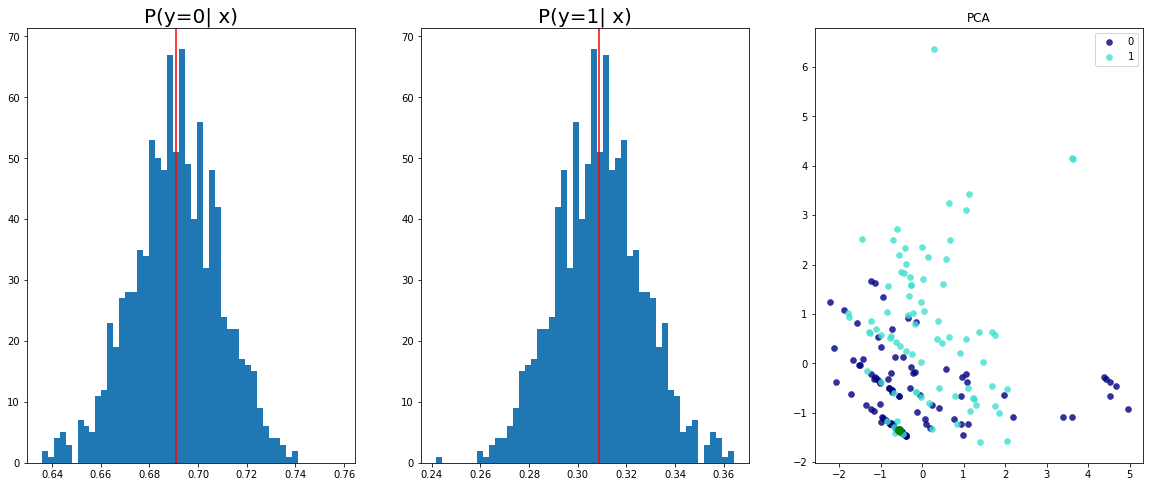

True -> 0
Predicted -> 0
STDS: 0.019124532118439674


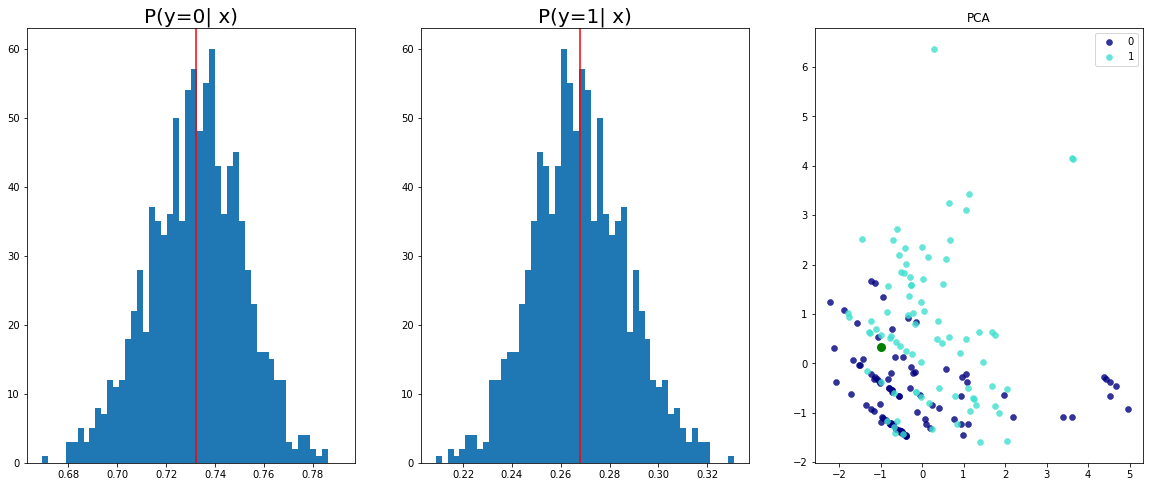

True -> 0
Predicted -> 0
STDS: 0.03132283687591553


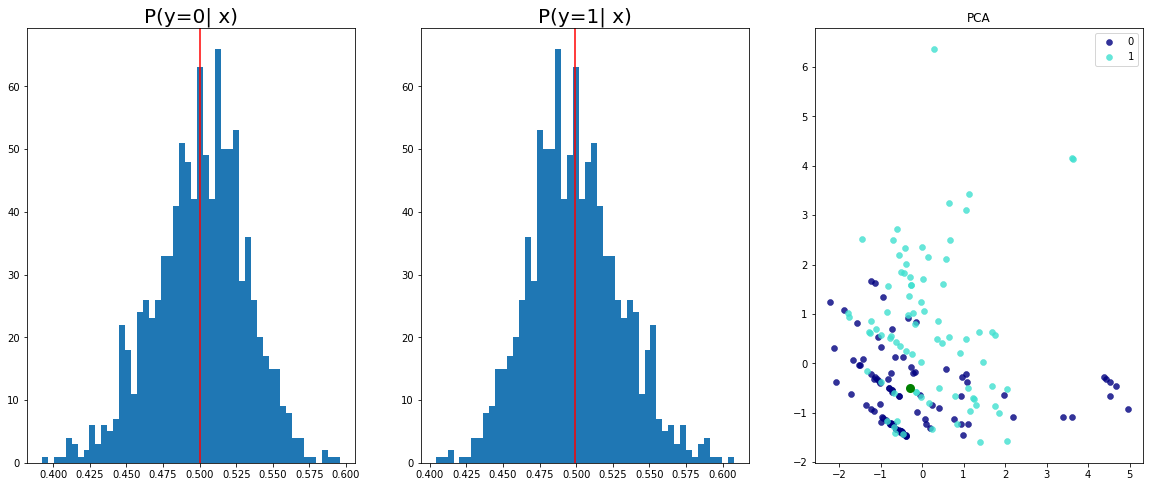

True -> 1
Predicted -> 0
STDS: 0.036402132362127304


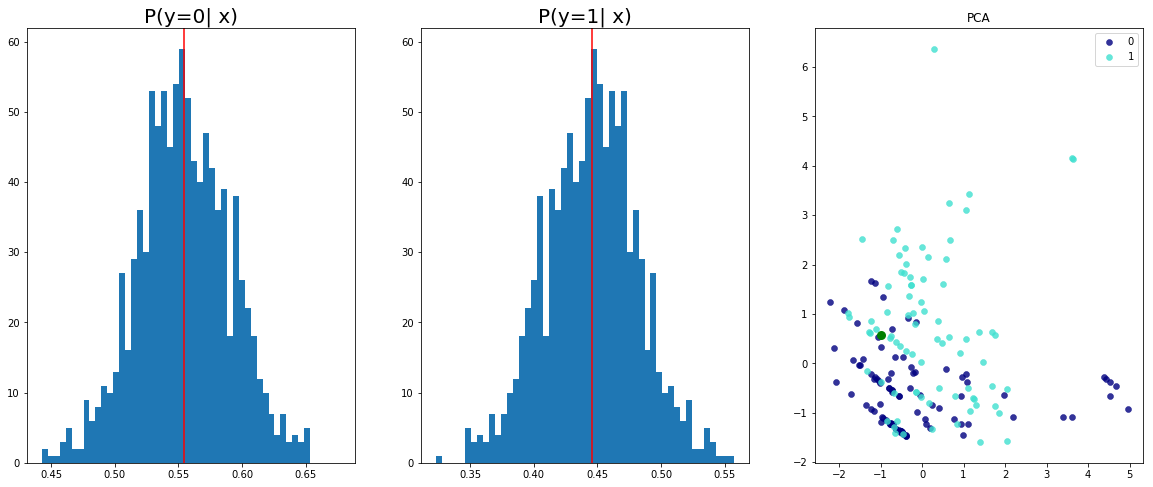

True -> 0
Predicted -> 0
STDS: 0.01901119016110897


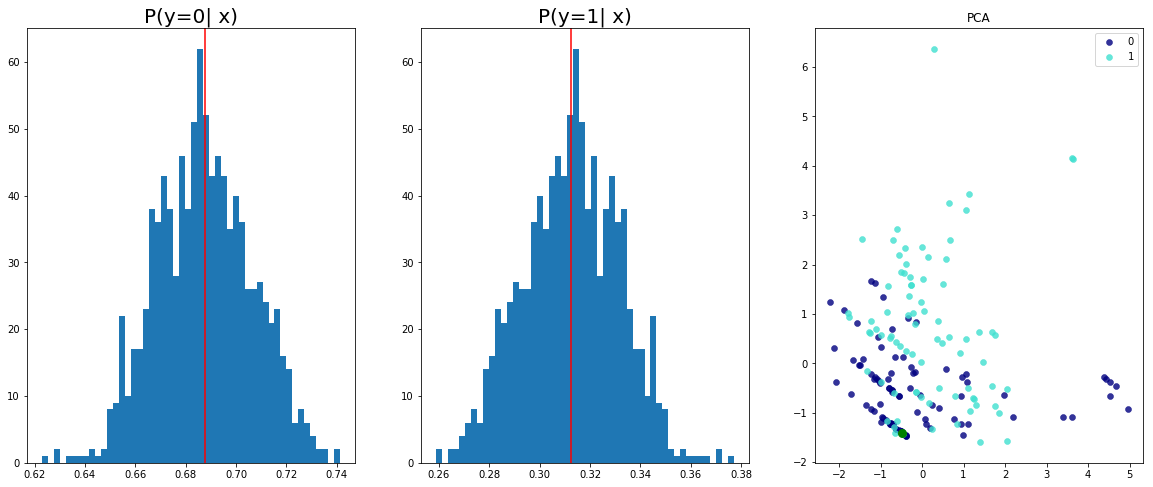

True -> 1
Predicted -> 1
STDS: 0.032904304563999176


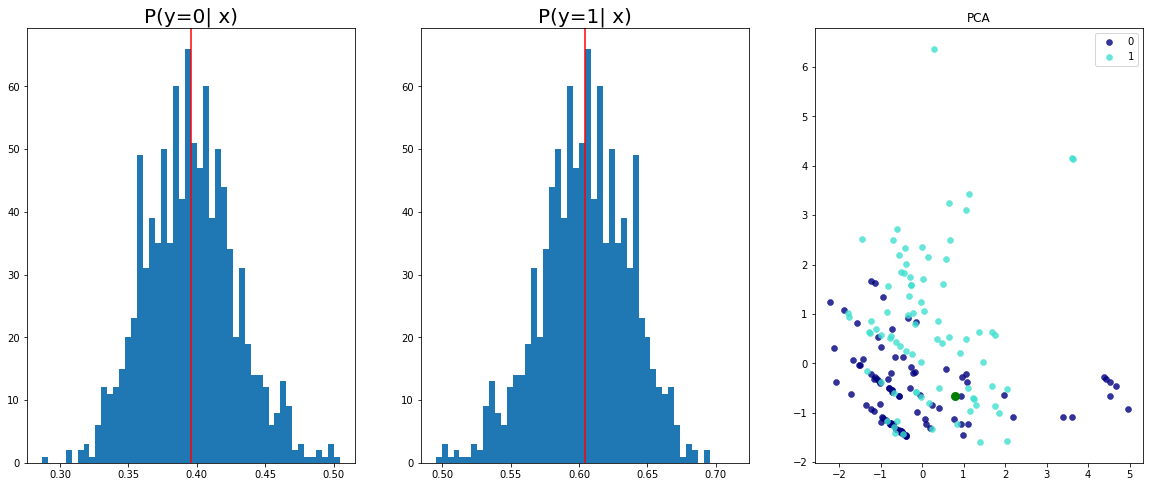

True -> 0
Predicted -> 0
STDS: 0.018158894032239914


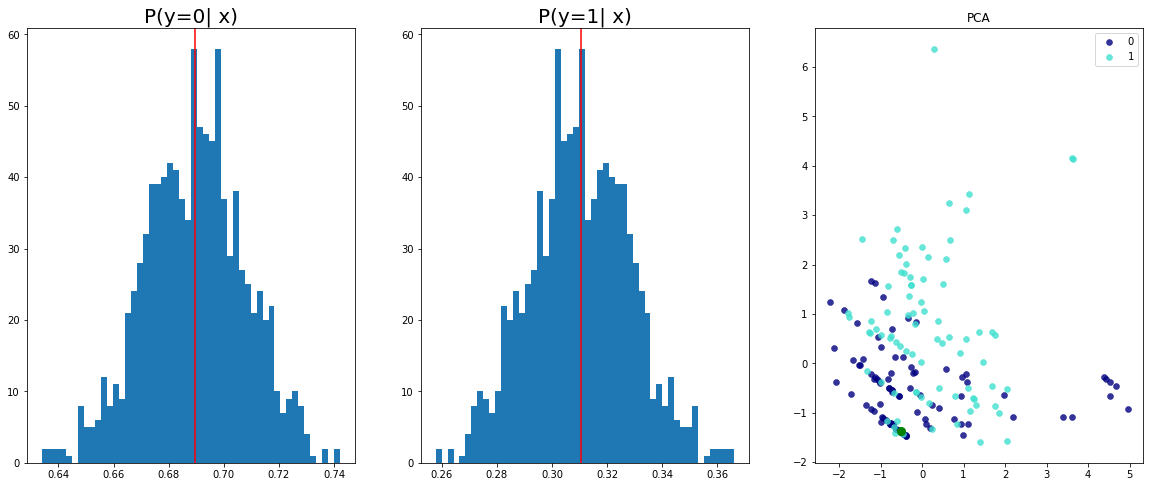

True -> 1
Predicted -> 1
STDS: 0.03097464144229889


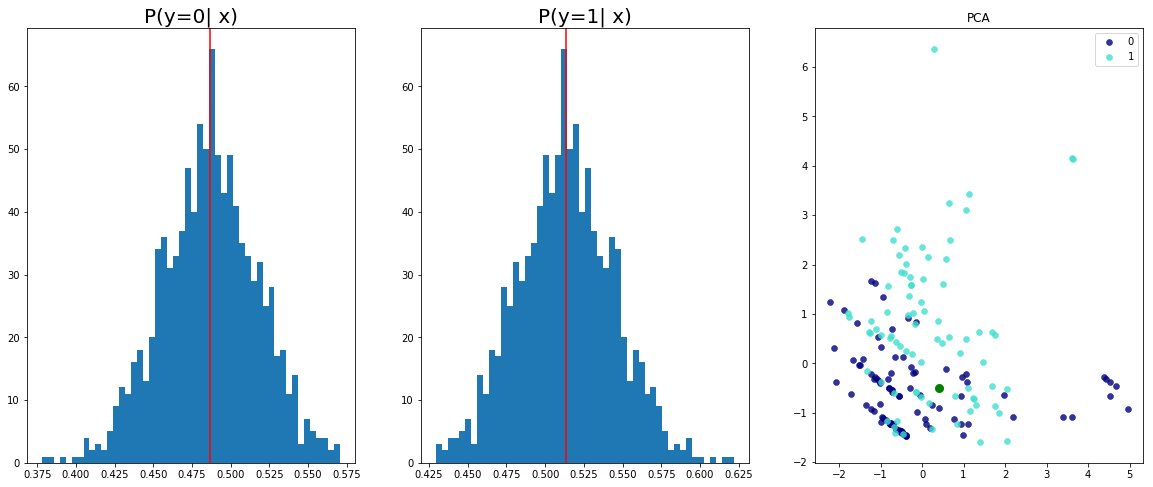

True -> 0
Predicted -> 1
STDS: 0.017600174993276596


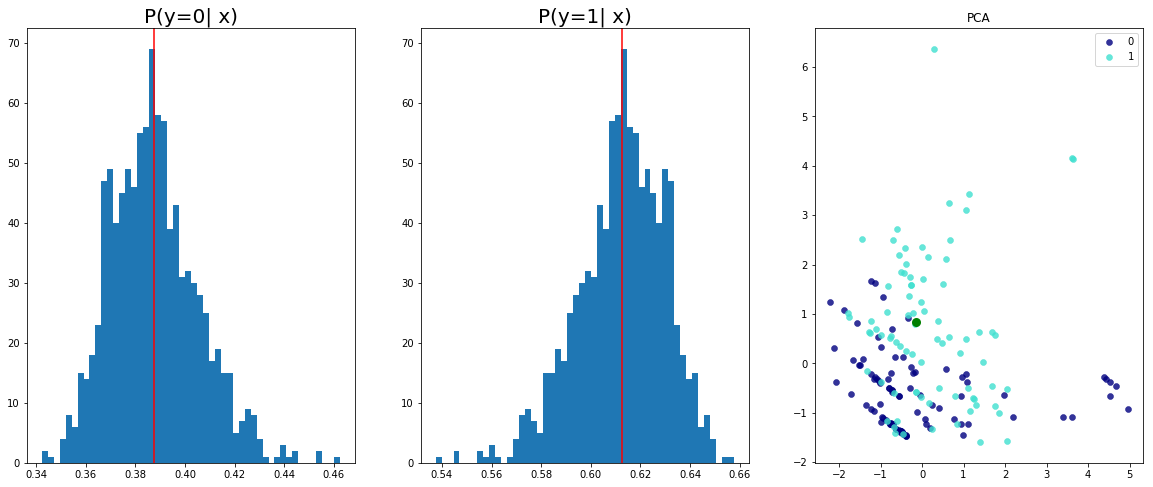

True -> 1
Predicted -> 1
STDS: 0.030058426782488823


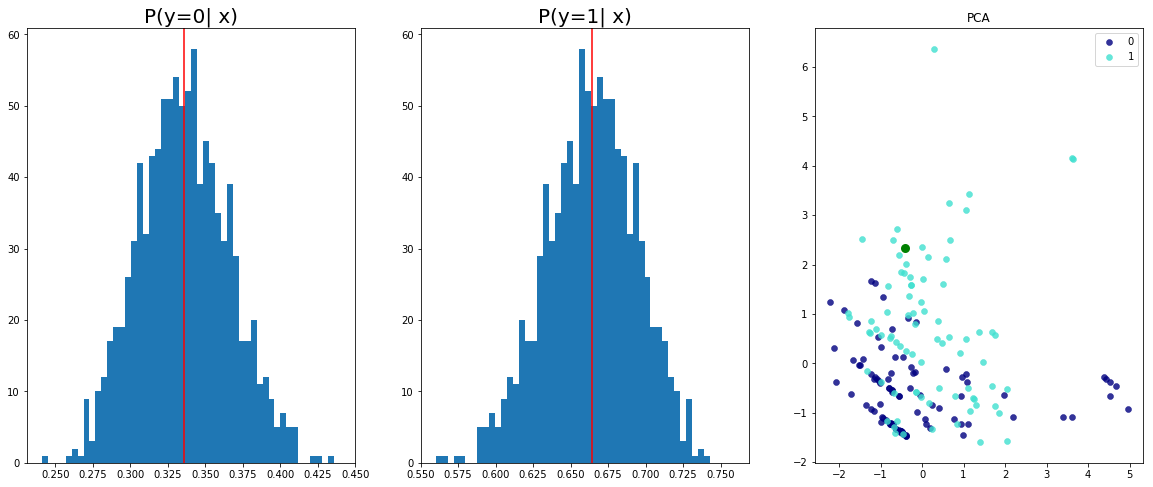

True -> 1
Predicted -> 1
STDS: 0.03968585282564163


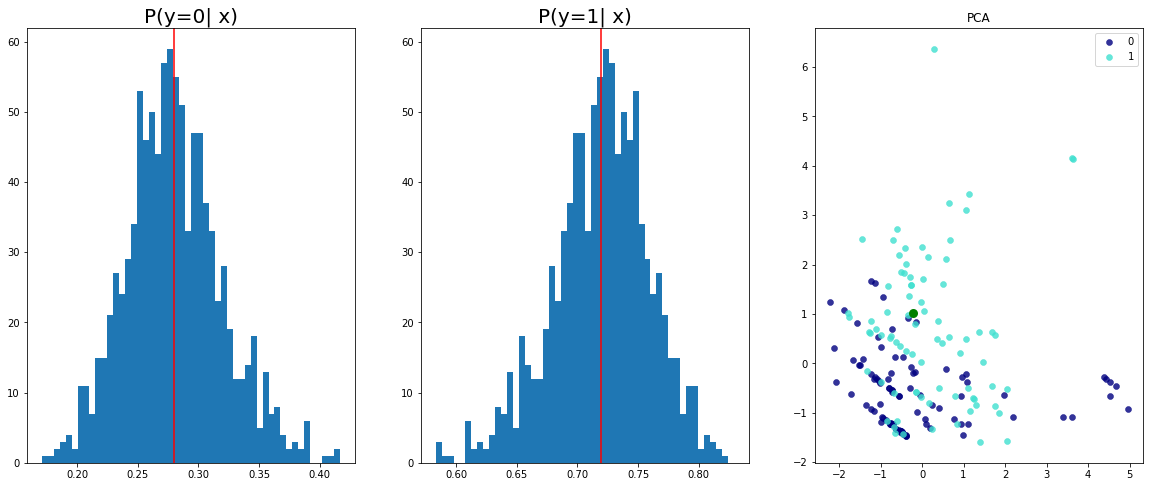

True -> 0
Predicted -> 0
STDS: 0.016851263120770454


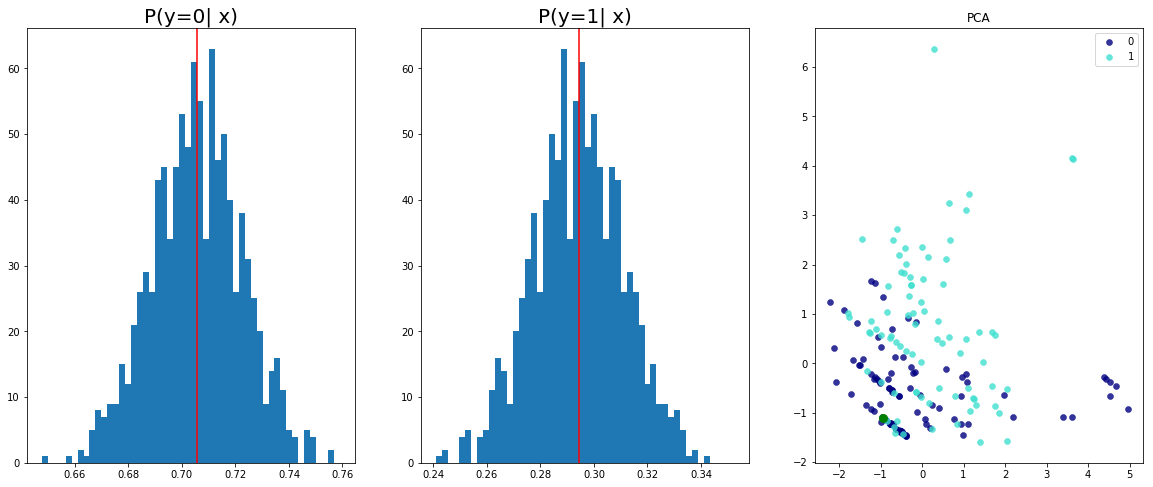

True -> 1
Predicted -> 1
STDS: 0.029343148693442345


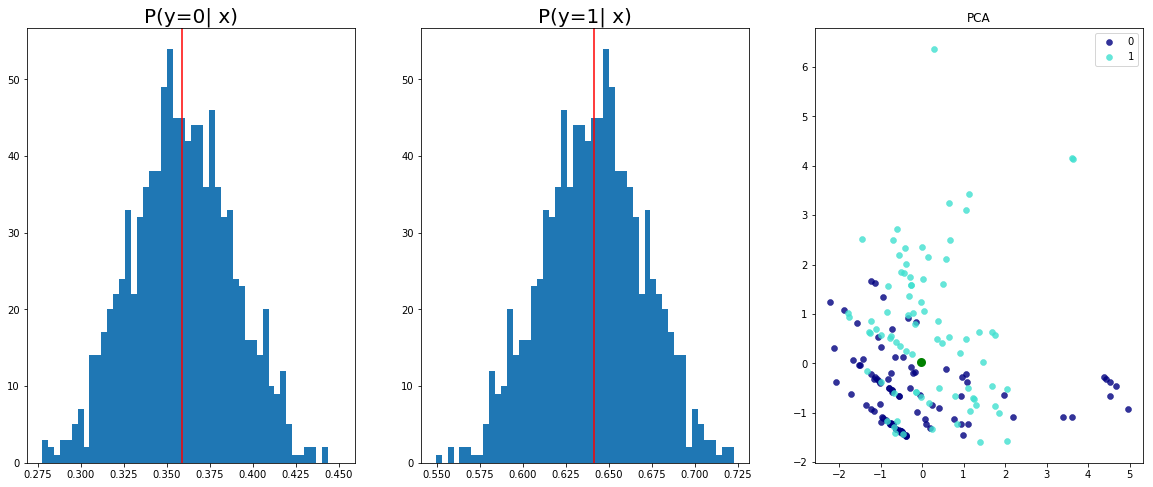

True -> 0
Predicted -> 1
STDS: 0.03221029043197632


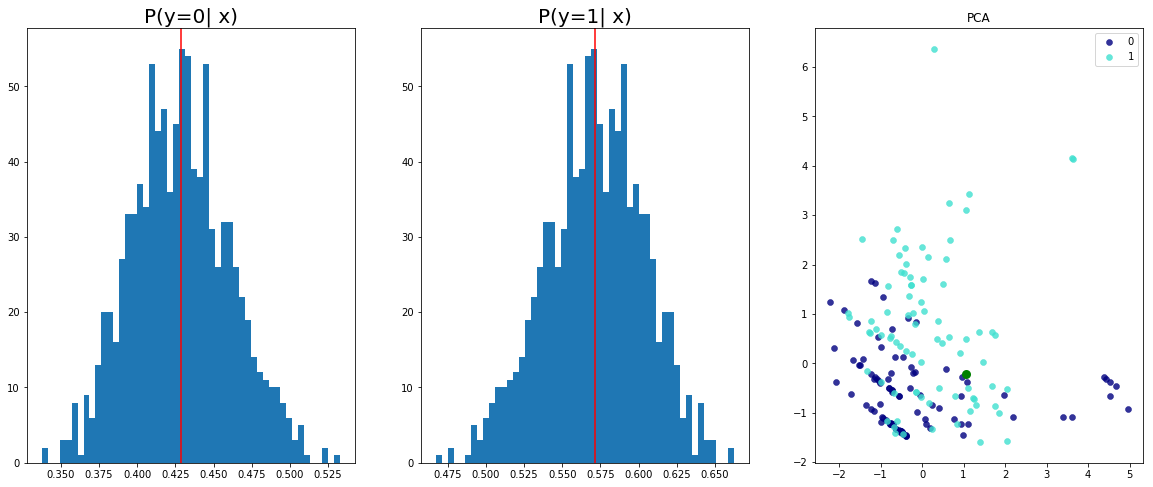

True -> 0
Predicted -> 0
STDS: 0.03345897048711777


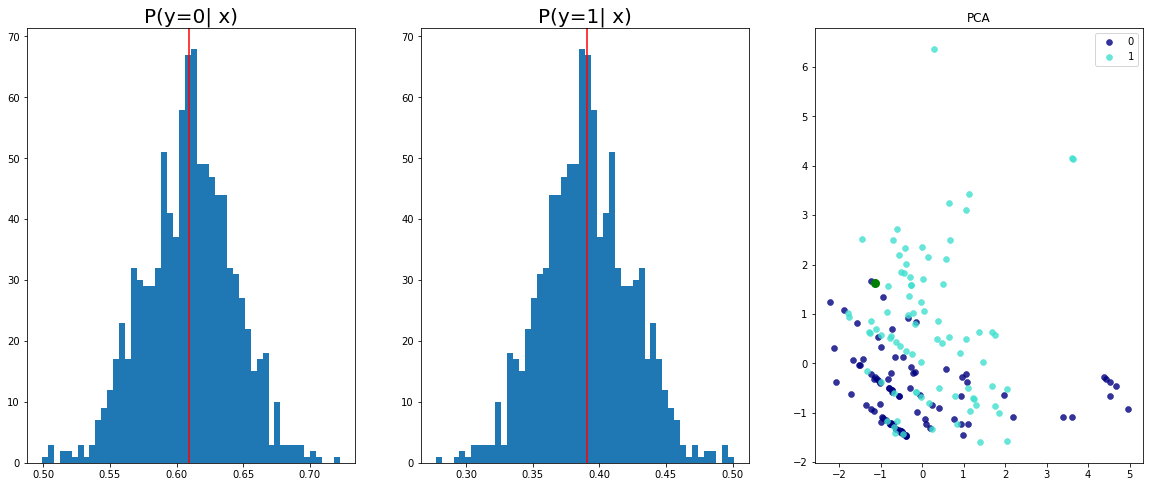

True -> 0
Predicted -> 0
STDS: 0.018705490976572037


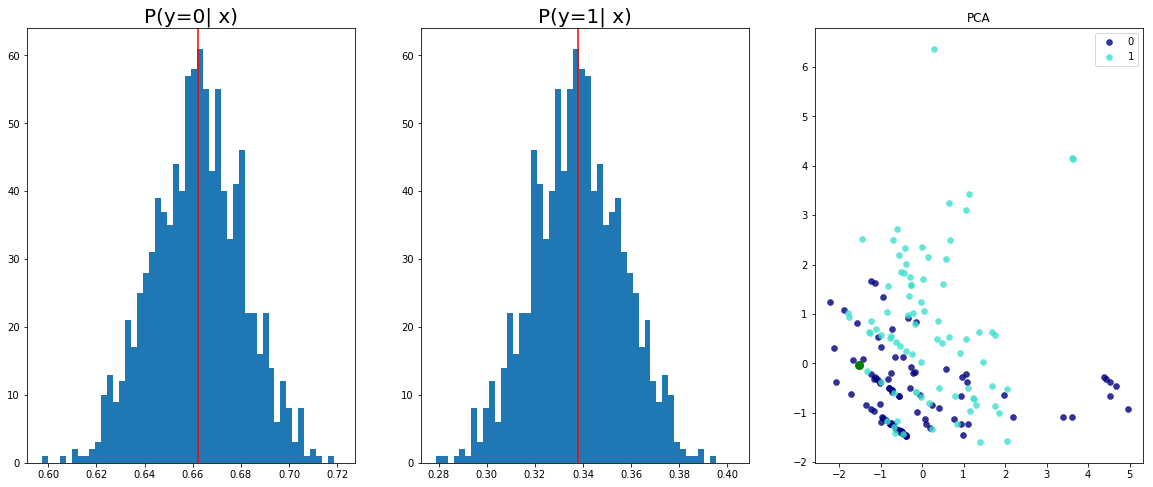

True -> 1
Predicted -> 1
STDS: 0.027570132166147232


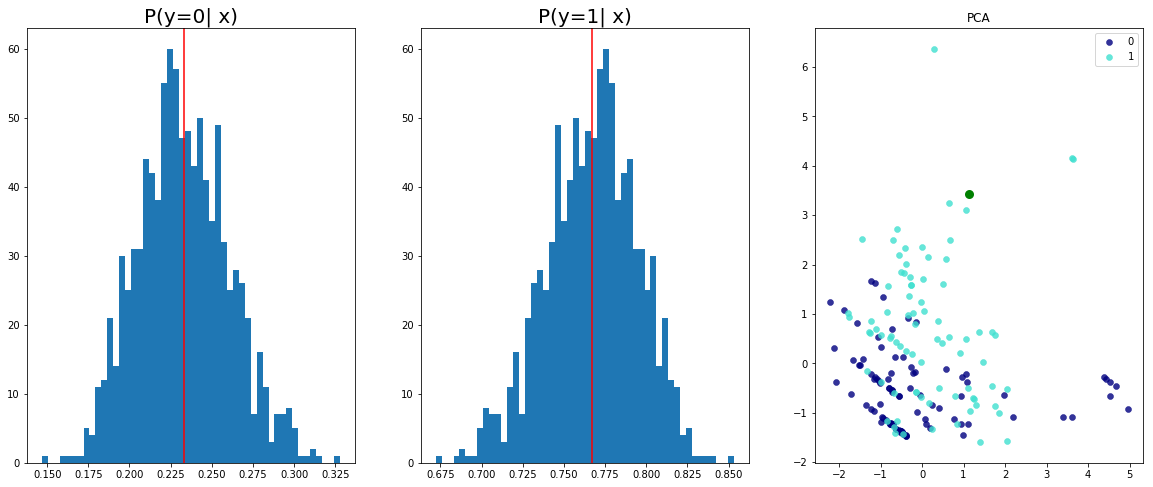

True -> 0
Predicted -> 0
STDS: 0.08578334003686905


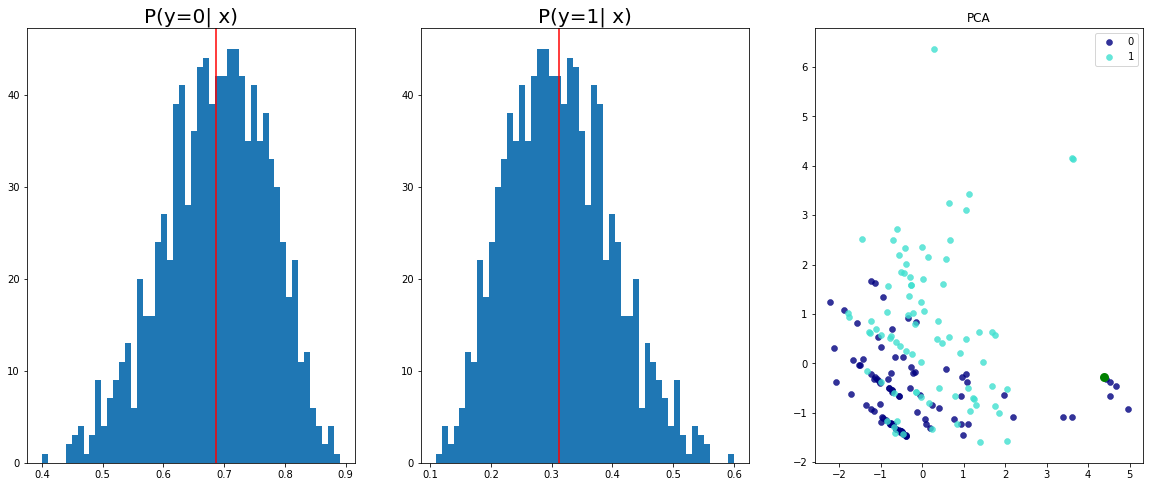

True -> 0
Predicted -> 0
STDS: 0.02703709714114666


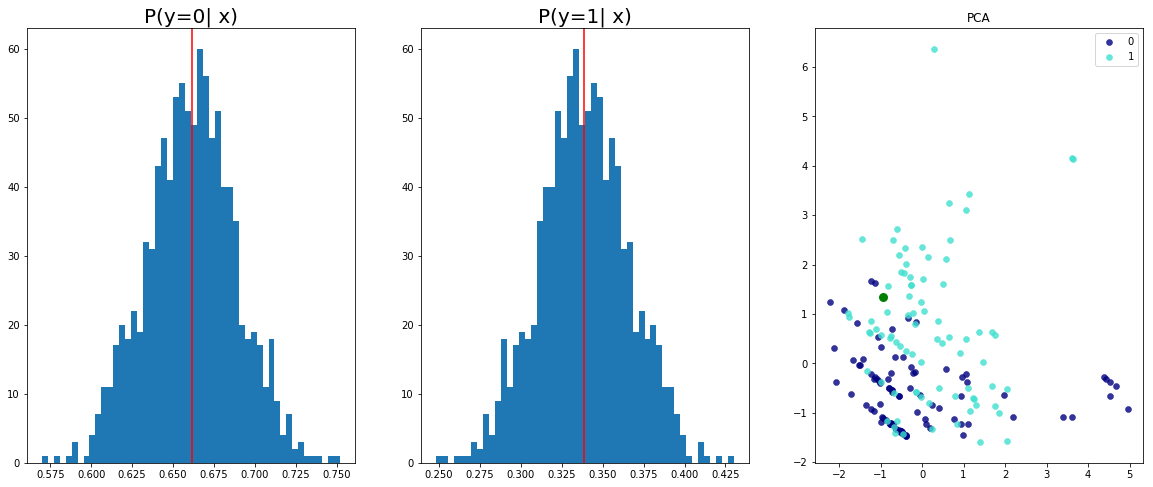

True -> 0
Predicted -> 0
STDS: 0.05677047744393349


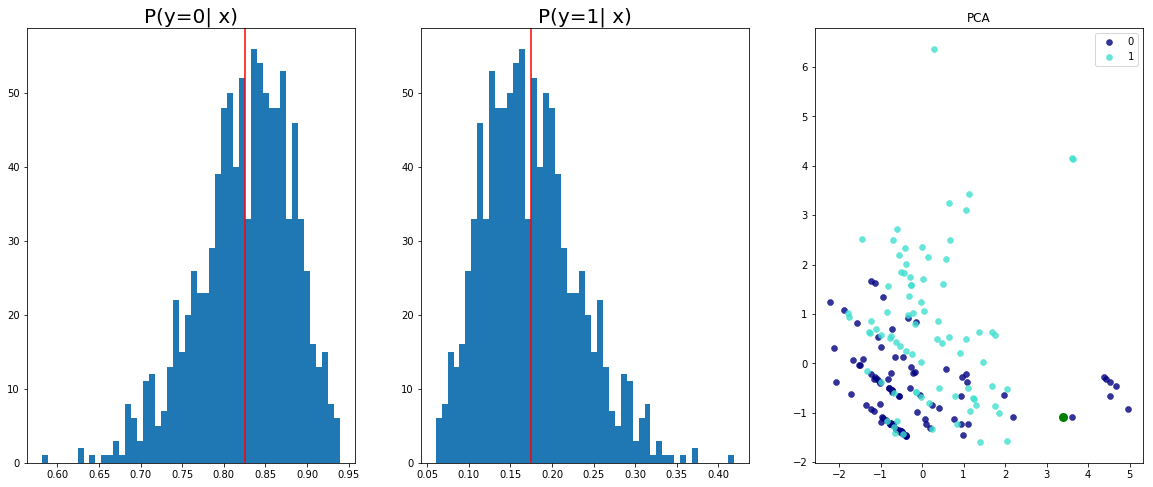

True -> 1
Predicted -> 1
STDS: 0.042934149503707886


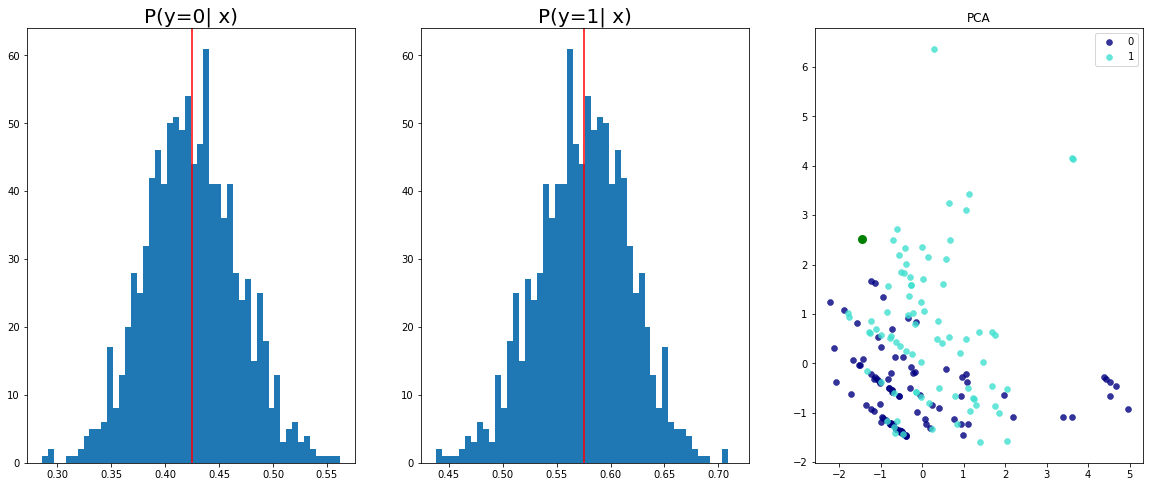

True -> 0
Predicted -> 0
STDS: 0.019822927191853523


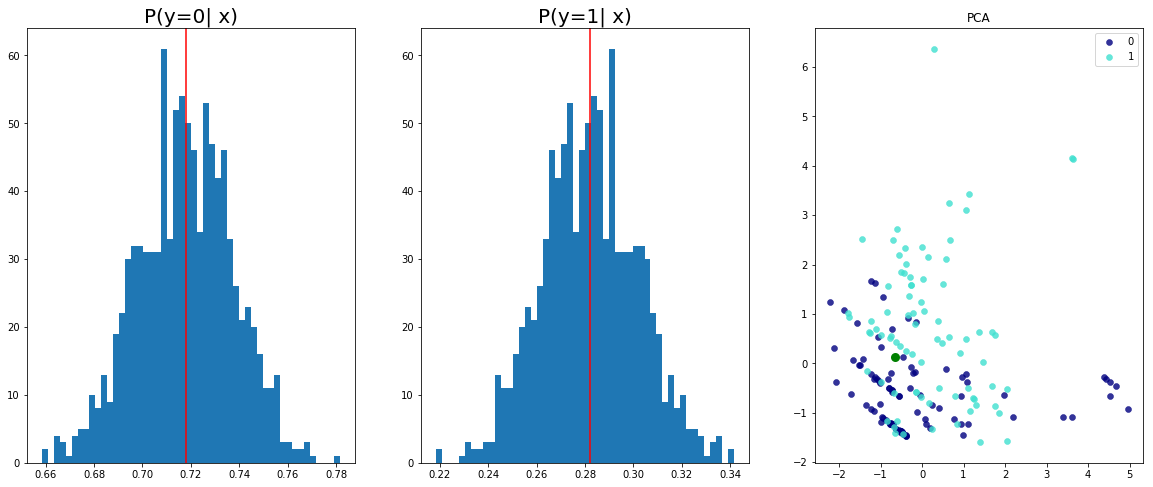

True -> 0
Predicted -> 0
STDS: 0.09374597668647766


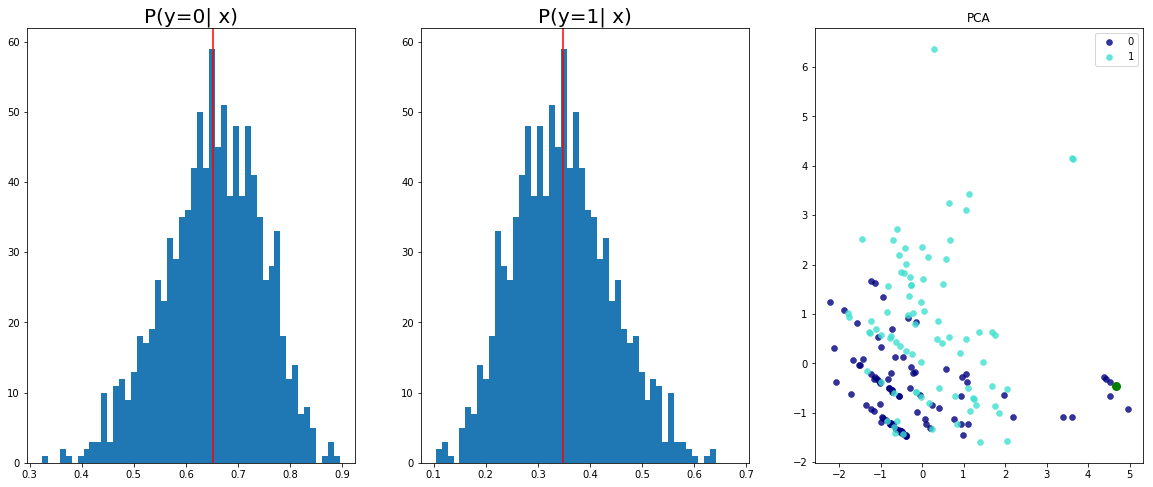

True -> 0
Predicted -> 0
STDS: 0.019538691267371178


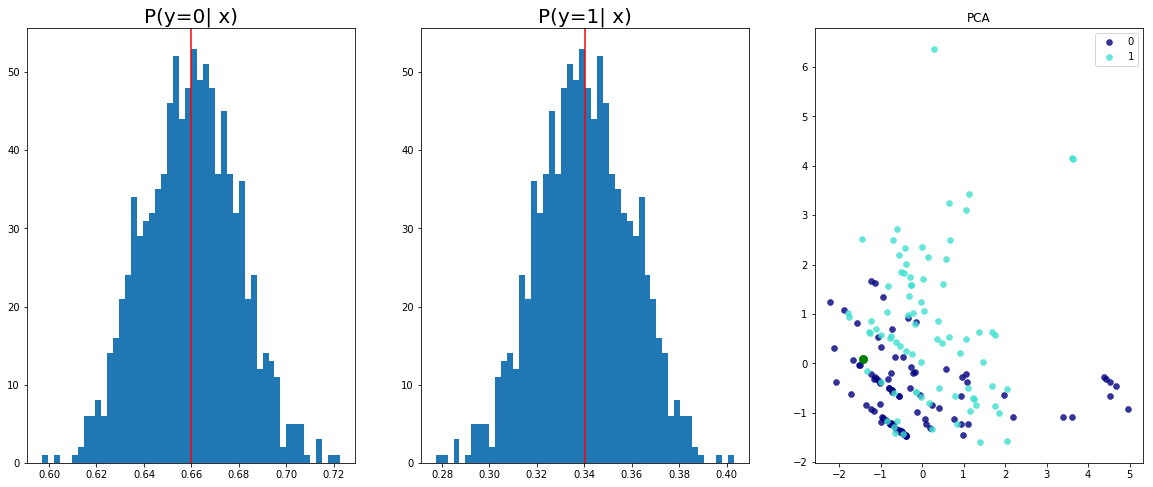

True -> 0
Predicted -> 0
STDS: 0.038543783128261566


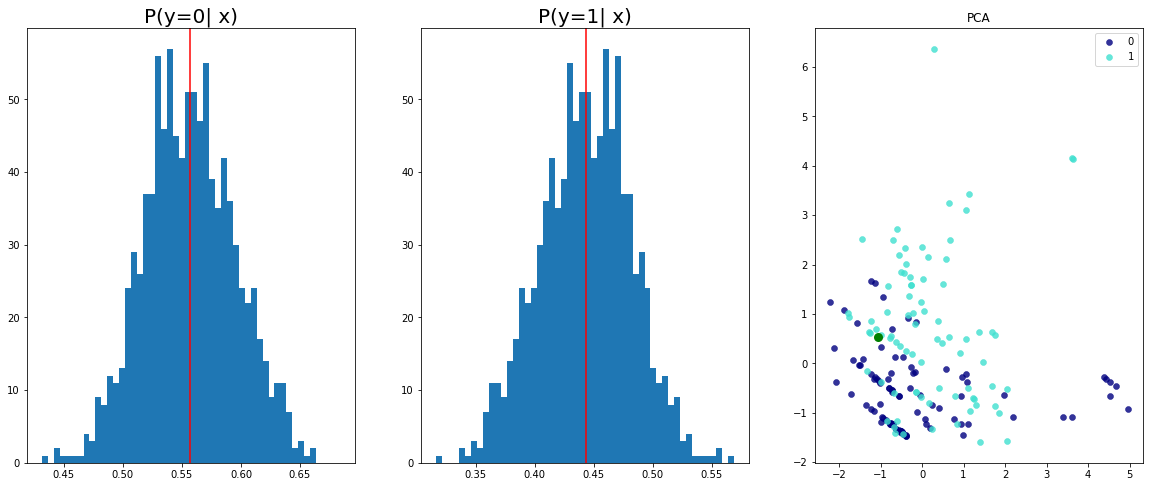

True -> 1
Predicted -> 0
STDS: 0.01917997933924198


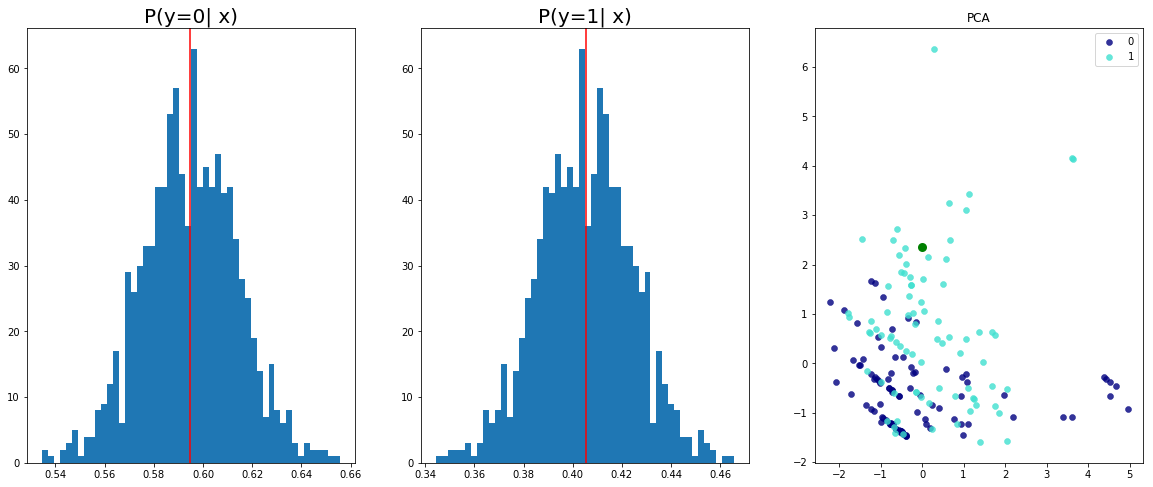

True -> 1
Predicted -> 1
STDS: 0.016431232914328575


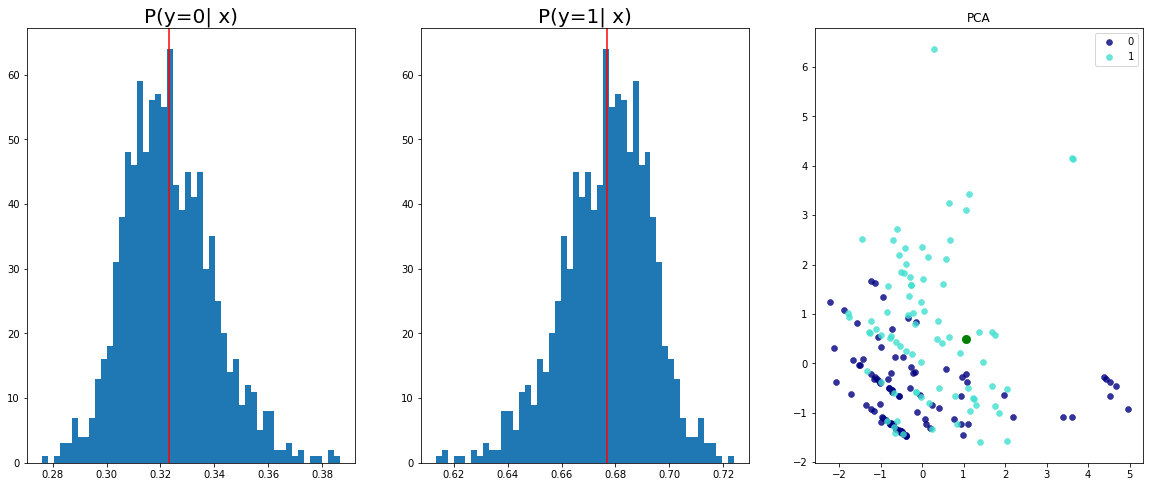

True -> 0
Predicted -> 0
STDS: 0.019312765449285507


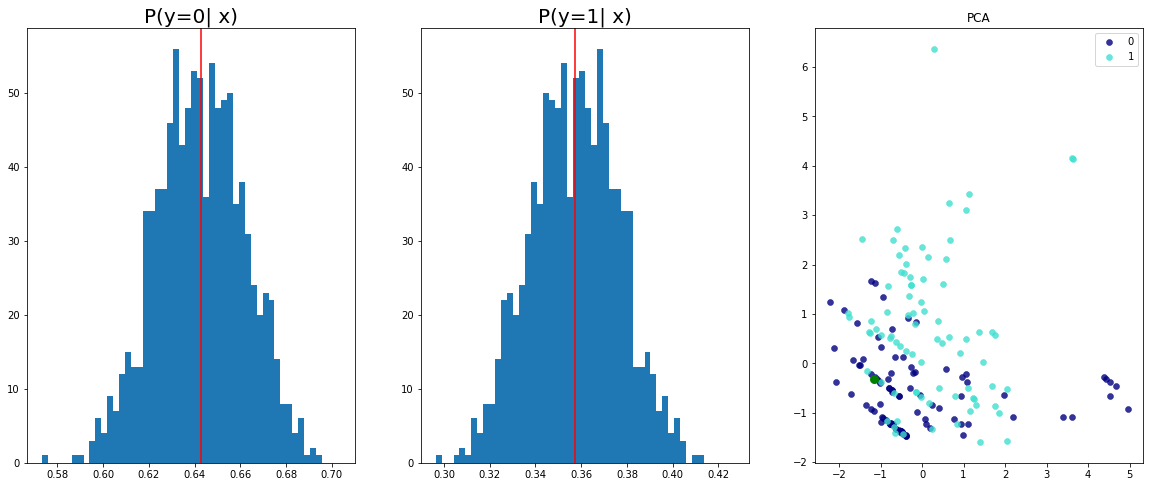

True -> 0
Predicted -> 0
STDS: 0.015436600893735886


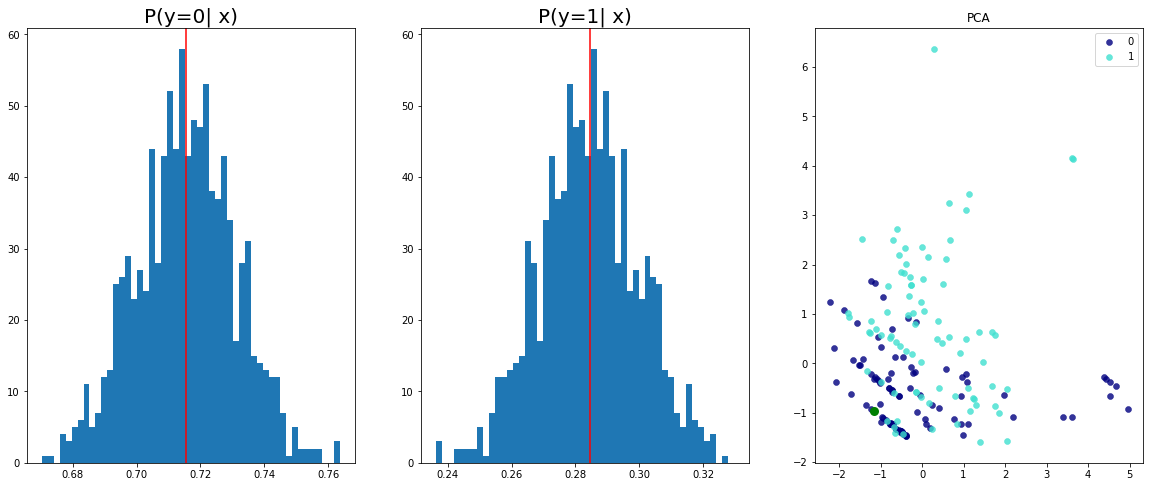

True -> 1
Predicted -> 0
STDS: 0.031317707151174545


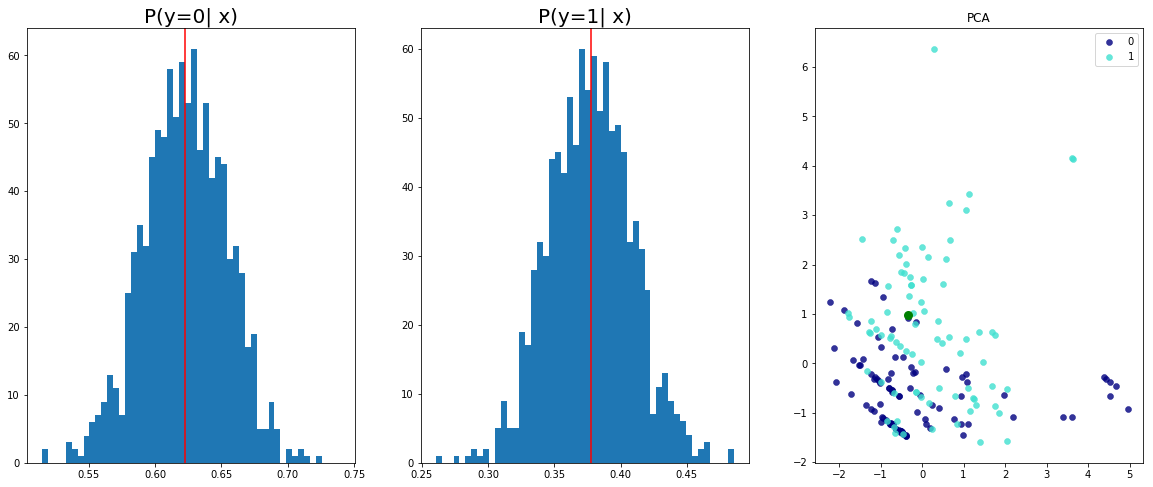

True -> 0
Predicted -> 0
STDS: 0.02799718640744686


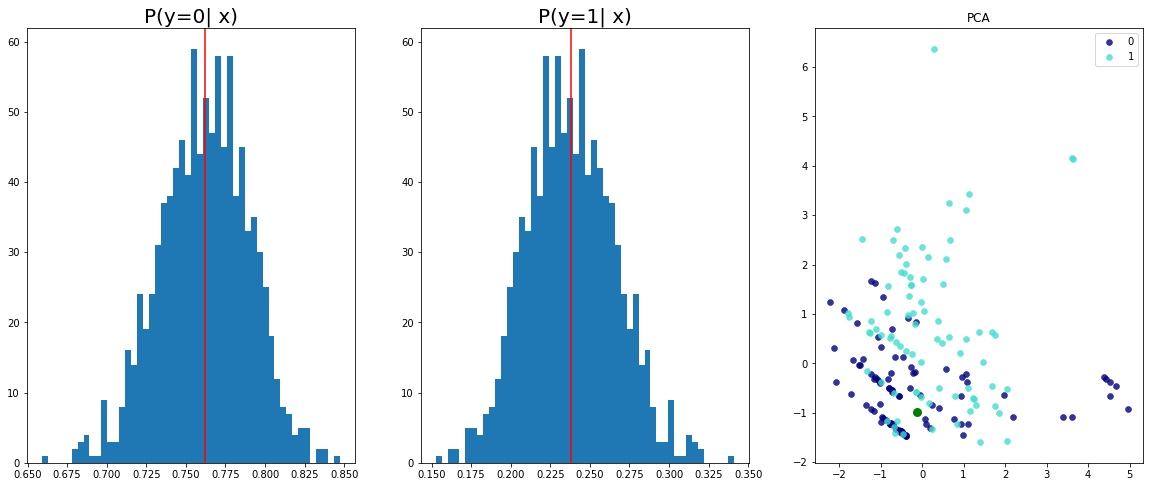

True -> 1
Predicted -> 1
STDS: 0.019284944981336594


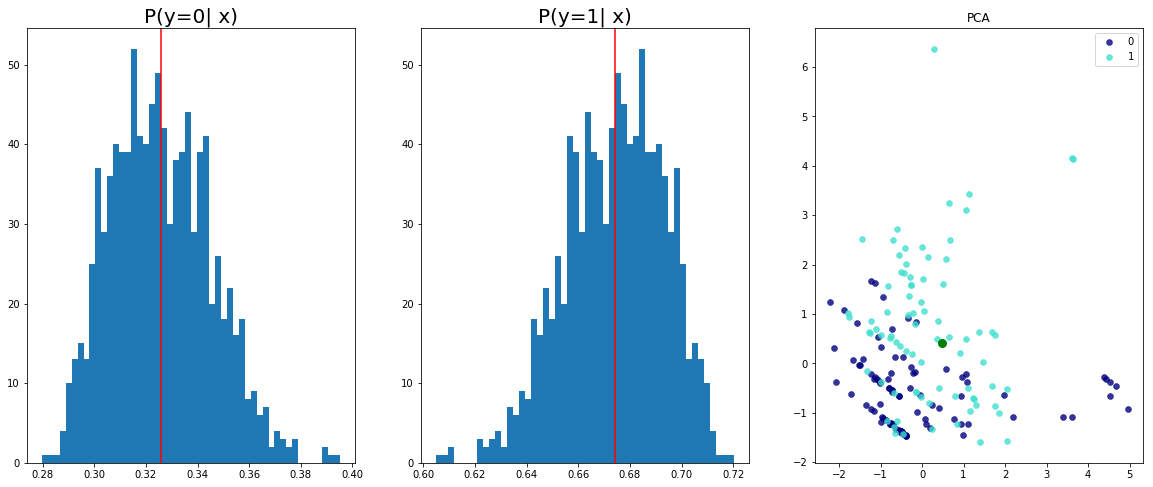

True -> 0
Predicted -> 0
STDS: 0.01733572781085968


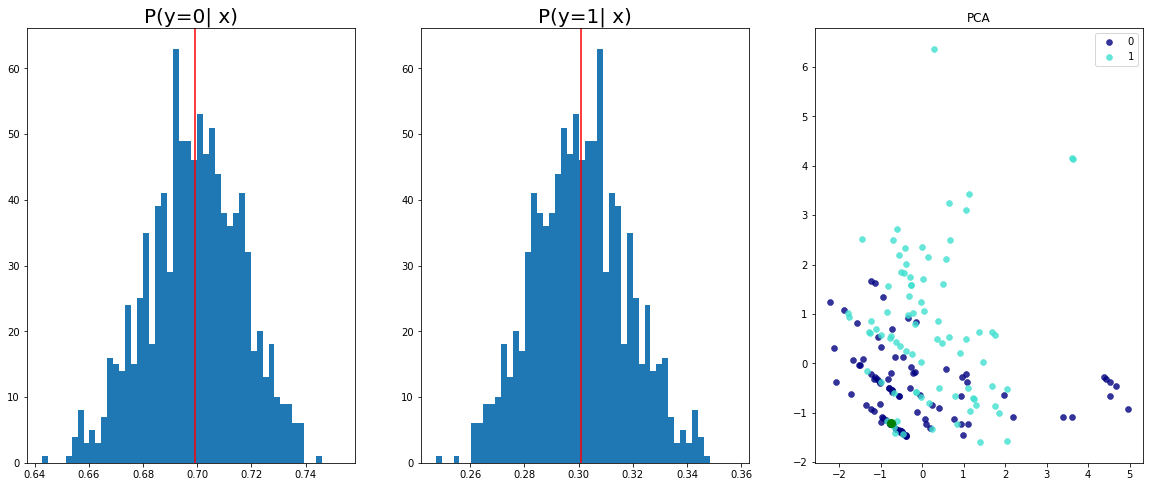

True -> 0
Predicted -> 0
STDS: 0.03944198787212372


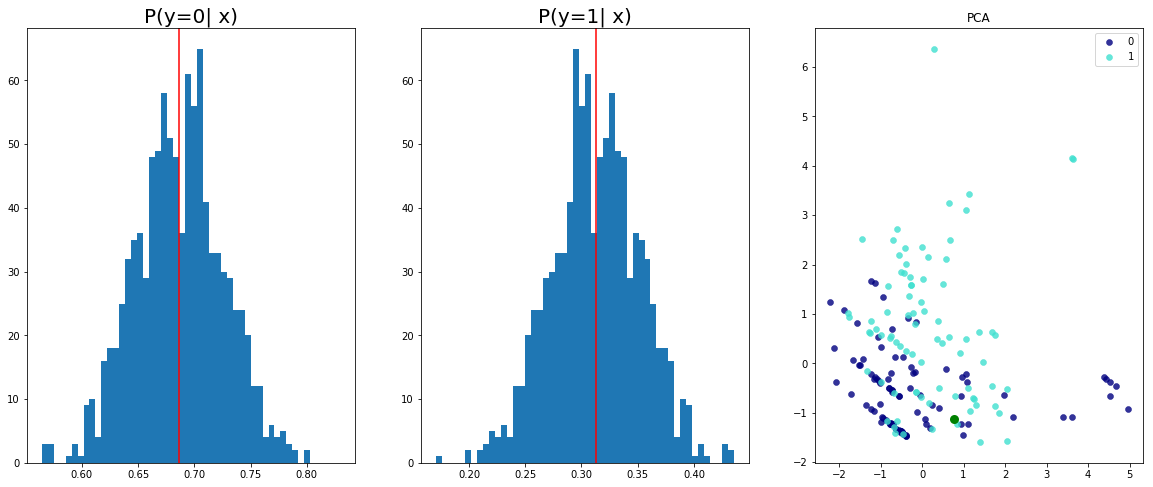

True -> 1
Predicted -> 0
STDS: 0.0206916481256485


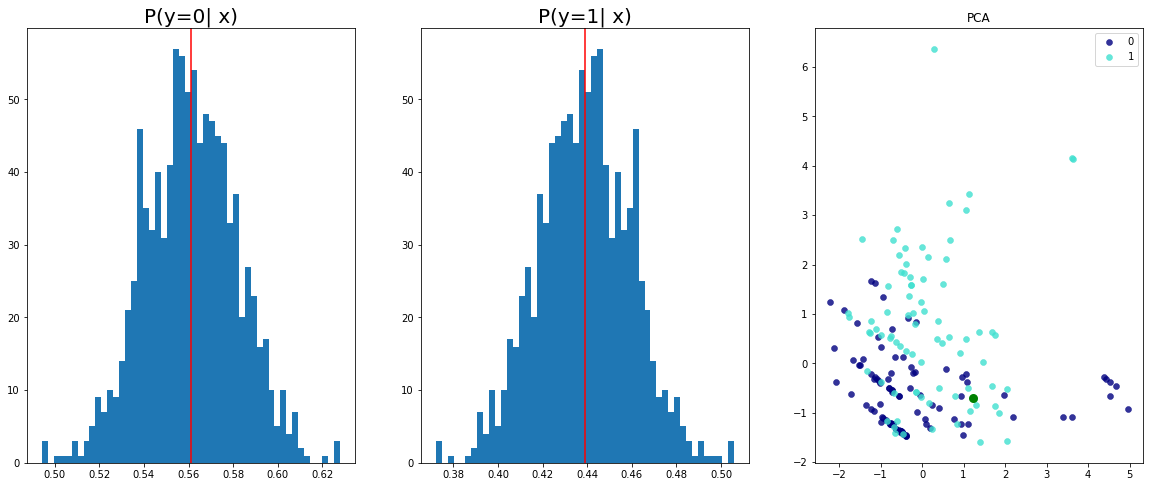

True -> 0
Predicted -> 0
STDS: 0.015894806012511253


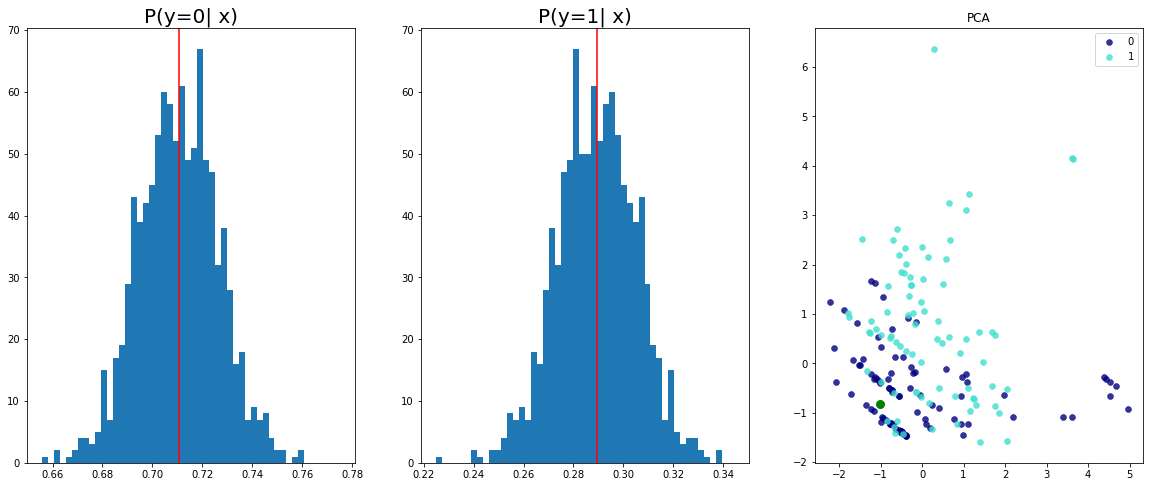

True -> 0
Predicted -> 0
STDS: 0.029383311048150063


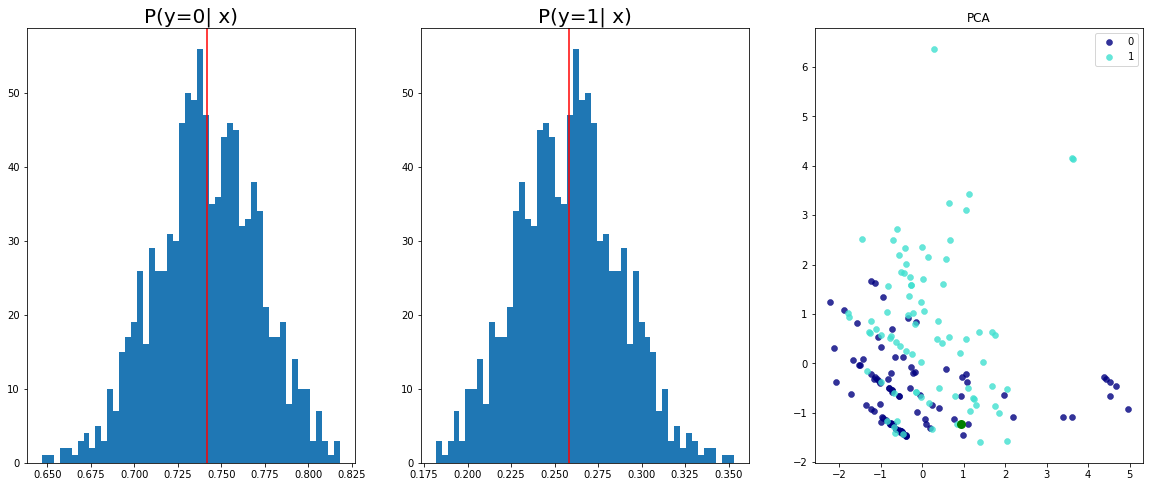

True -> 1
Predicted -> 1
STDS: 0.04074947163462639


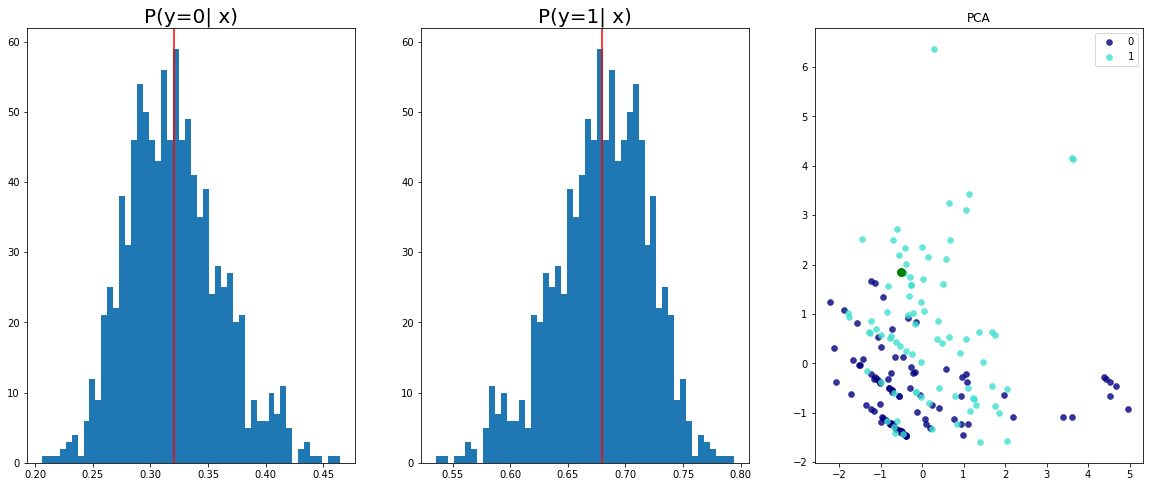

True -> 0
Predicted -> 0
STDS: 0.020744774490594864


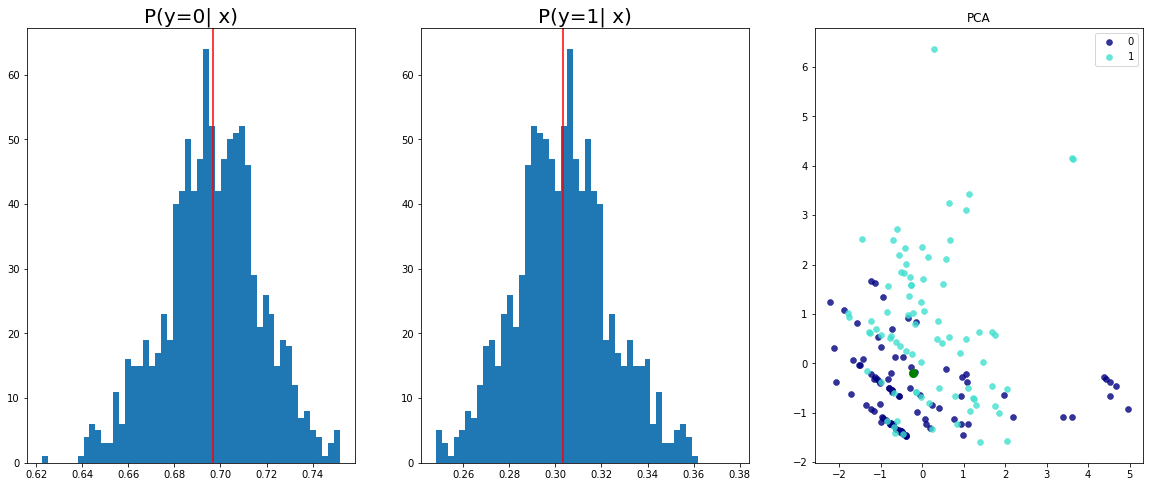

True -> 1
Predicted -> 0
STDS: 0.031005019322037697


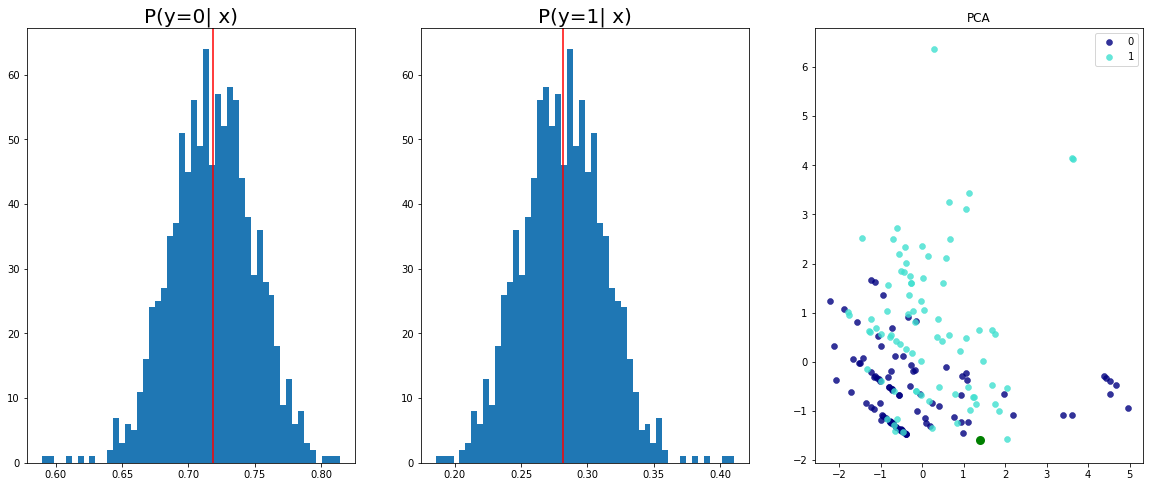

True -> 1
Predicted -> 0
STDS: 0.03511287644505501


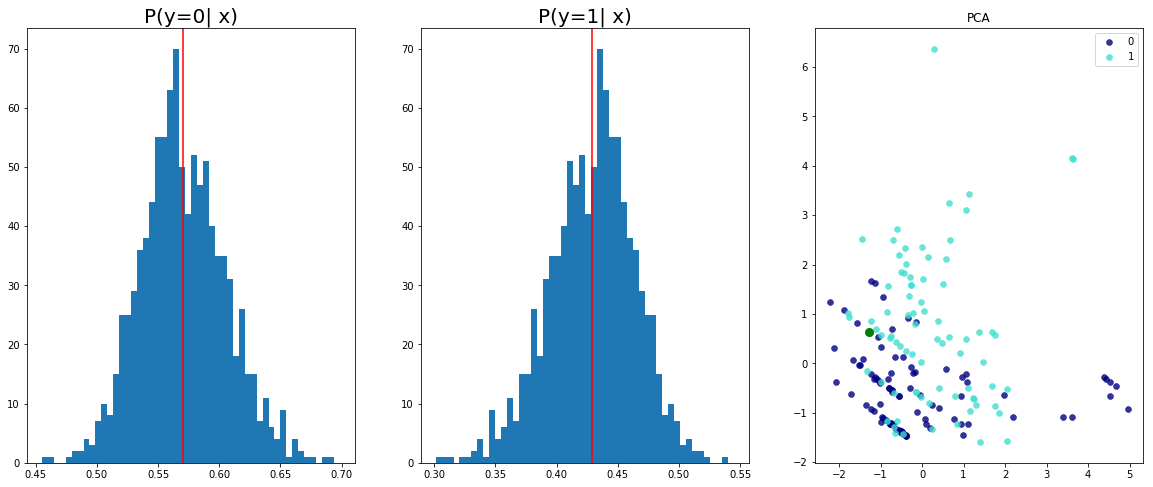

True -> 1
Predicted -> 1
STDS: 0.04017827659845352


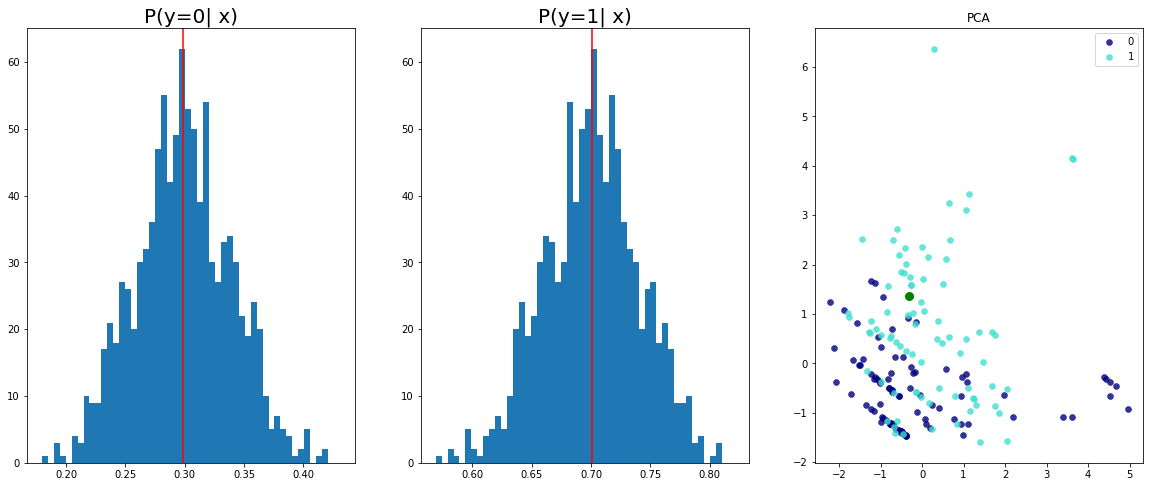

True -> 0
Predicted -> 1
STDS: 0.04071003943681717


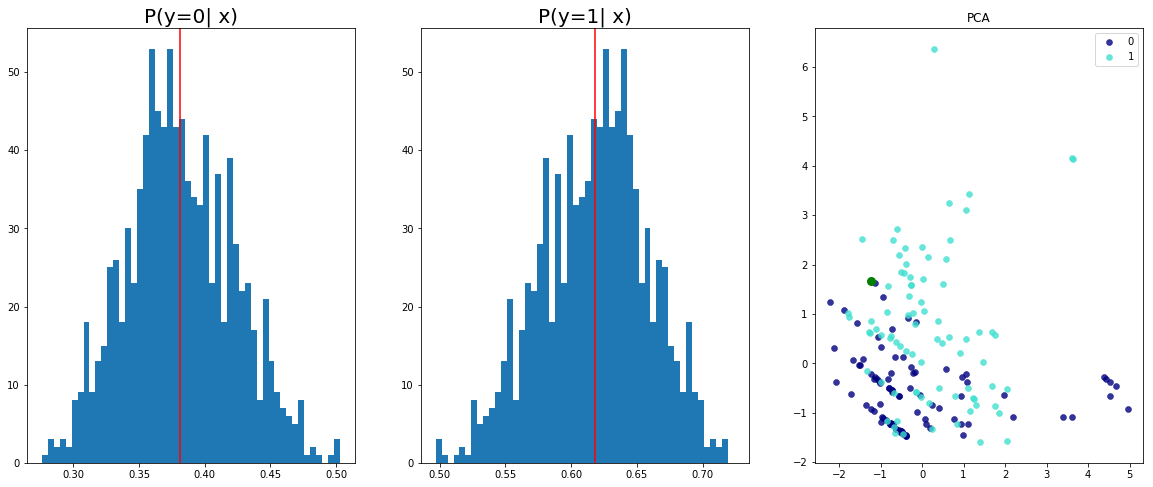

True -> 1
Predicted -> 1
STDS: 0.03386678919196129


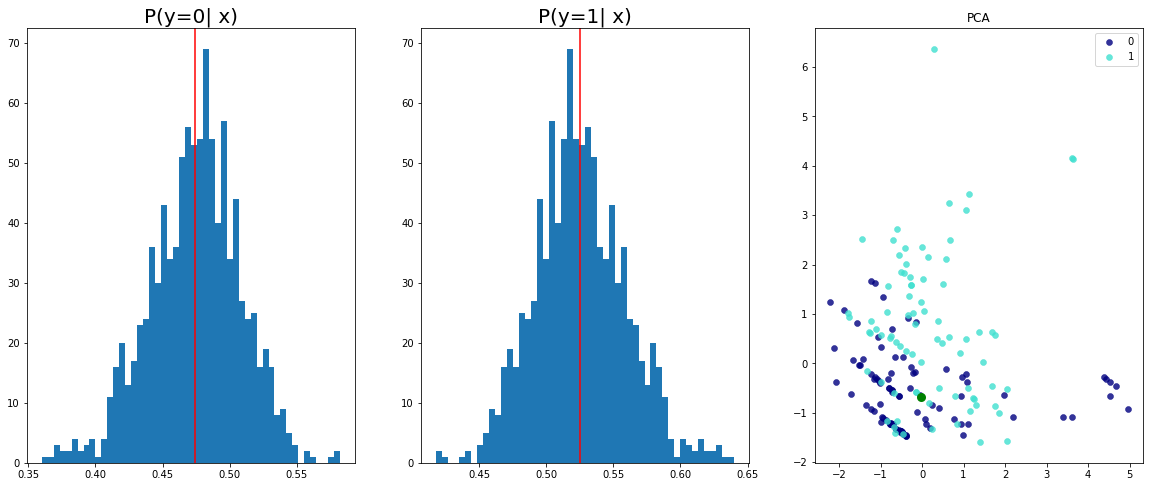

True -> 1
Predicted -> 1
STDS: 0.02870366908609867


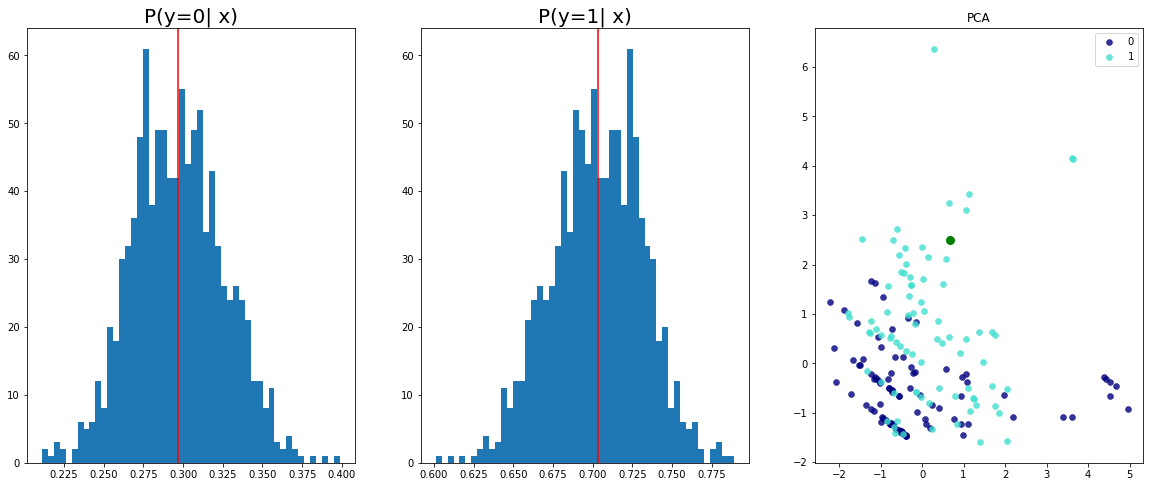

True -> 1
Predicted -> 1
STDS: 0.029396025463938713


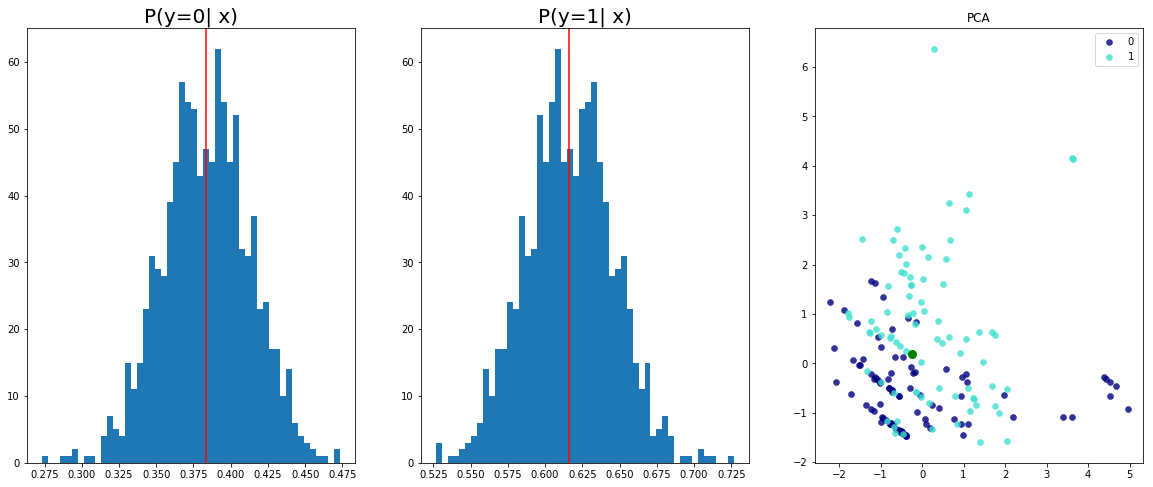

True -> 1
Predicted -> 0
STDS: 0.02950344979763031


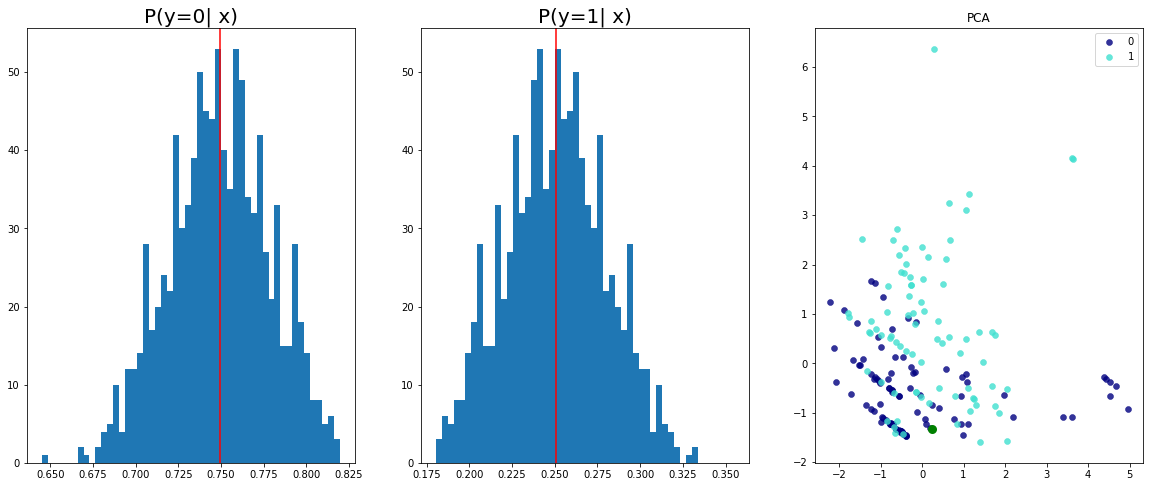

True -> 1
Predicted -> 0
STDS: 0.019035931676626205


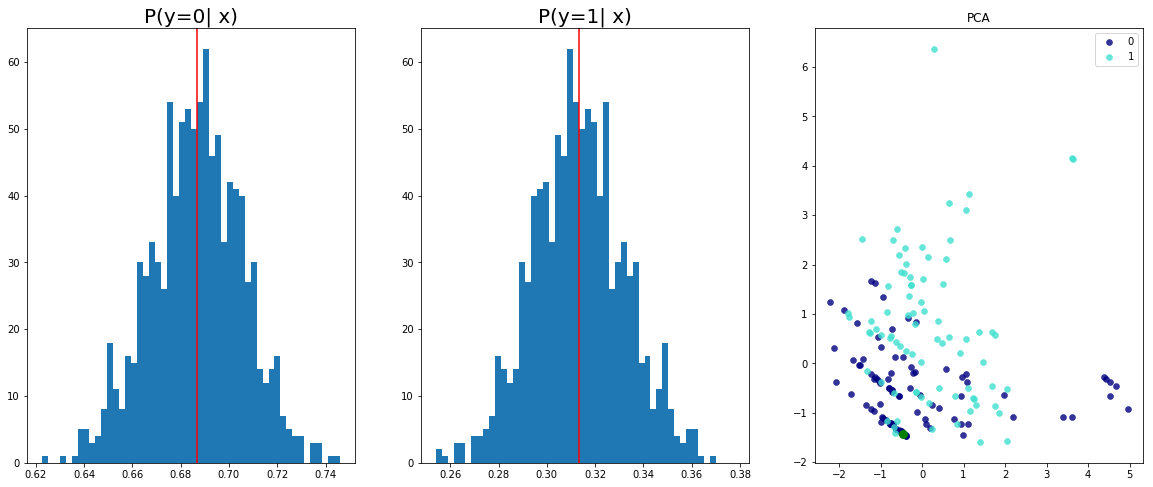

True -> 0
Predicted -> 0
STDS: 0.01884044148027897


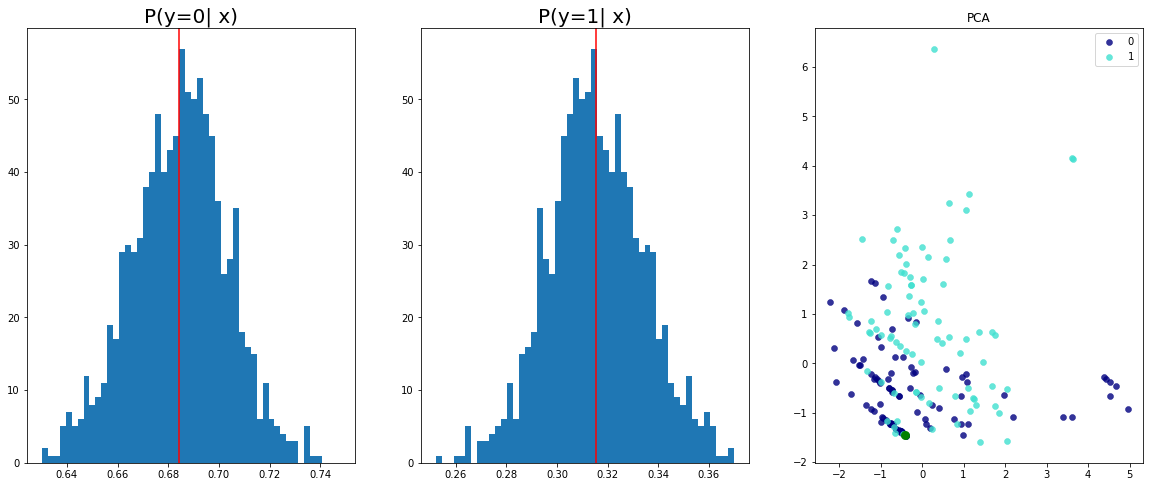

True -> 0
Predicted -> 0
STDS: 0.03401823714375496


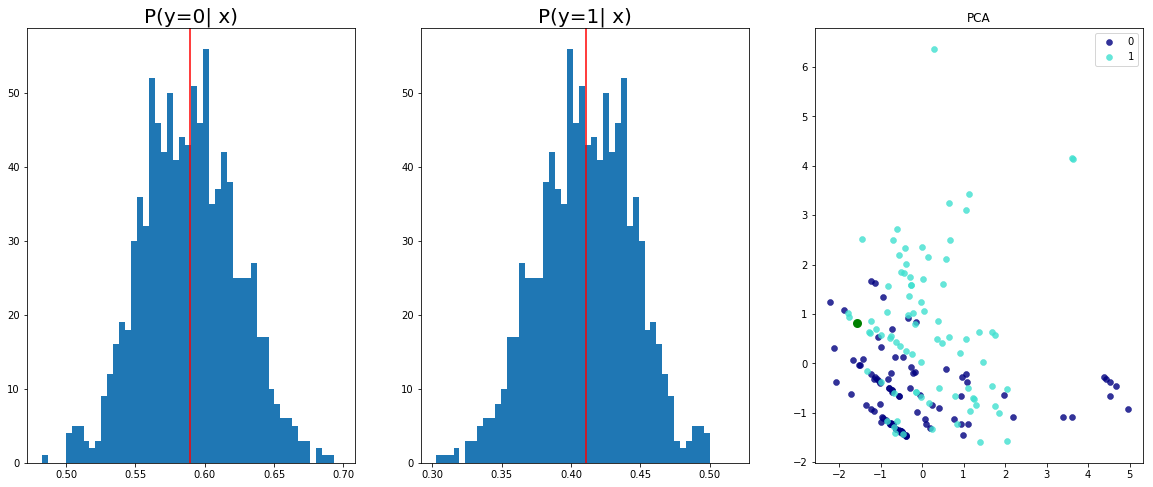

True -> 1
Predicted -> 0
STDS: 0.031976472586393356


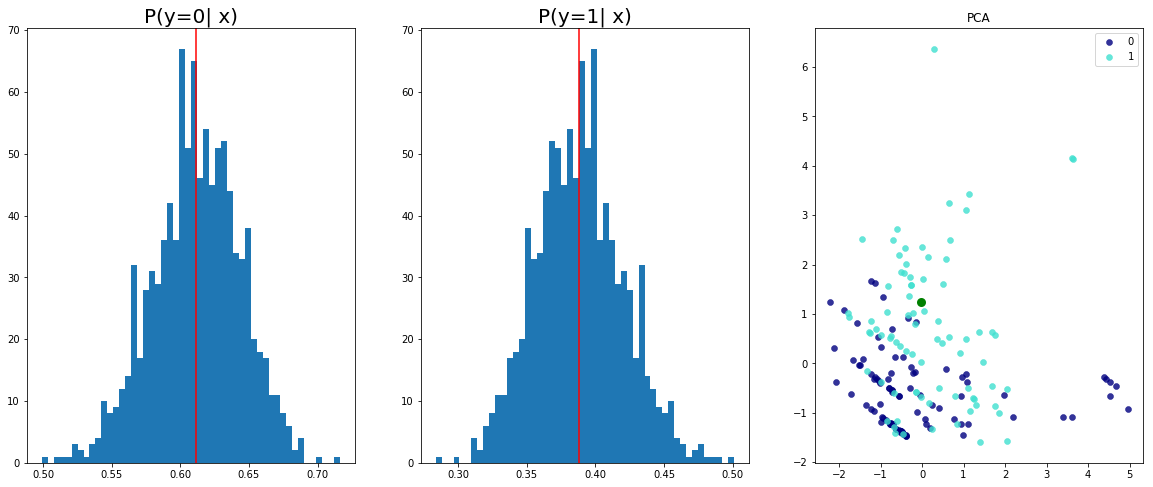

True -> 0
Predicted -> 0
STDS: 0.02872656285762787


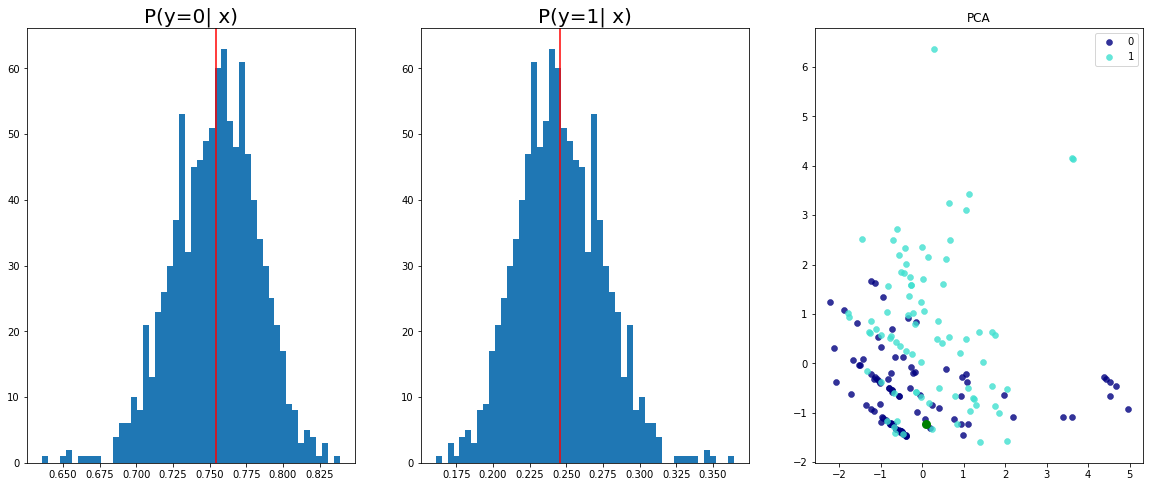

True -> 0
Predicted -> 0
STDS: 0.016933957114815712


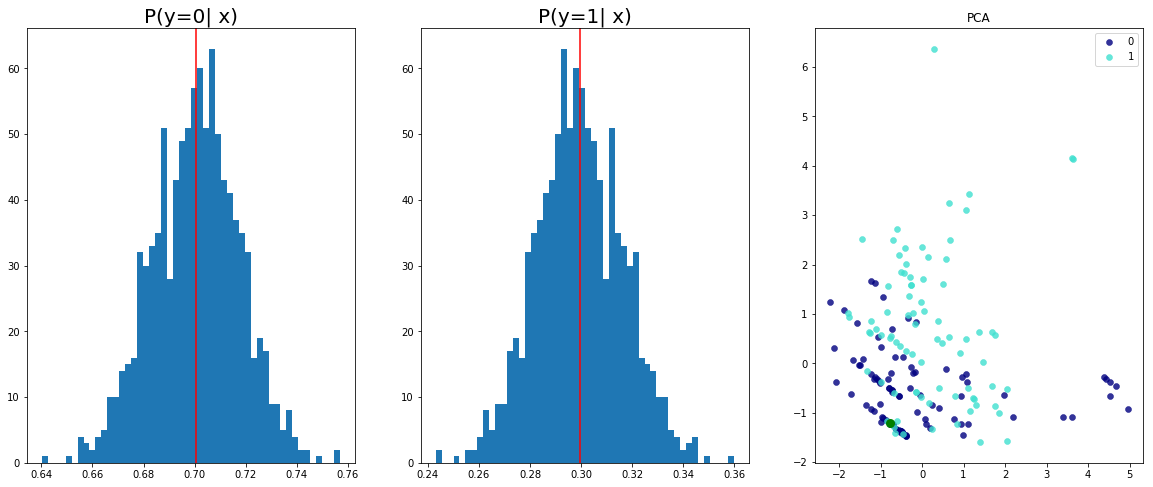

True -> 0
Predicted -> 0
STDS: 0.01941690966486931


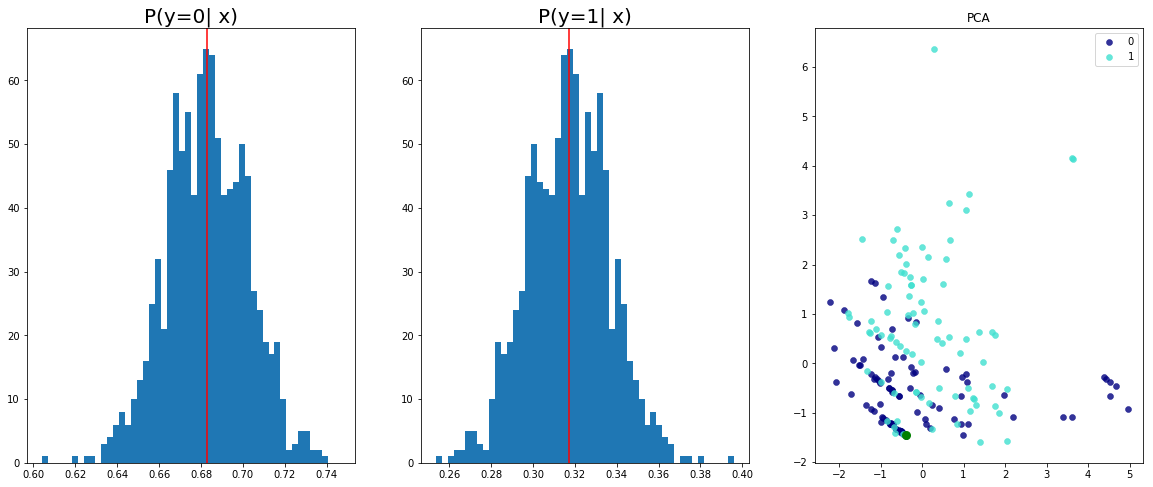

True -> 1
Predicted -> 1
STDS: 0.039869993925094604


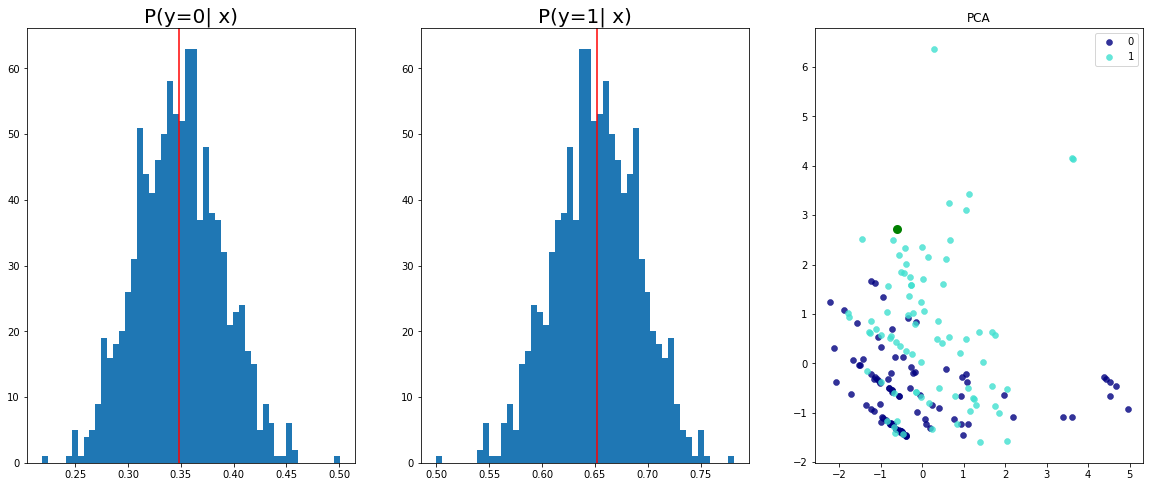

True -> 1
Predicted -> 0
STDS: 0.023250188678503036


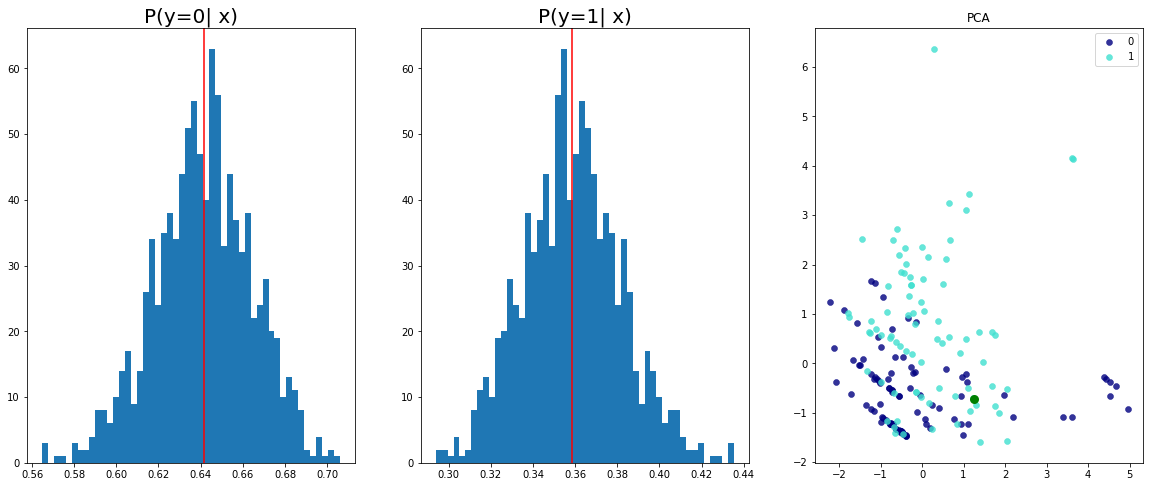

True -> 0
Predicted -> 0
STDS: 0.015321047976613045


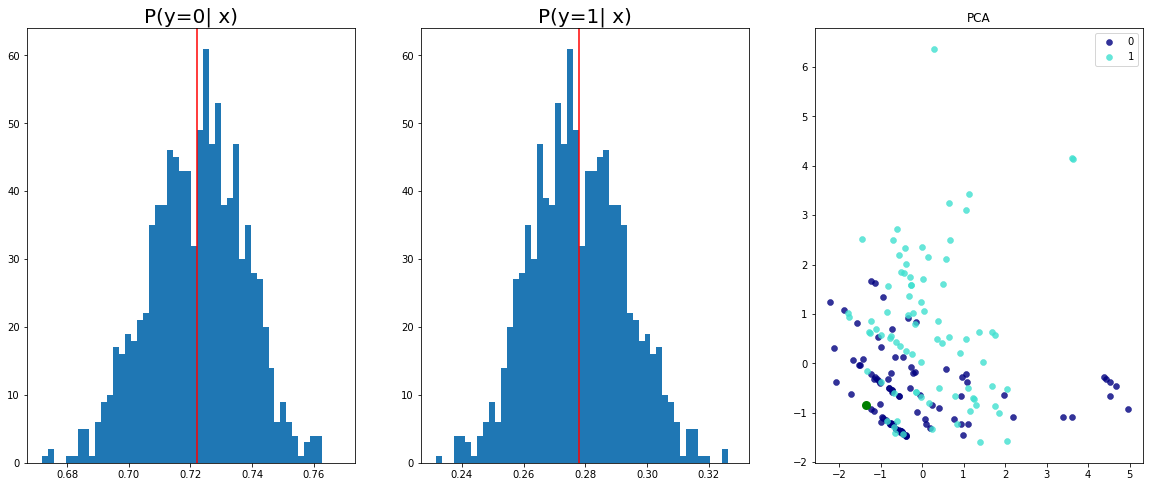

True -> 1
Predicted -> 1
STDS: 0.03148355707526207


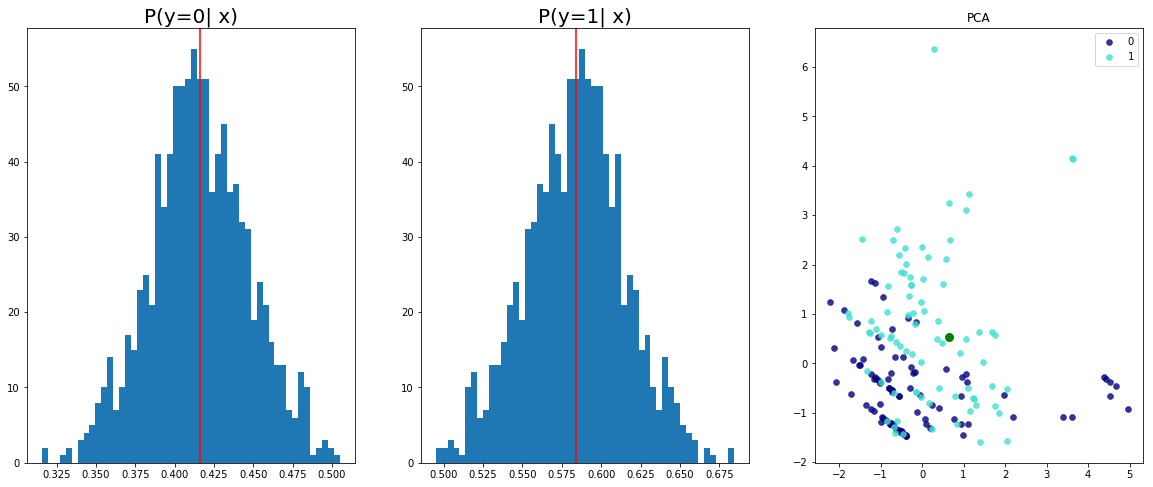

True -> 0
Predicted -> 0
STDS: 0.020971225574612617


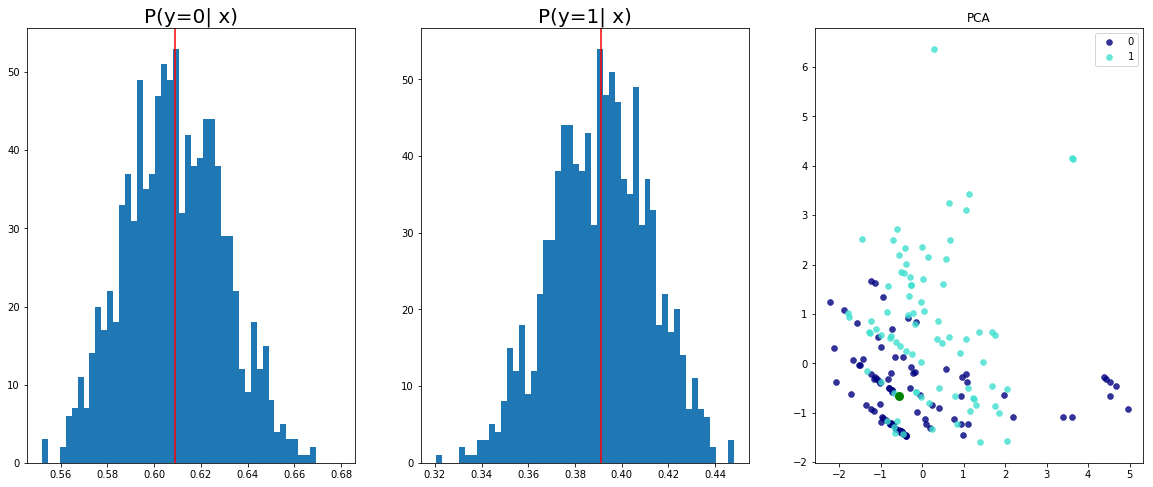

True -> 0
Predicted -> 0
STDS: 0.0199741143733263


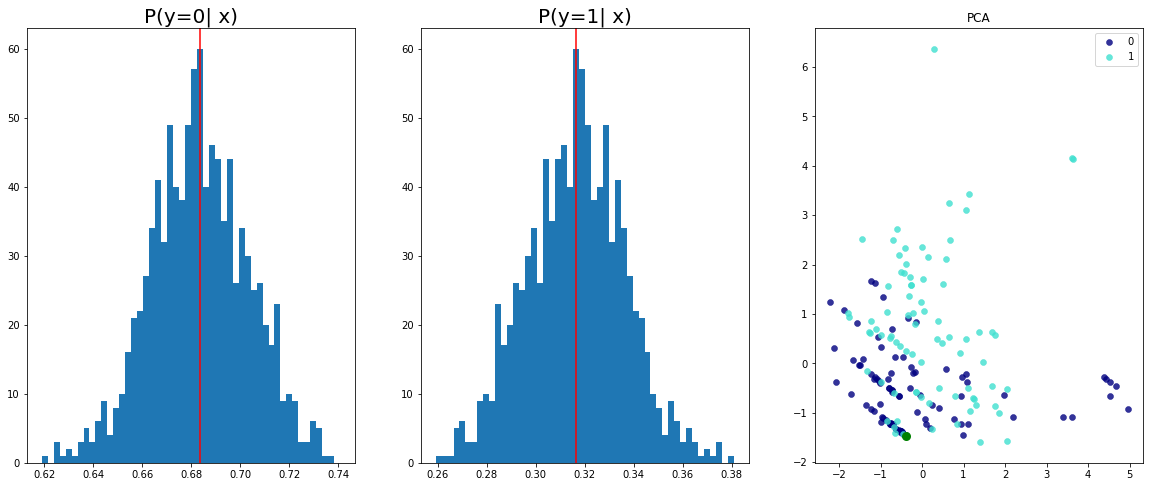

True -> 0
Predicted -> 0
STDS: 0.0164412222802639


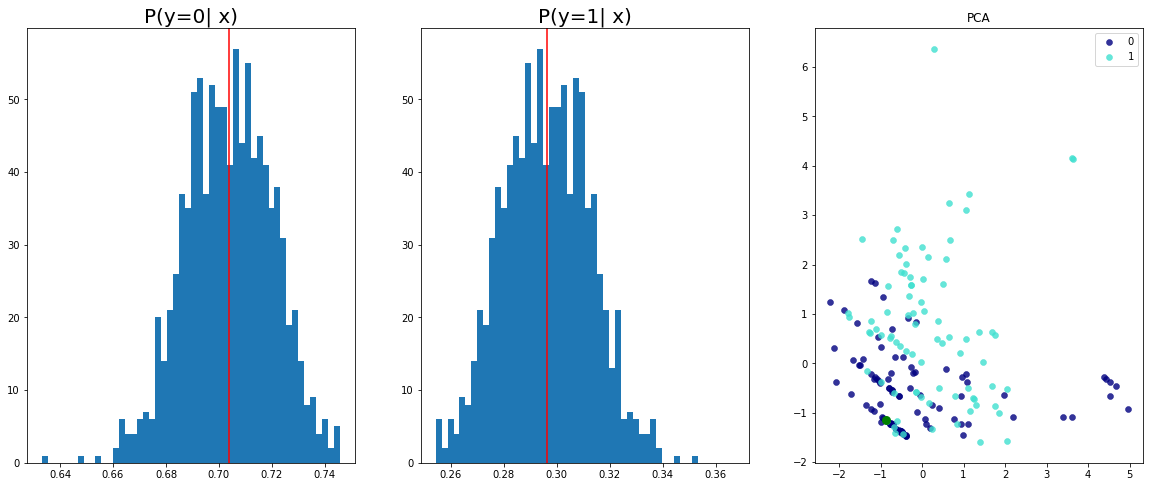

True -> 1
Predicted -> 1
STDS: 0.031931087374687195


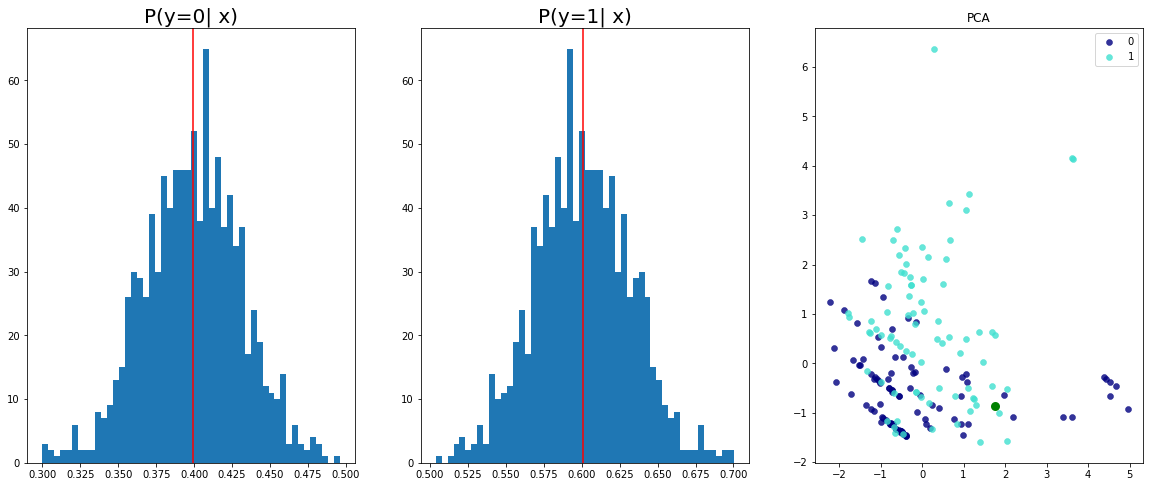

True -> 0
Predicted -> 0
STDS: 0.015139942988753319


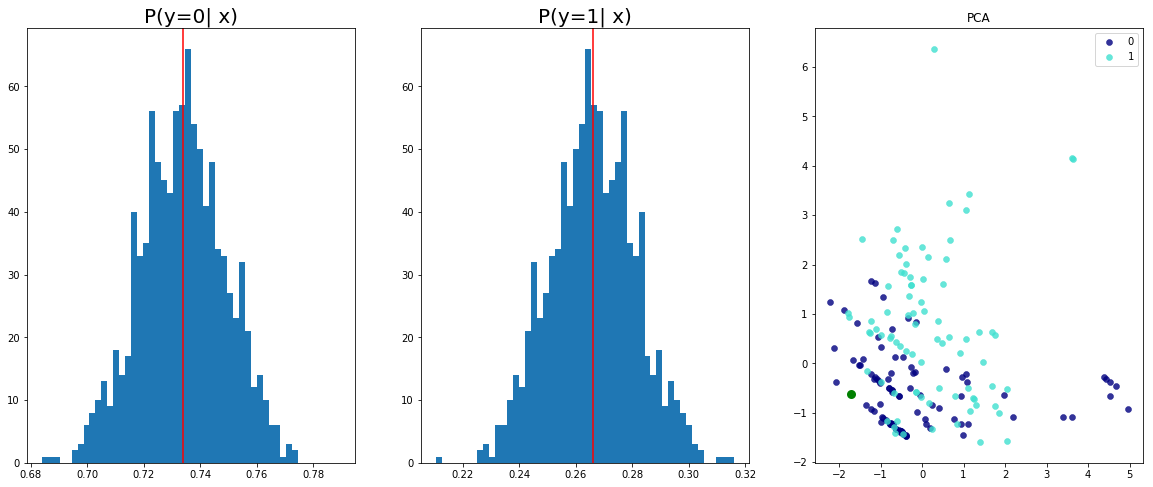

True -> 1
Predicted -> 1
STDS: 0.028518227860331535


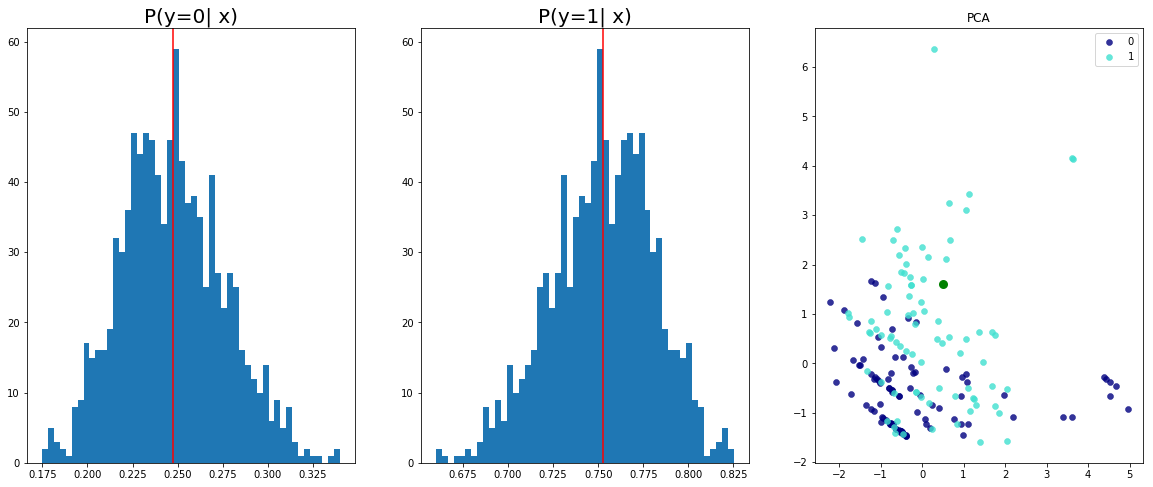

True -> 0
Predicted -> 0
STDS: 0.02974426932632923


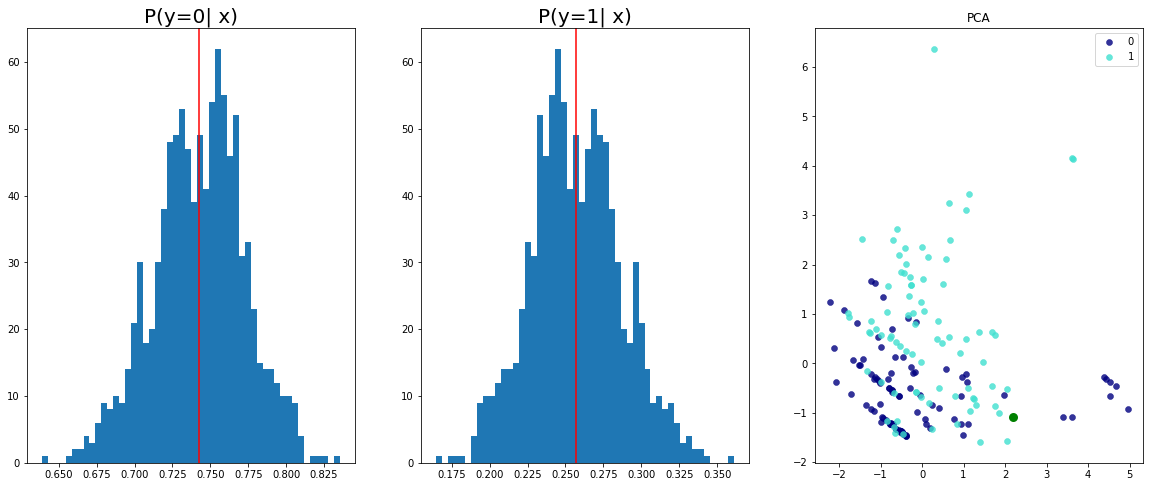

True -> 0
Predicted -> 0
STDS: 0.017581606283783913


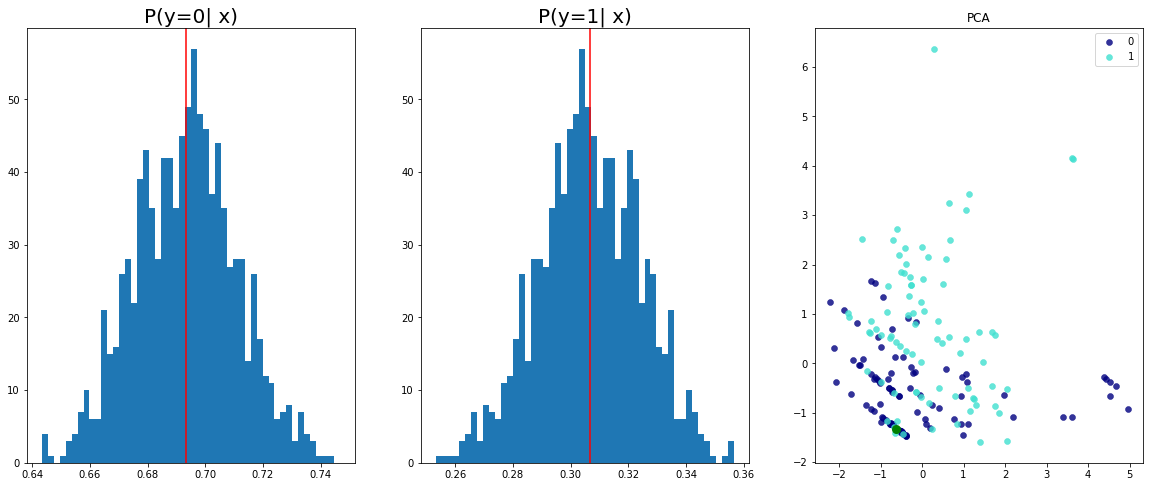

True -> 1
Predicted -> 0
STDS: 0.017002835869789124


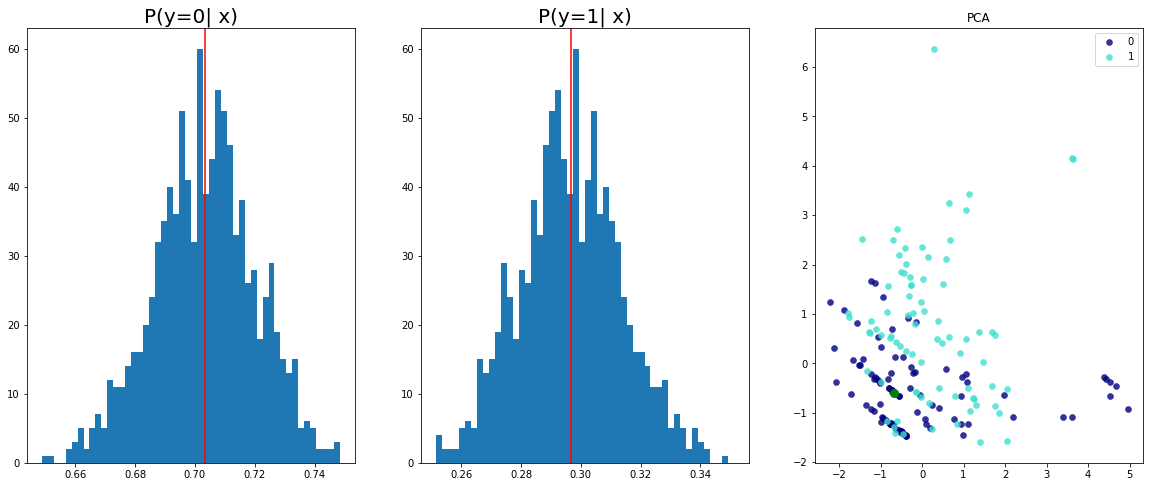

True -> 0
Predicted -> 0
STDS: 0.018601225689053535


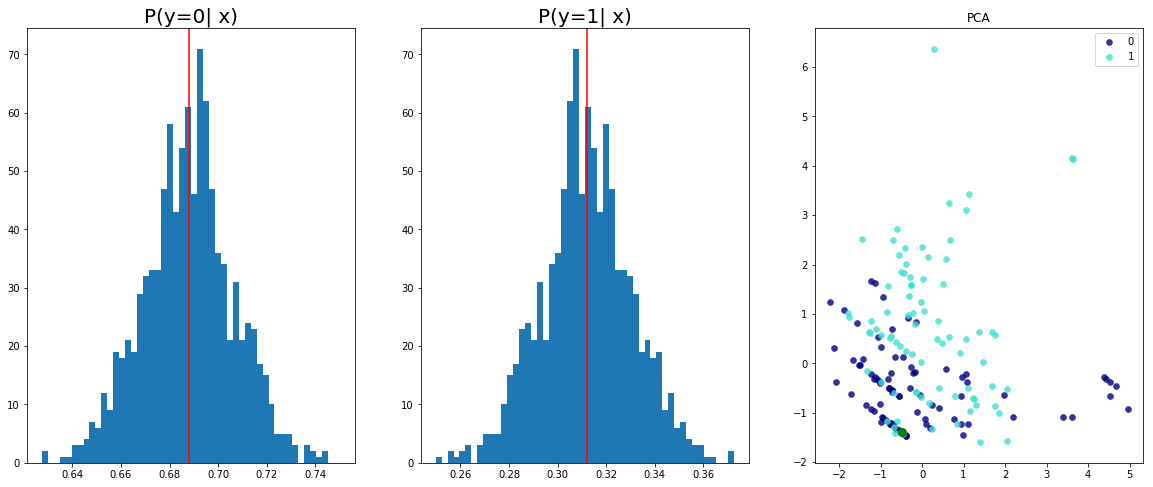

True -> 0
Predicted -> 0
STDS: 0.036232274025678635


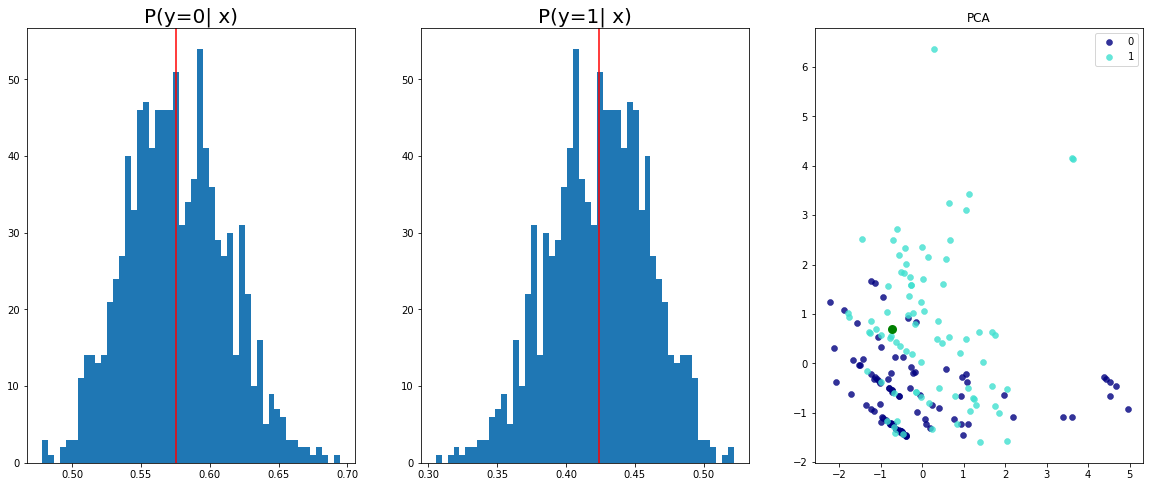

True -> 1
Predicted -> 1
STDS: 0.03905028477311134


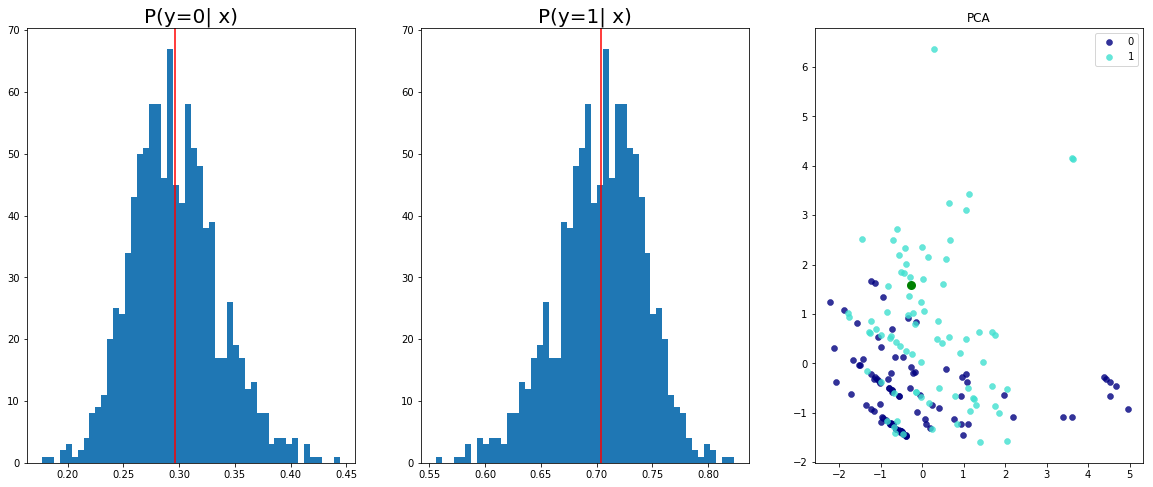

True -> 1
Predicted -> 1
STDS: 0.02608180046081543


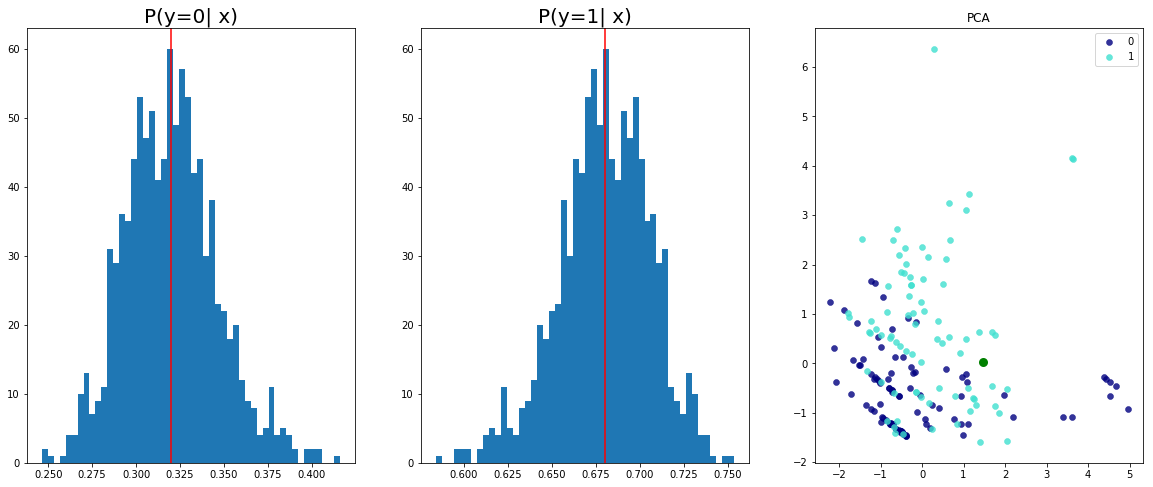

True -> 0
Predicted -> 0
STDS: 0.022592253983020782


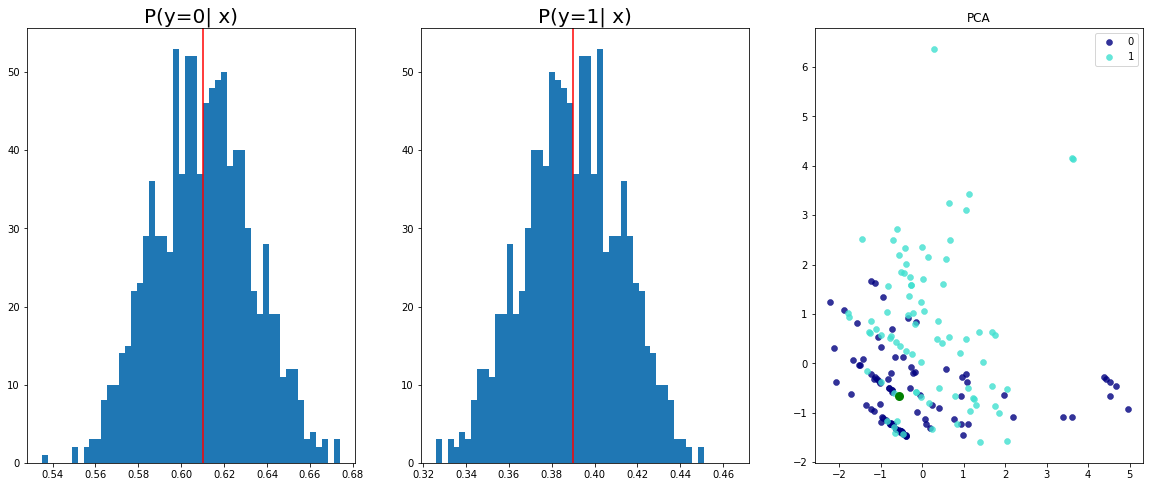

True -> 1
Predicted -> 0
STDS: 0.038083989173173904


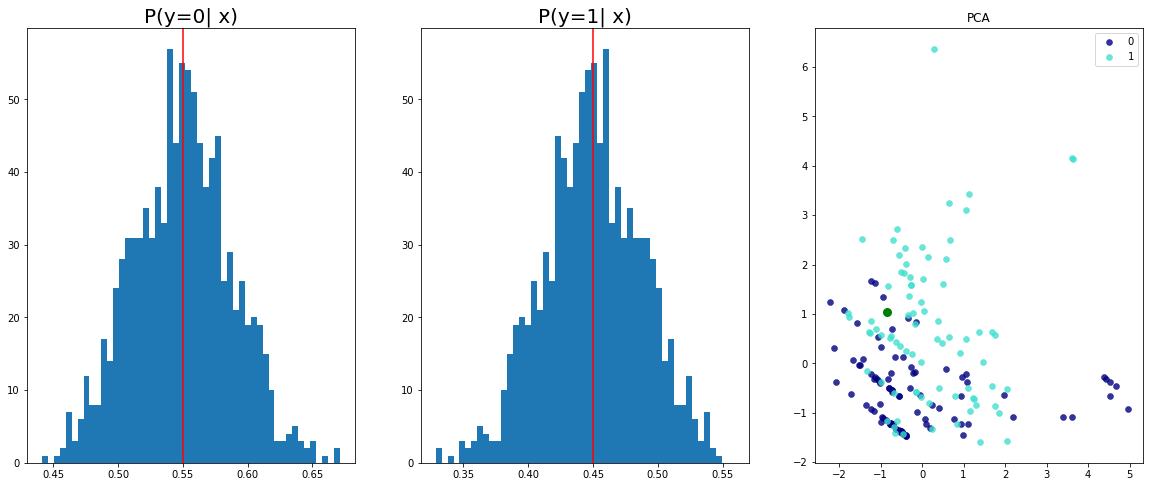

True -> 0
Predicted -> 0
STDS: 0.016964411363005638


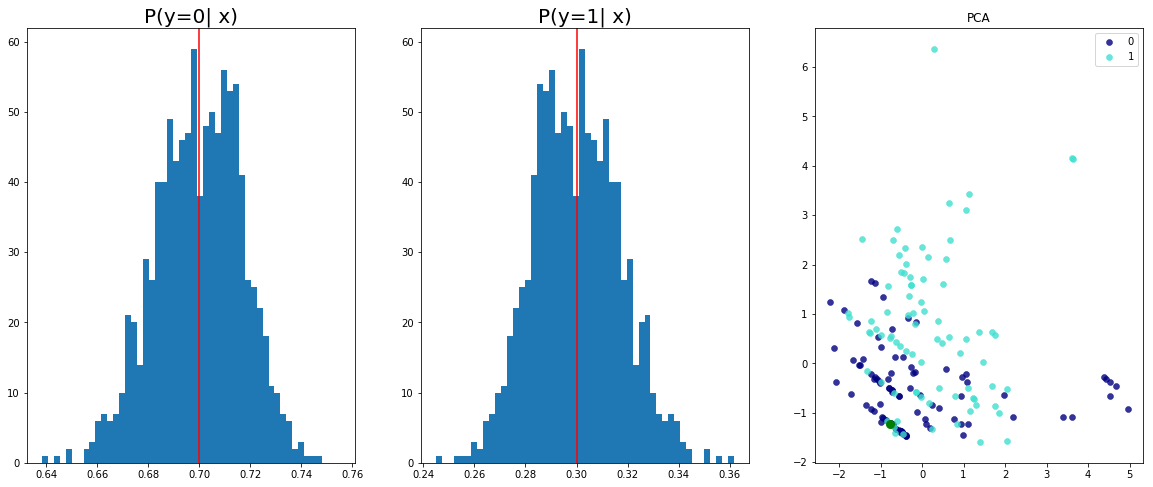

True -> 1
Predicted -> 1
STDS: 0.03963962569832802


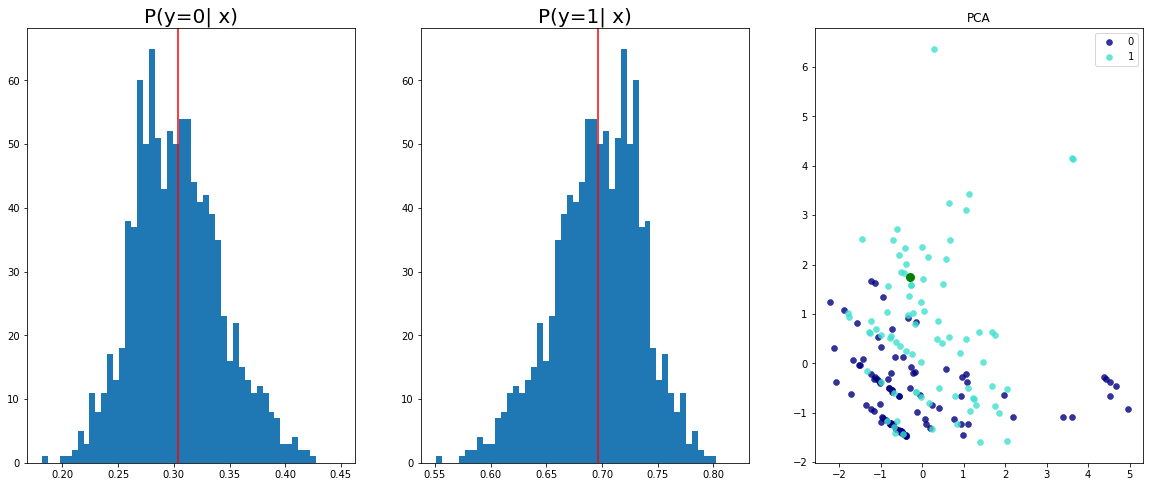

True -> 0
Predicted -> 1
STDS: 0.032948948442935944


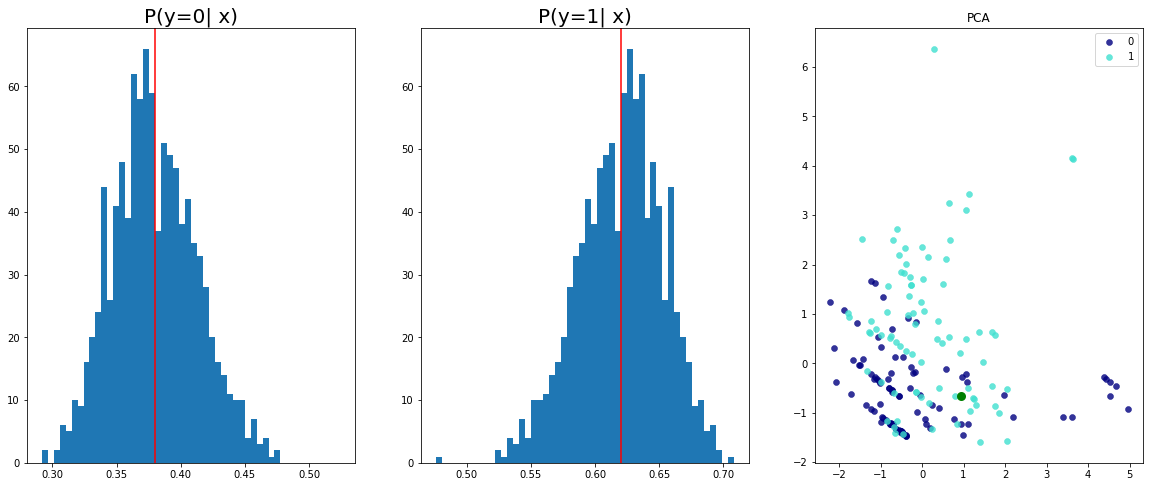

True -> 1
Predicted -> 0
STDS: 0.018566856160759926


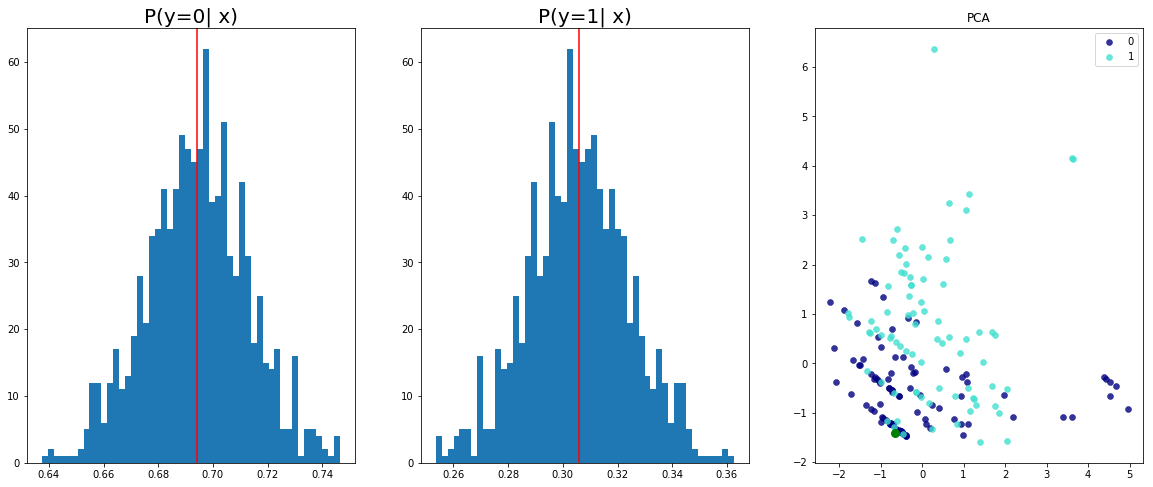

True -> 0
Predicted -> 0
STDS: 0.01742241159081459


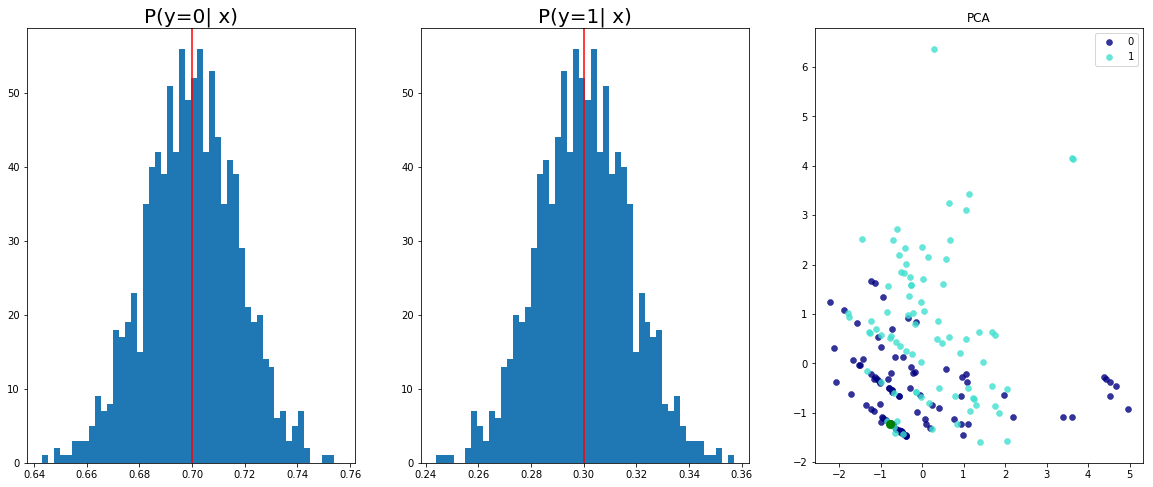

True -> 0
Predicted -> 0
STDS: 0.021221937611699104


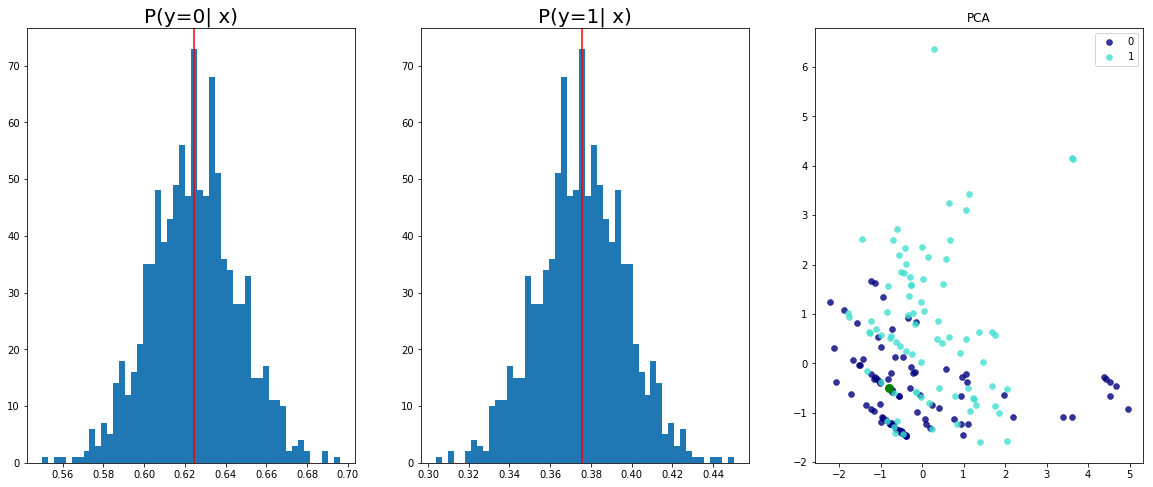

True -> 1
Predicted -> 0
STDS: 0.028345245867967606


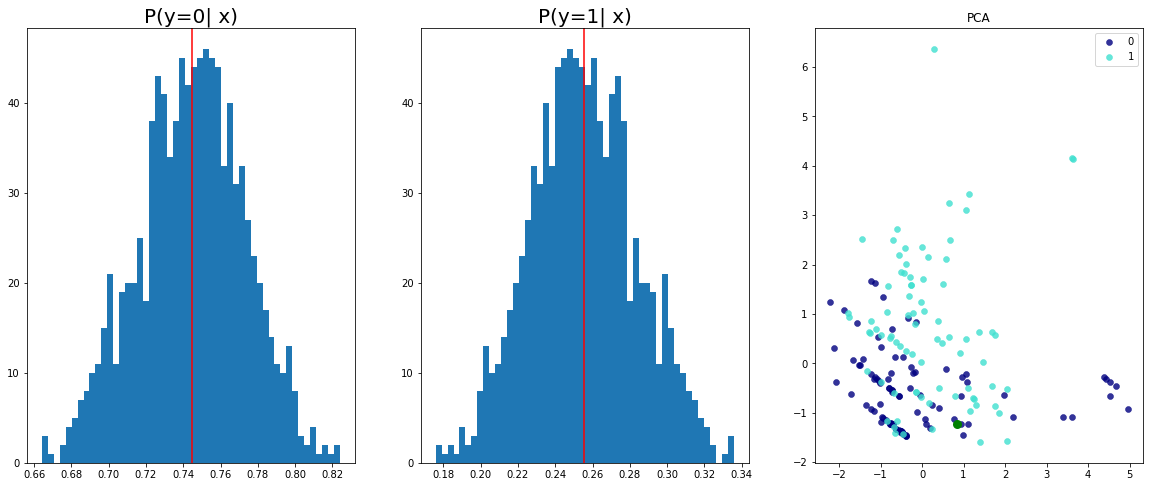

True -> 1
Predicted -> 1
STDS: 0.02964959479868412


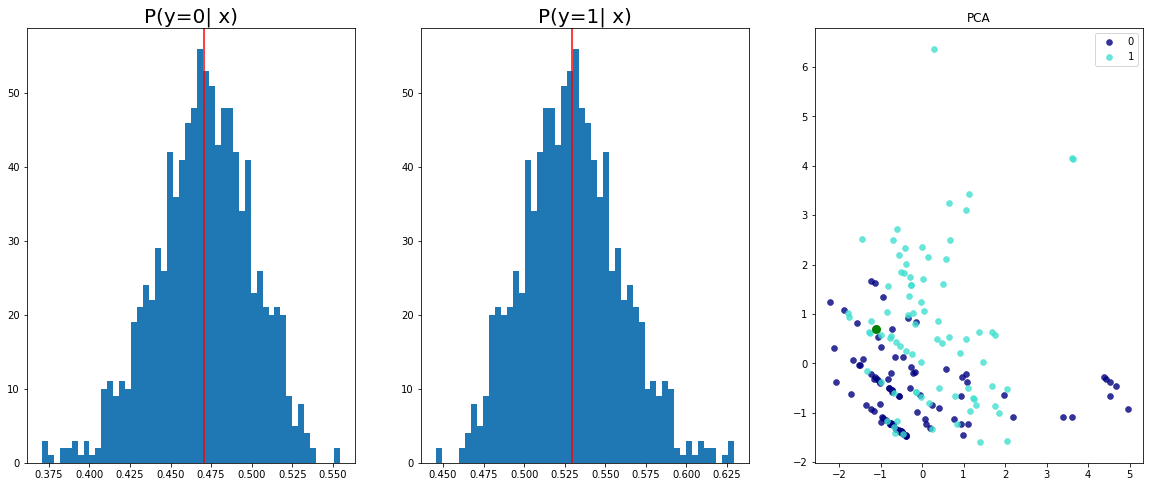

True -> 1
Predicted -> 1
STDS: 0.03439640626311302


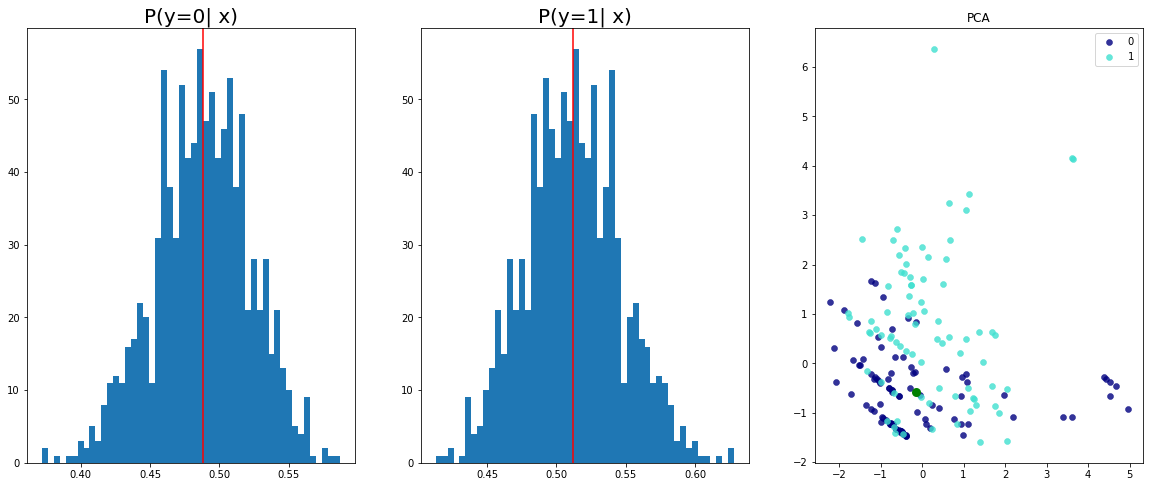

True -> 1
Predicted -> 1
STDS: 0.03313479945063591


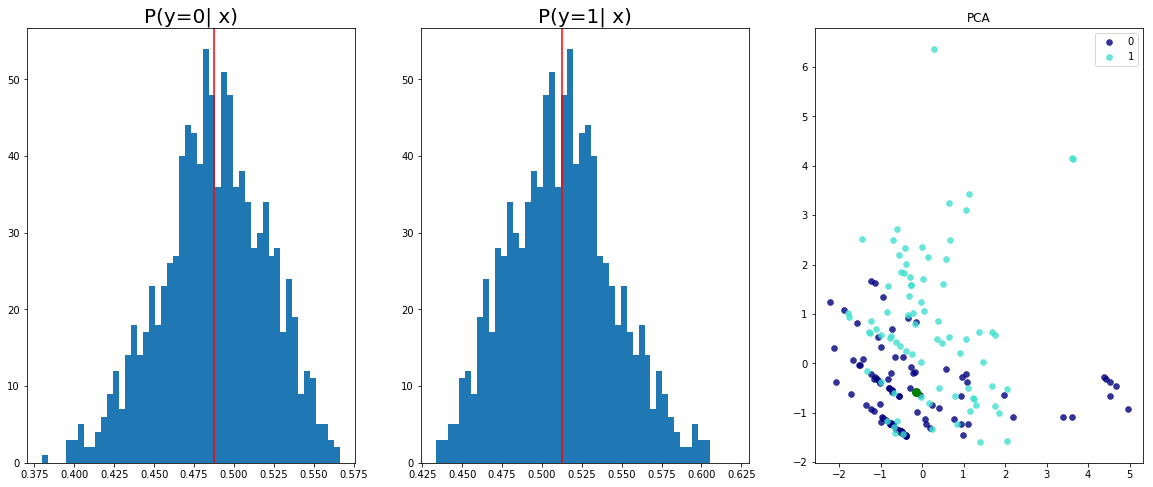

True -> 0
Predicted -> 0
STDS: 0.019691281020641327


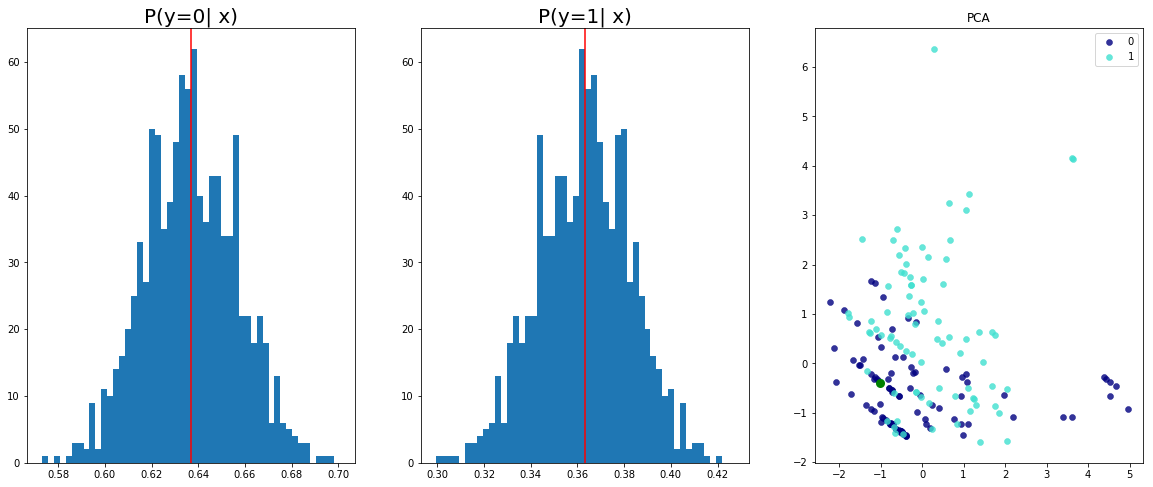

True -> 0
Predicted -> 0
STDS: 0.01905837096273899


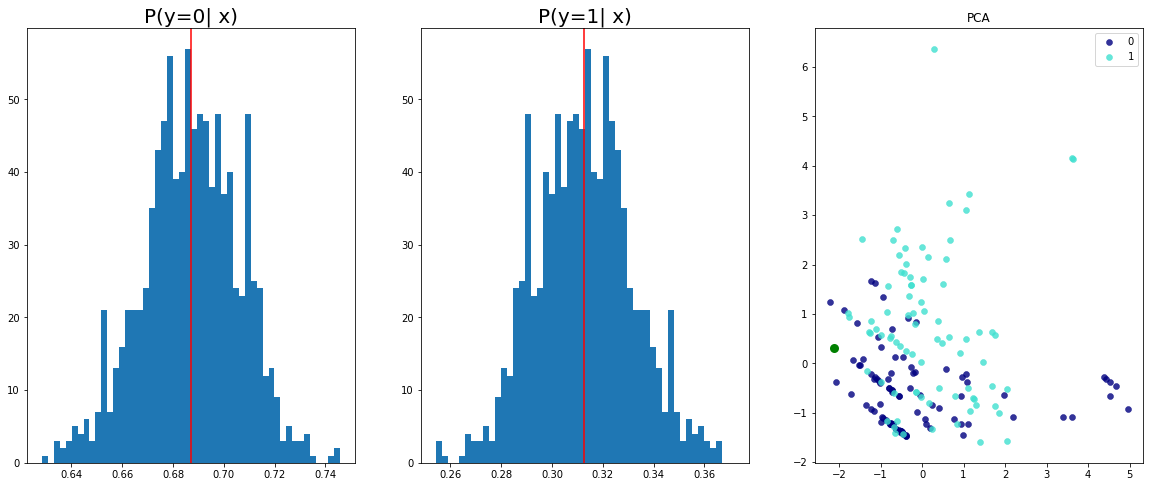

True -> 0
Predicted -> 0
STDS: 0.018029754981398582


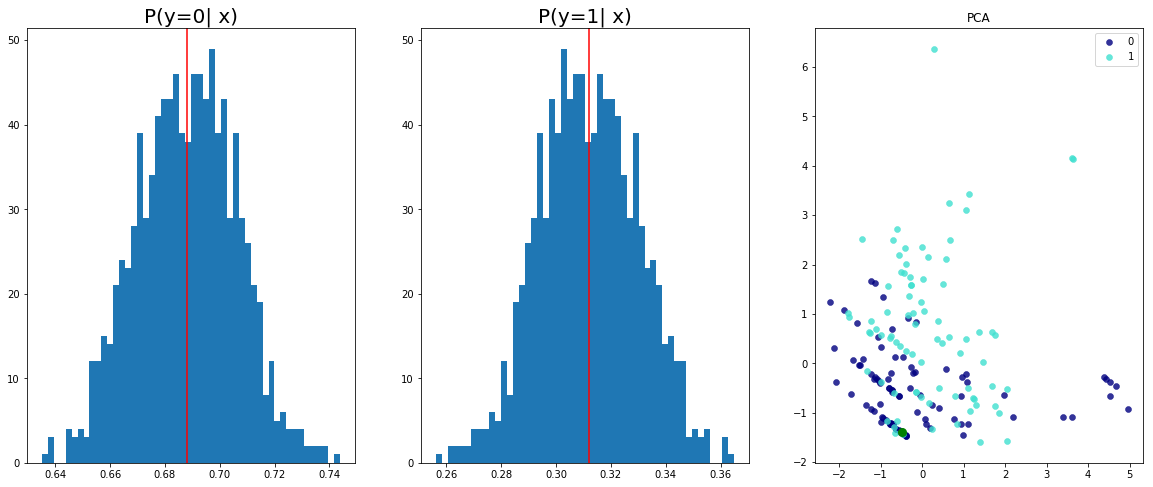

True -> 0
Predicted -> 0
STDS: 0.01809293031692505


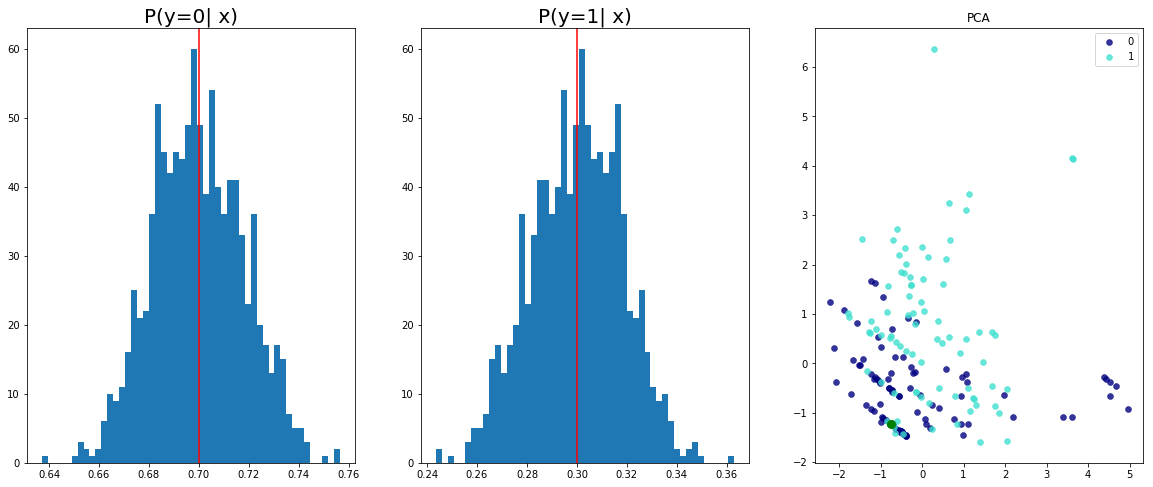

True -> 0
Predicted -> 0
STDS: 0.017842302098870277


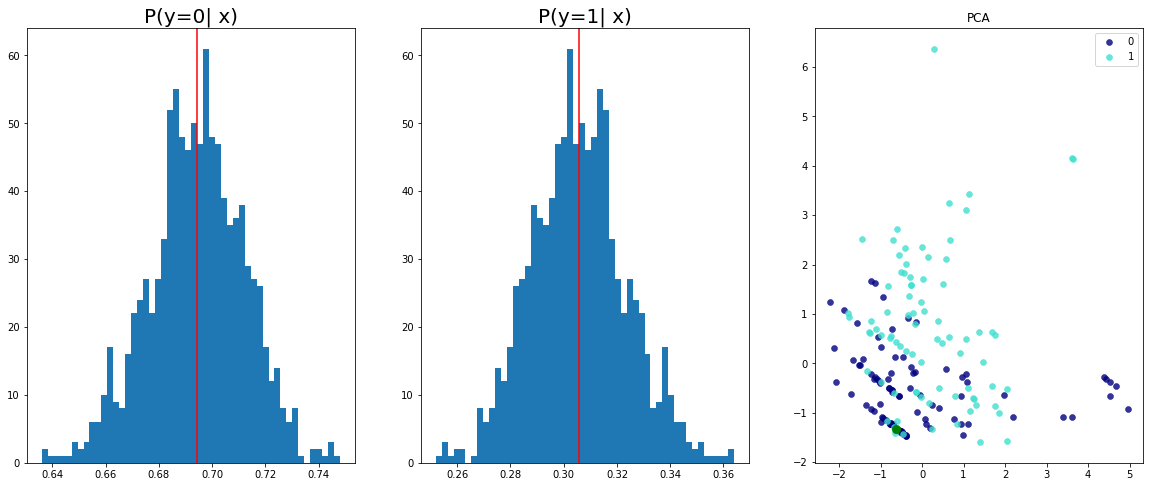

True -> 1
Predicted -> 0
STDS: 0.016906119883060455


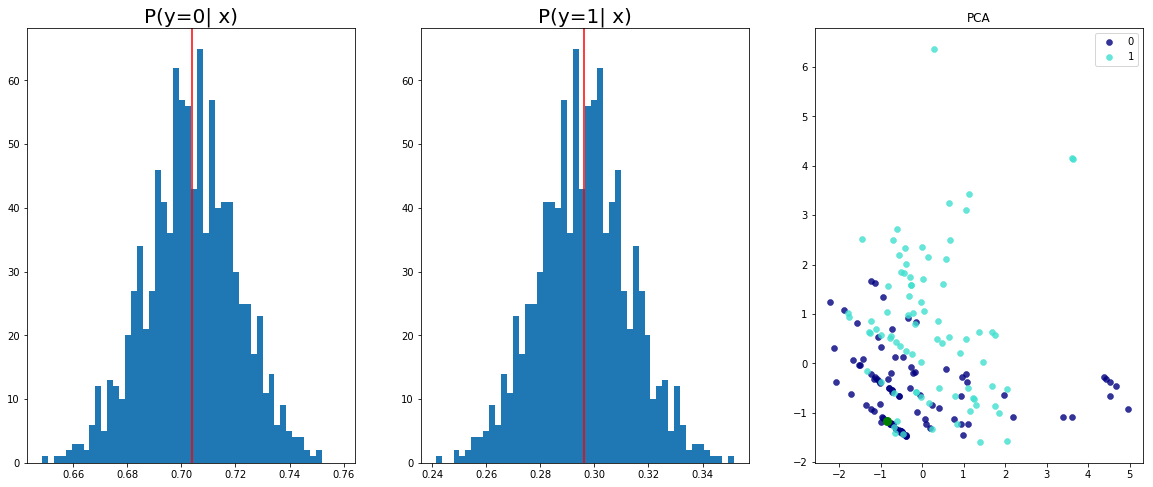

True -> 0
Predicted -> 0
STDS: 0.026290763169527054


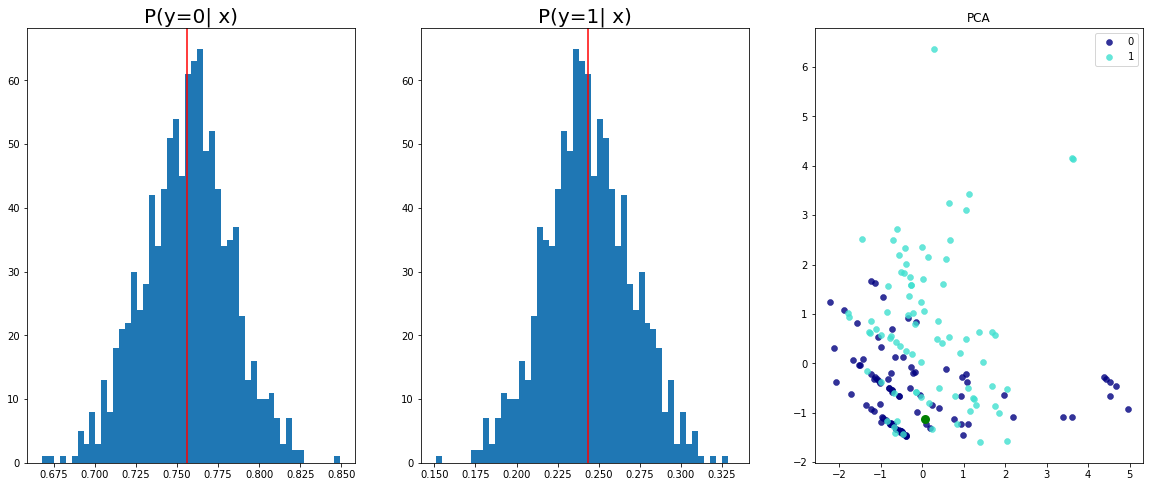

True -> 1
Predicted -> 0
STDS: 0.01916678436100483


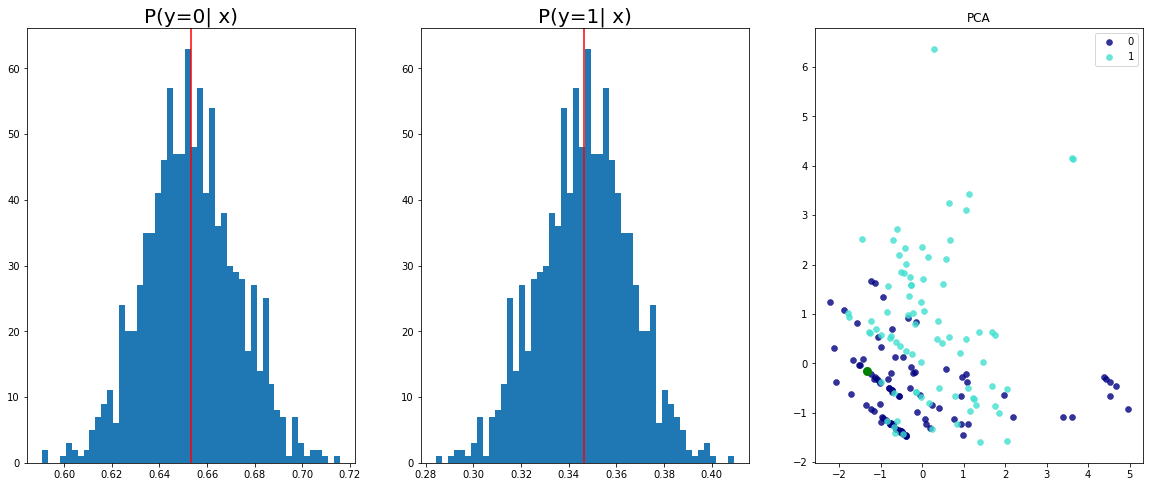

True -> 0
Predicted -> 0
STDS: 0.019682828336954117


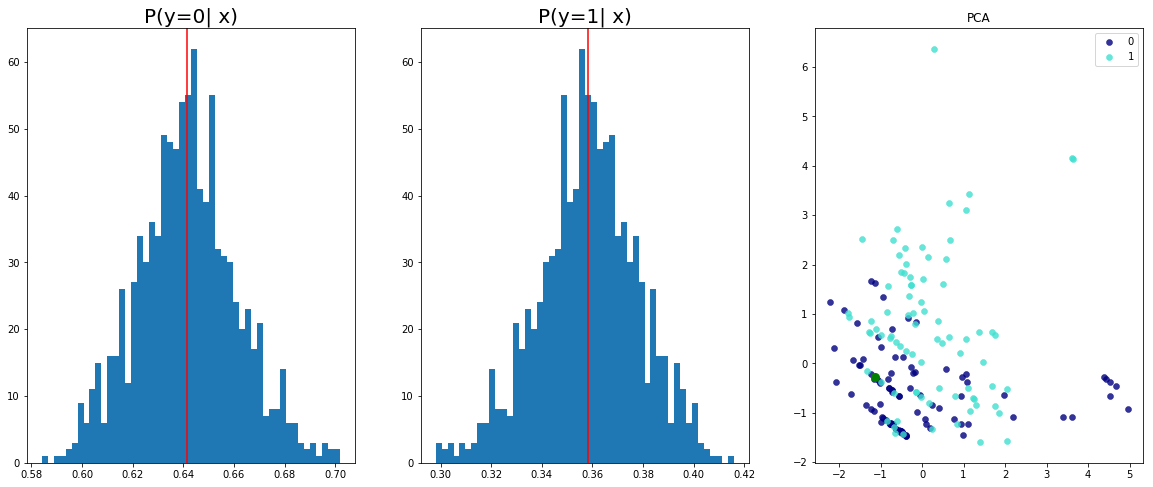

True -> 1
Predicted -> 1
STDS: 0.02121332474052906


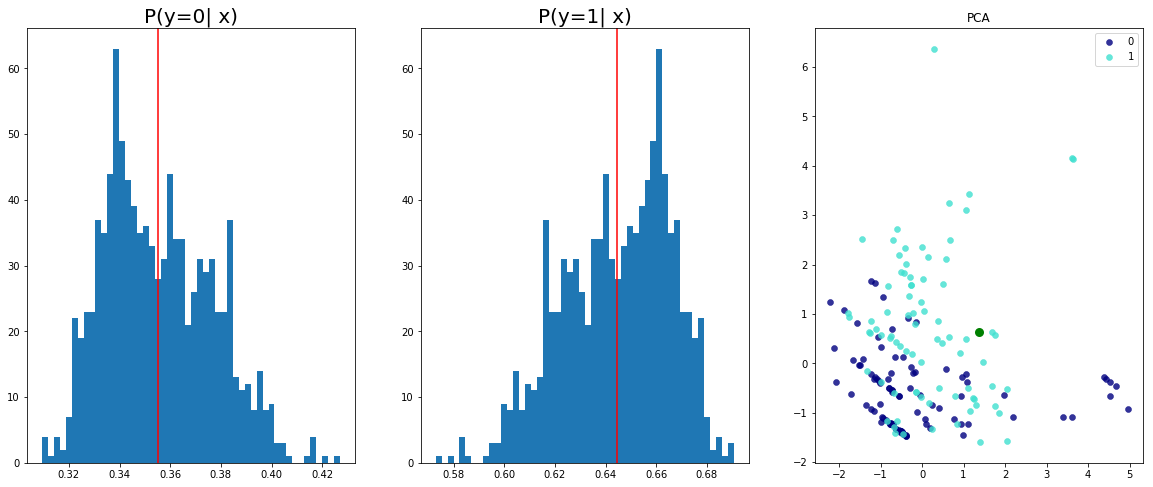

True -> 1
Predicted -> 1
STDS: 0.019656313583254814


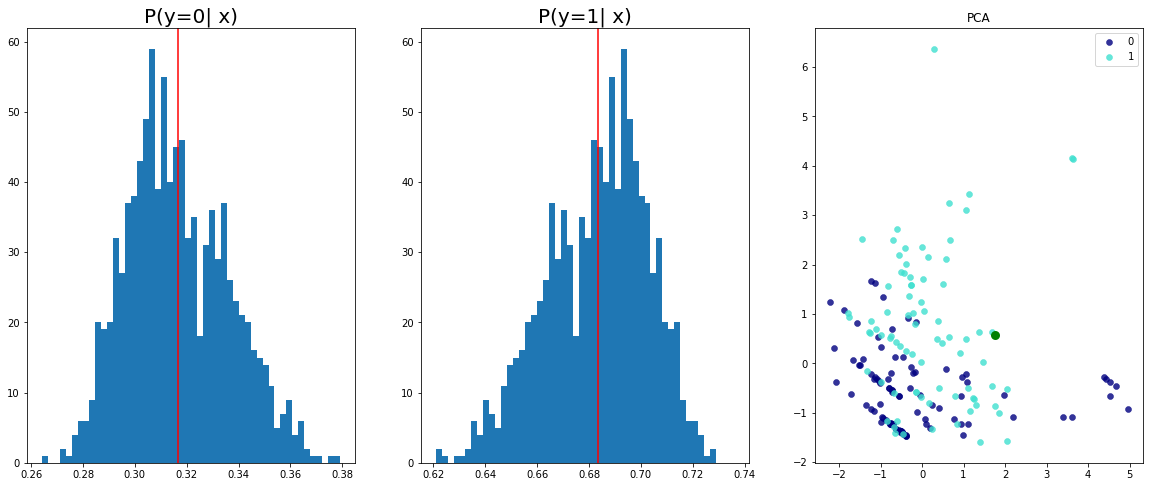

True -> 1
Predicted -> 0
STDS: 0.0332825668156147


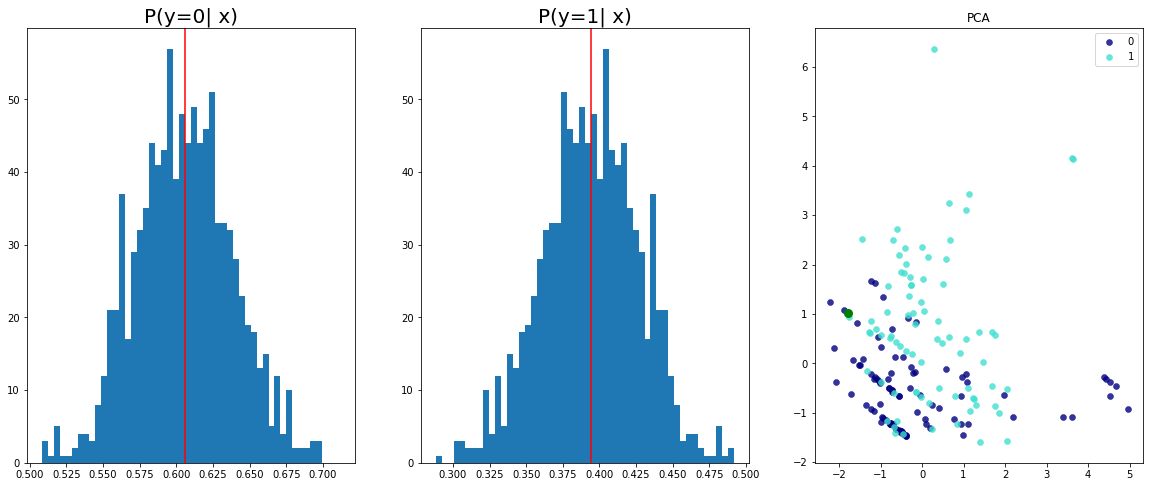

True -> 0
Predicted -> 0
STDS: 0.04172617197036743


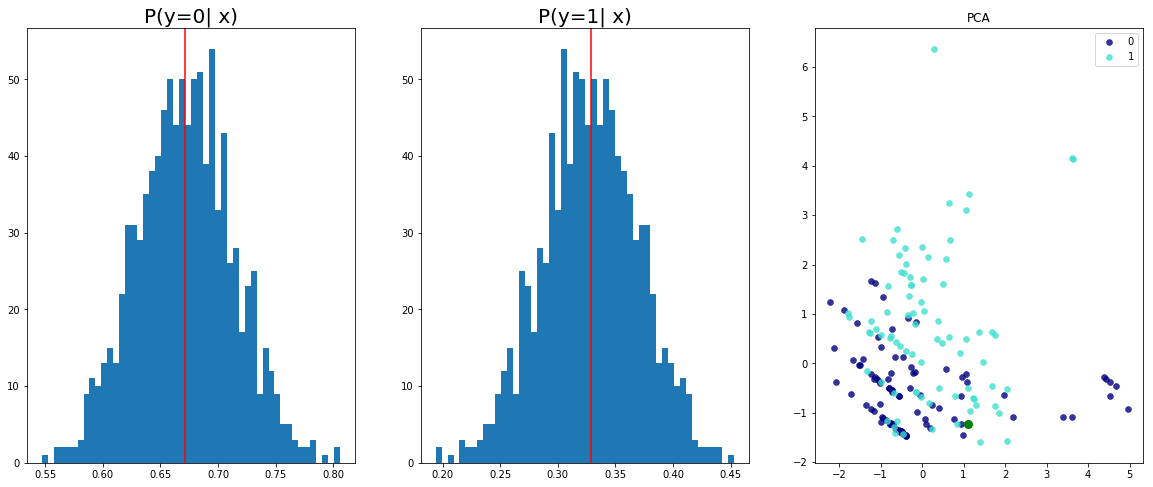

True -> 1
Predicted -> 1
STDS: 0.030152704566717148


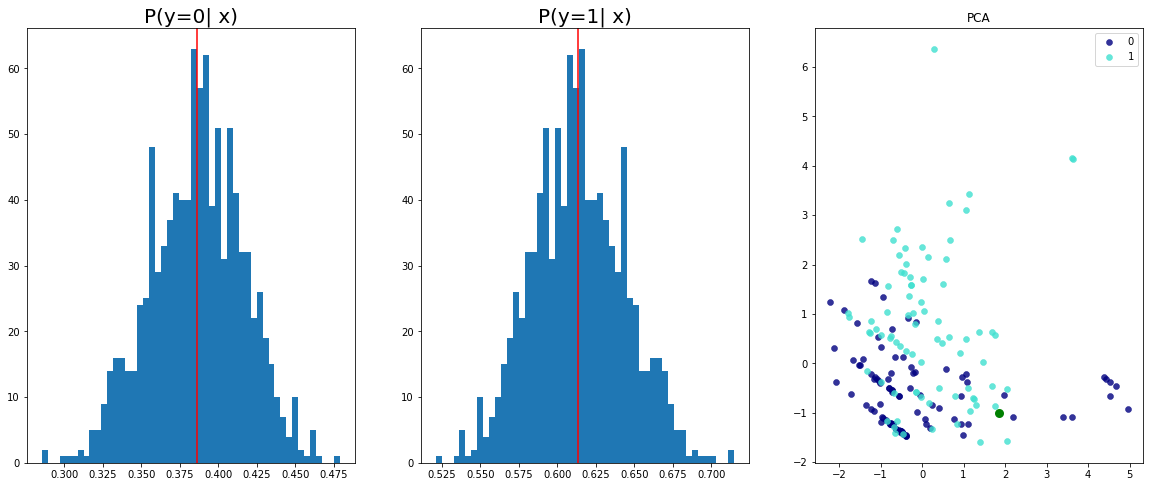

True -> 1
Predicted -> 1
STDS: 0.038629475980997086


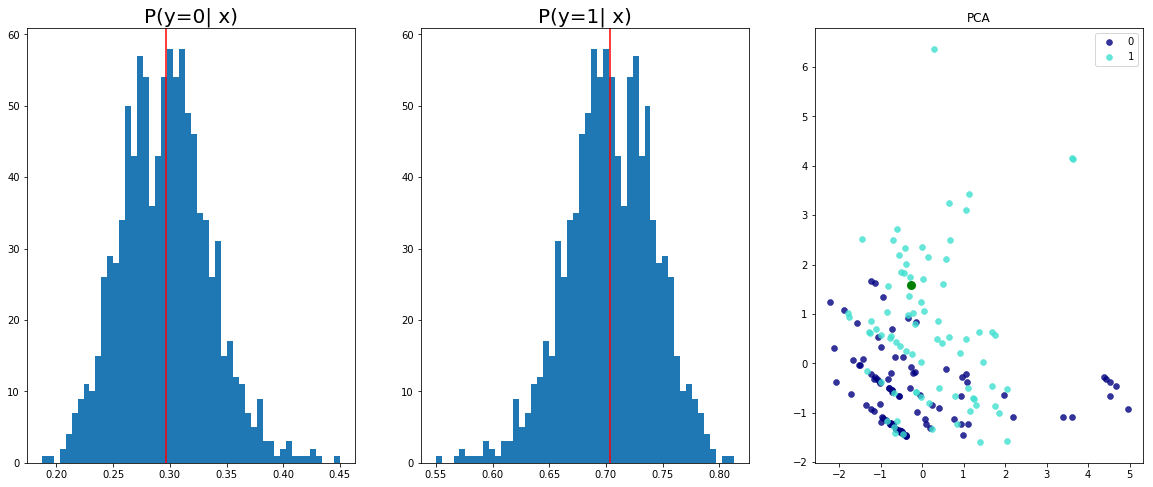

True -> 0
Predicted -> 0
STDS: 0.027035705745220184


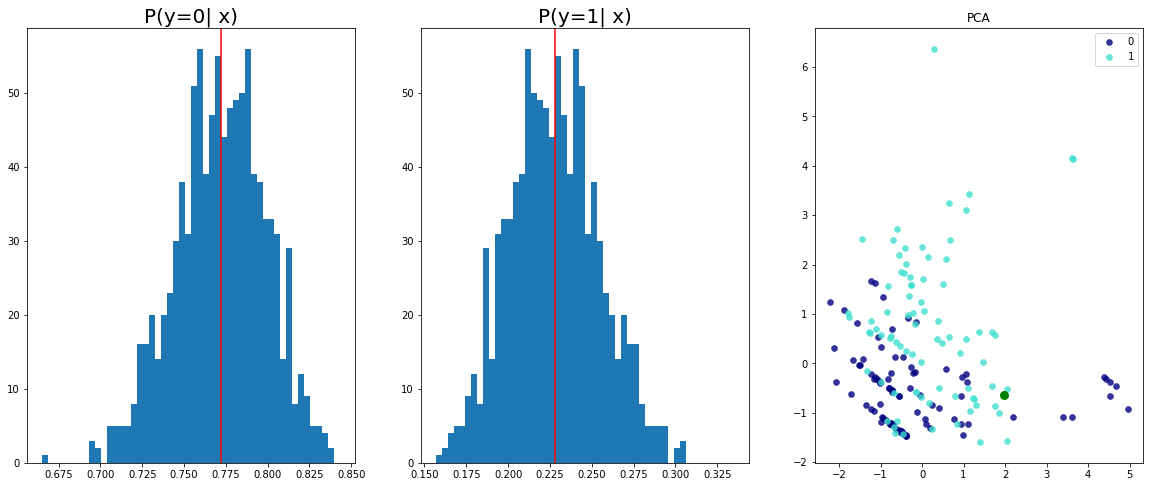

True -> 1
Predicted -> 0
STDS: 0.028049662709236145


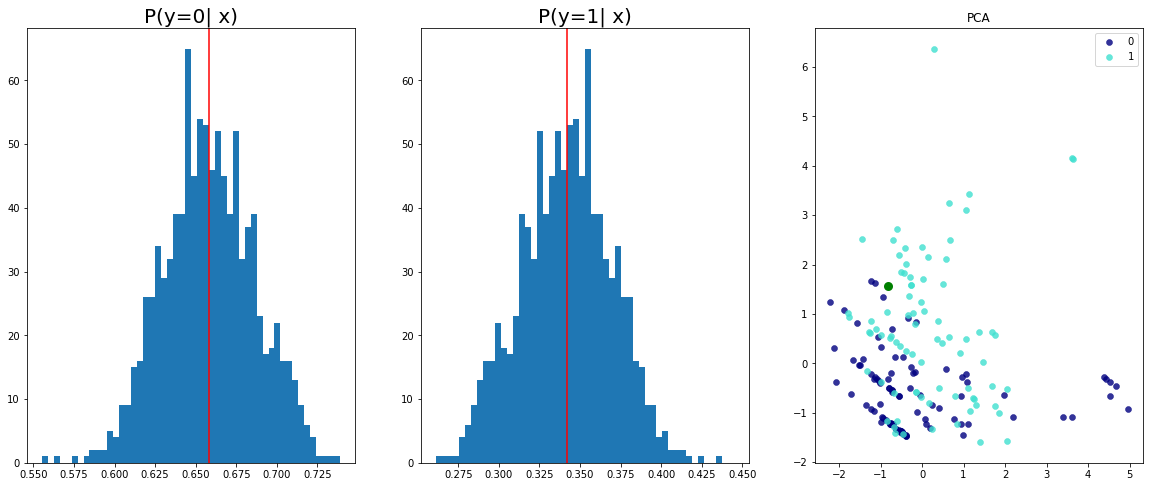

True -> 0
Predicted -> 0
STDS: 0.01901490055024624


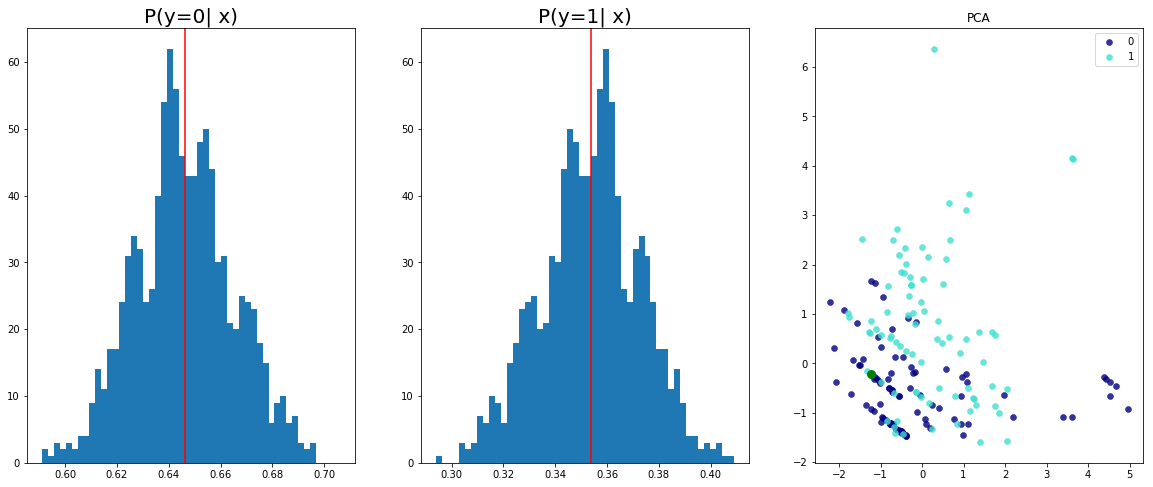

True -> 1
Predicted -> 1
STDS: 0.02693963423371315


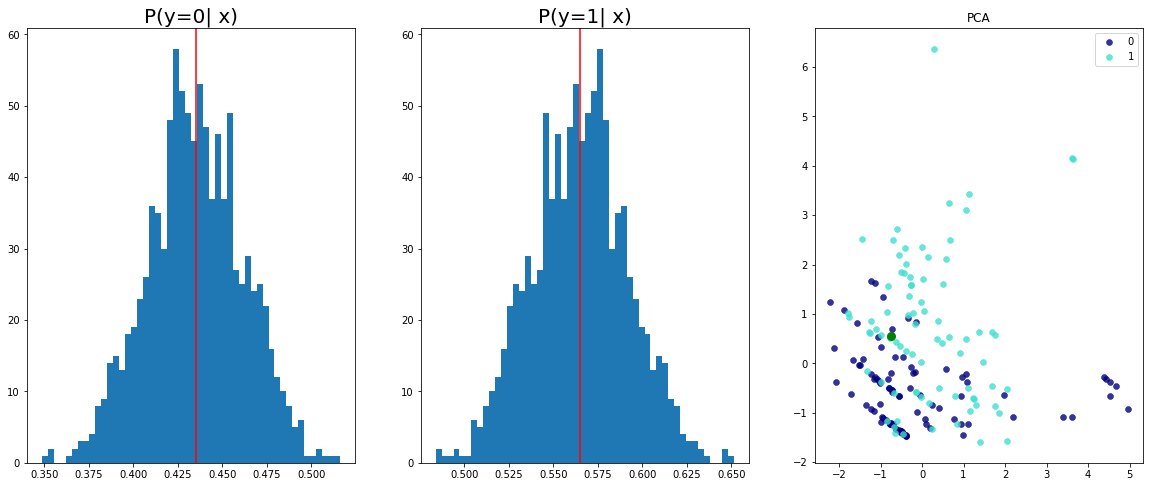

True -> 1
Predicted -> 0
STDS: 0.024797791615128517


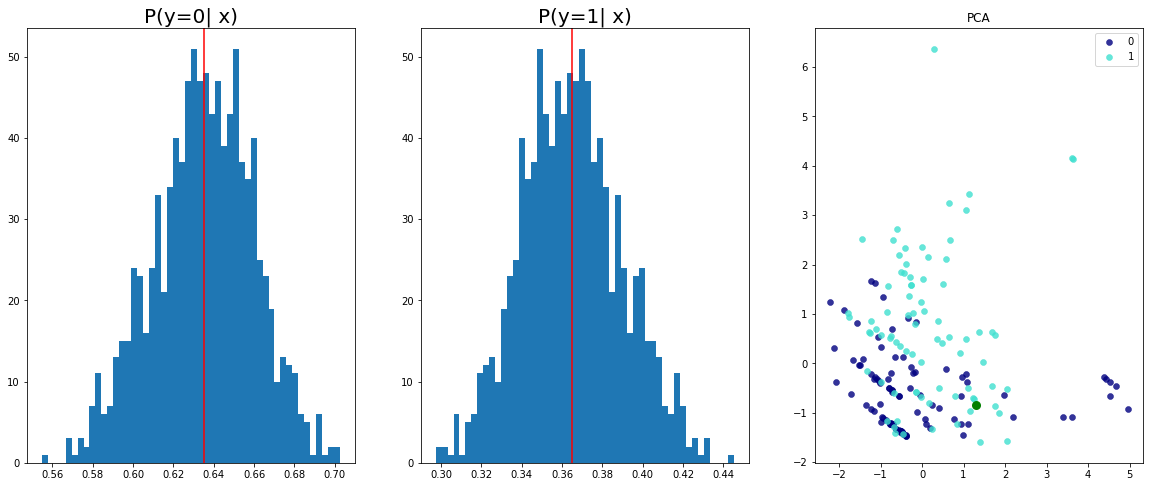

True -> 0
Predicted -> 0
STDS: 0.048753418028354645


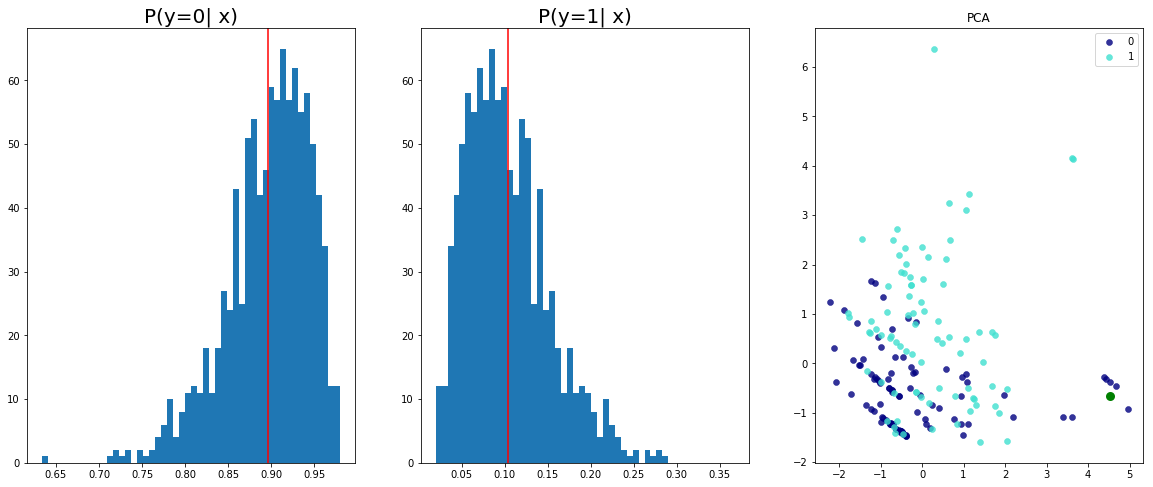

True -> 0
Predicted -> 0
STDS: 0.022211827337741852


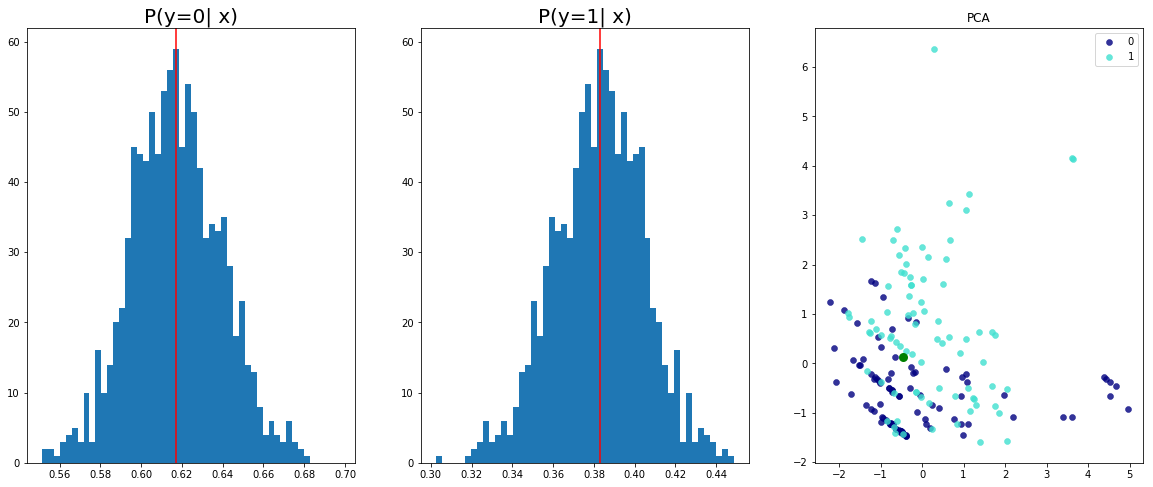

True -> 1
Predicted -> 1
STDS: 0.03925161063671112


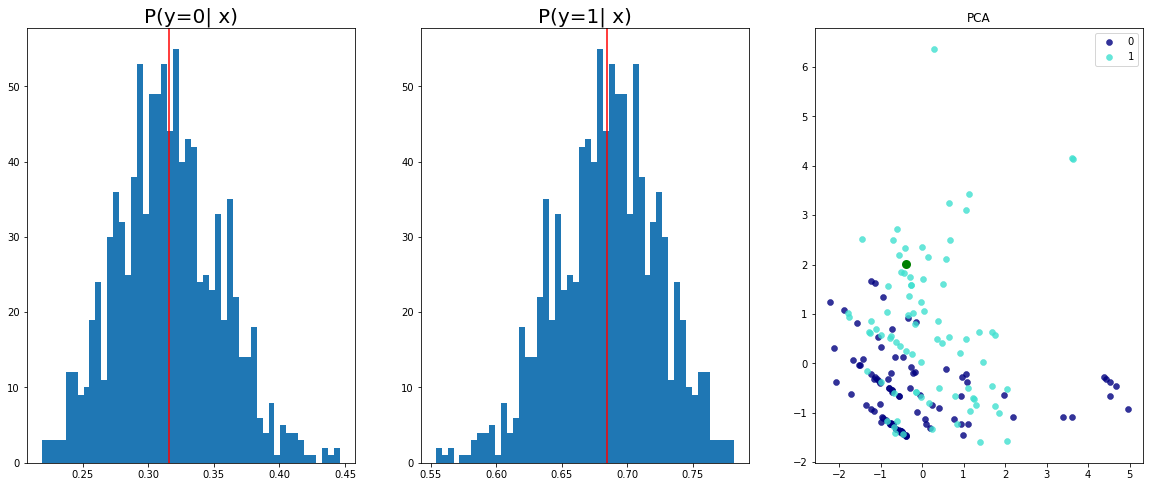

True -> 1
Predicted -> 1
STDS: 0.029920591041445732


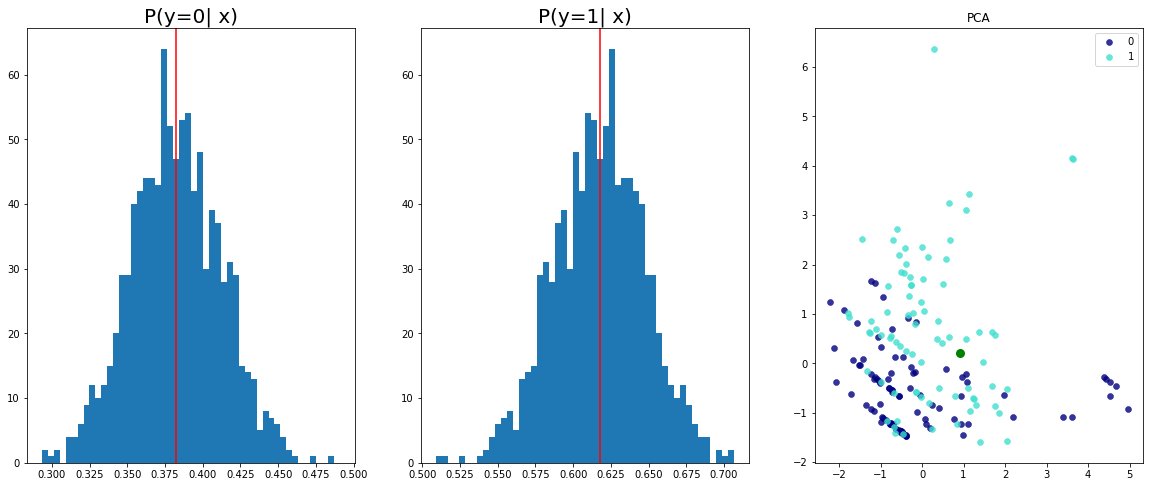

True -> 1
Predicted -> 1
STDS: 0.0336184948682785


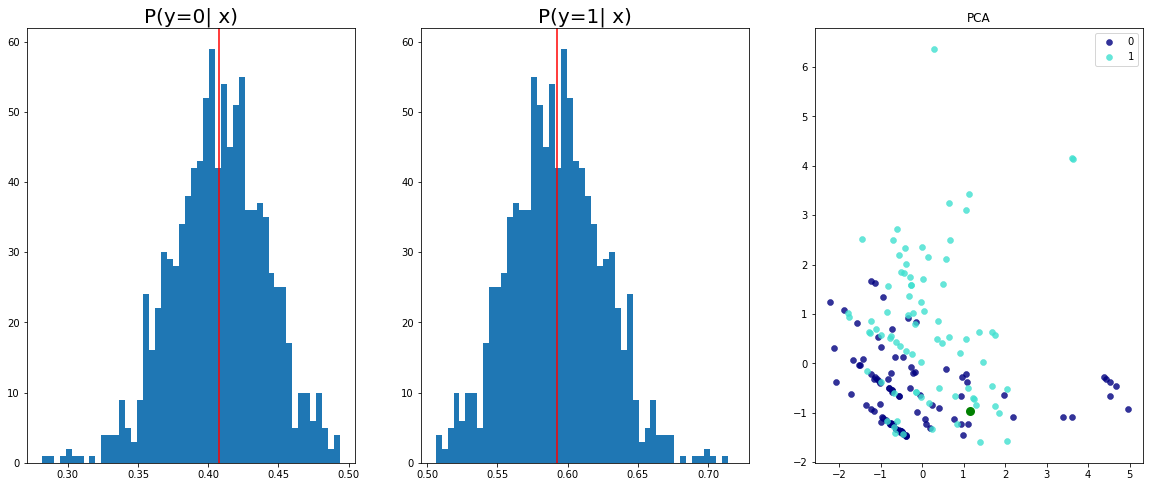

True -> 0
Predicted -> 0
STDS: 0.01838734559714794


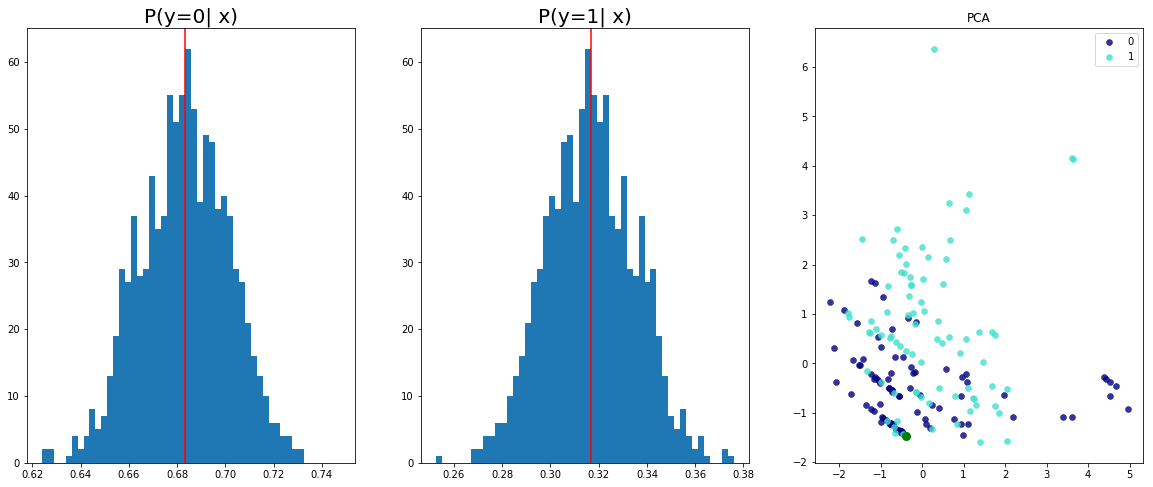

True -> 0
Predicted -> 0
STDS: 0.032096847891807556


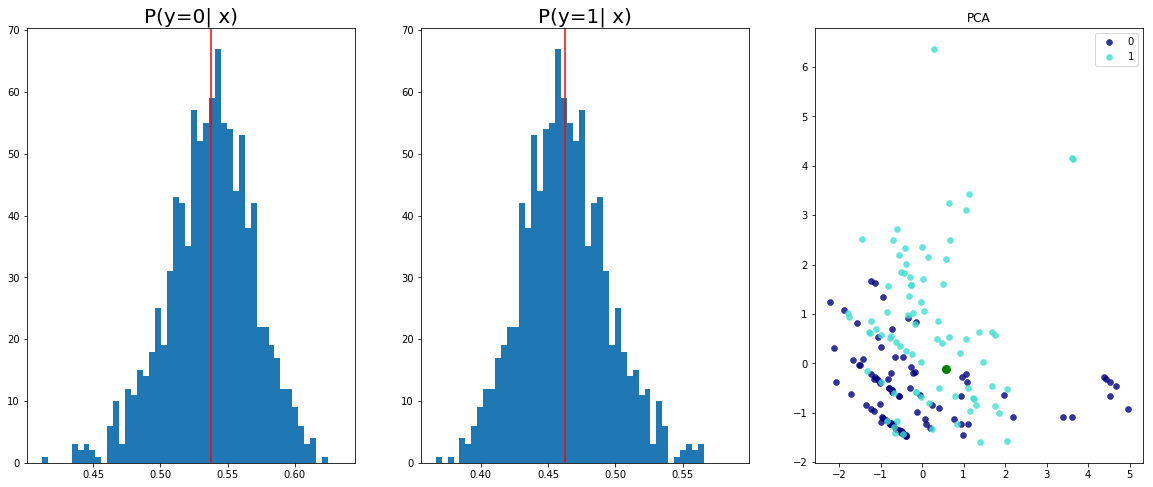

True -> 0
Predicted -> 0
STDS: 0.020949063822627068


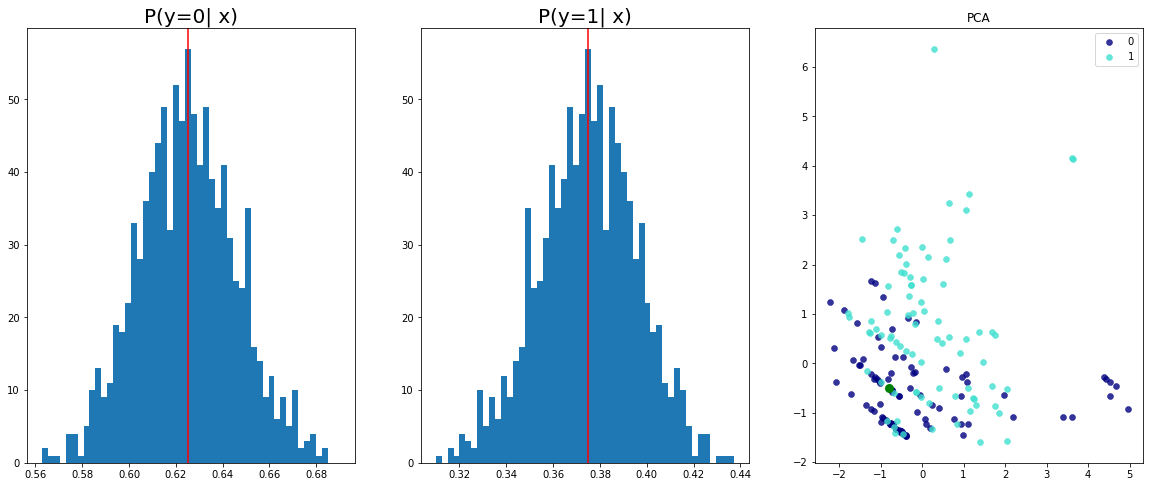

True -> 1
Predicted -> 1
STDS: 0.028915591537952423


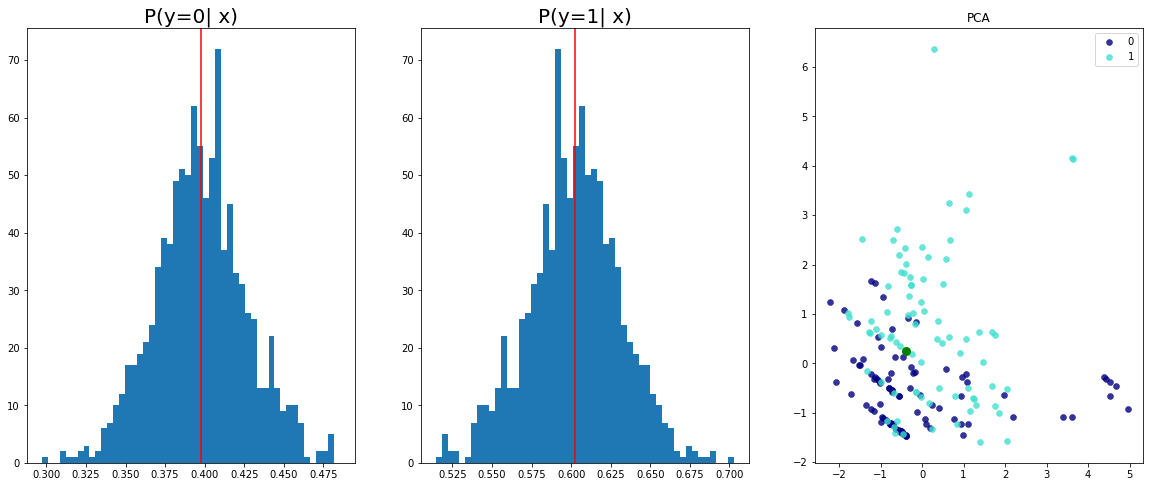

True -> 0
Predicted -> 1
STDS: 0.03190555423498154


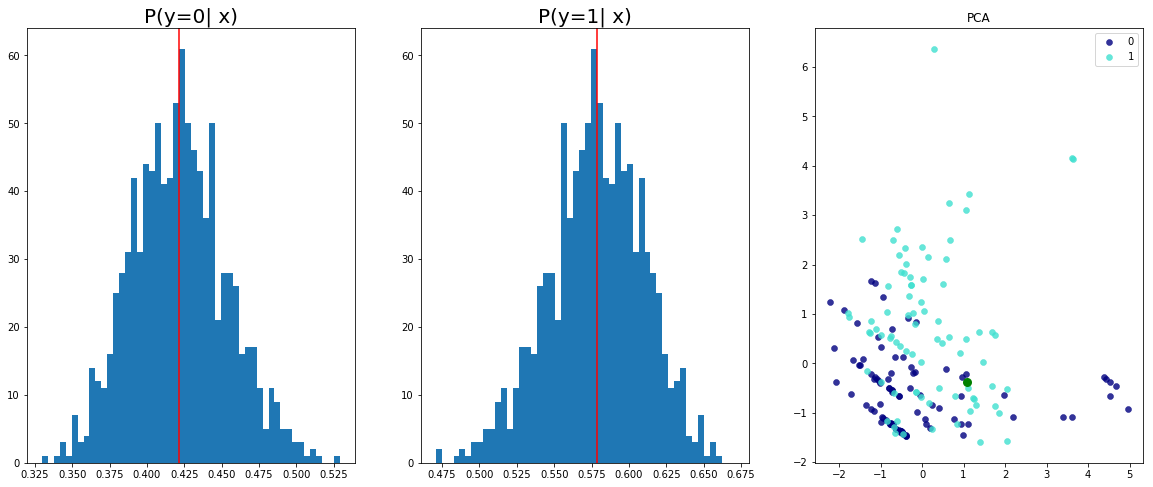

True -> 0
Predicted -> 0
STDS: 0.016345730051398277


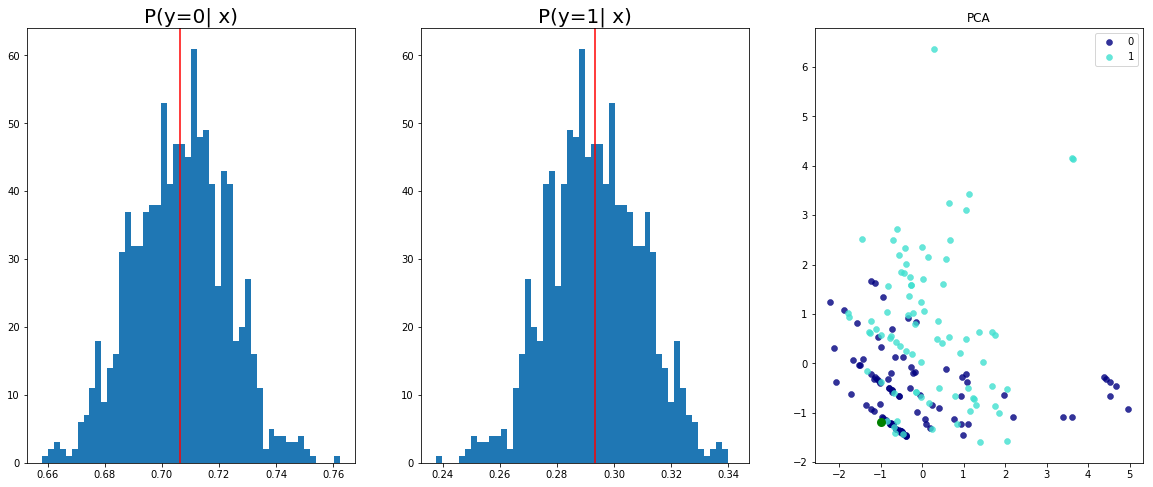

True -> 0
Predicted -> 0
STDS: 0.02790810726583004


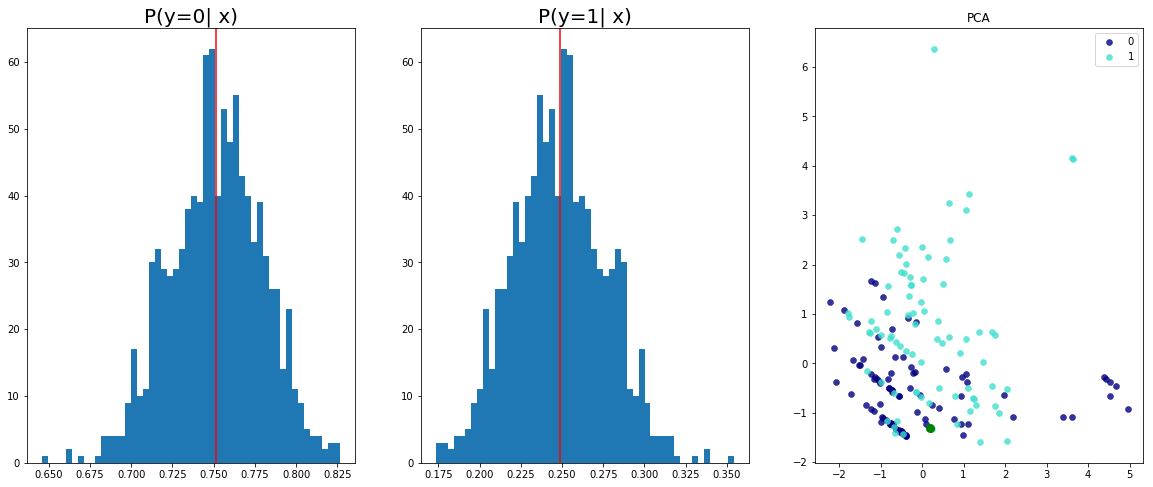

True -> 1
Predicted -> 1
STDS: 0.042063090950250626


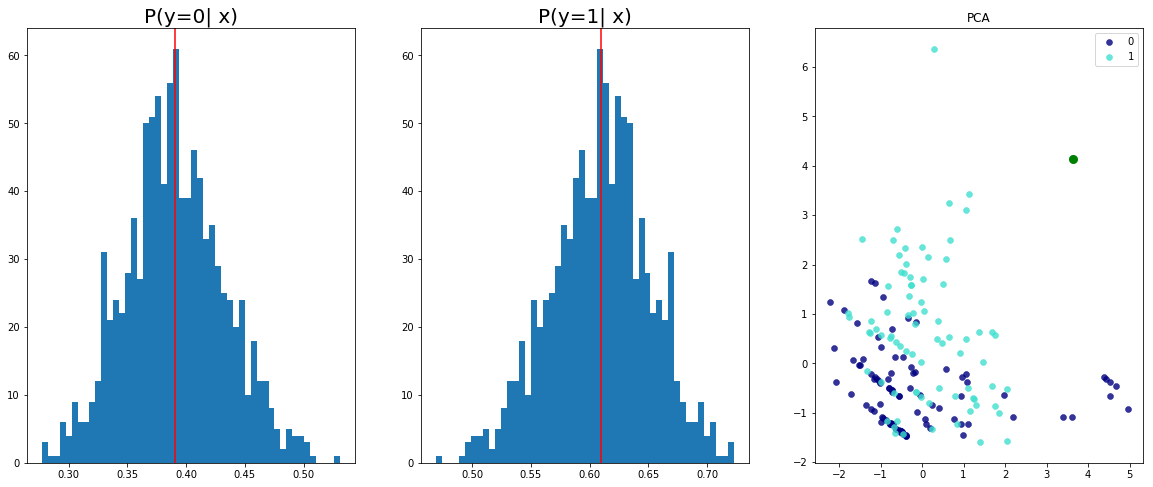

True -> 0
Predicted -> 0
STDS: 0.020515600219368935


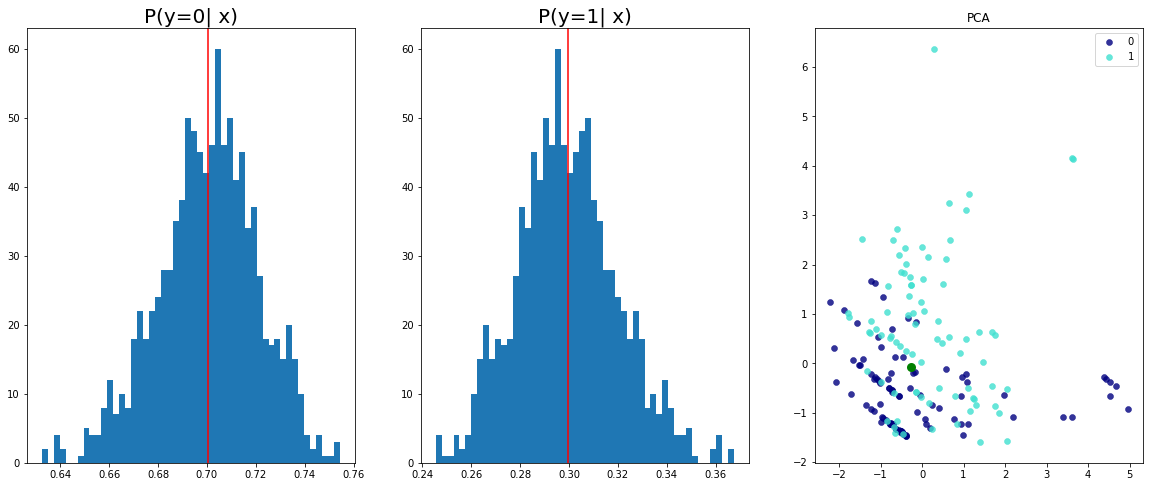

True -> 0
Predicted -> 0
STDS: 0.02175813354551792


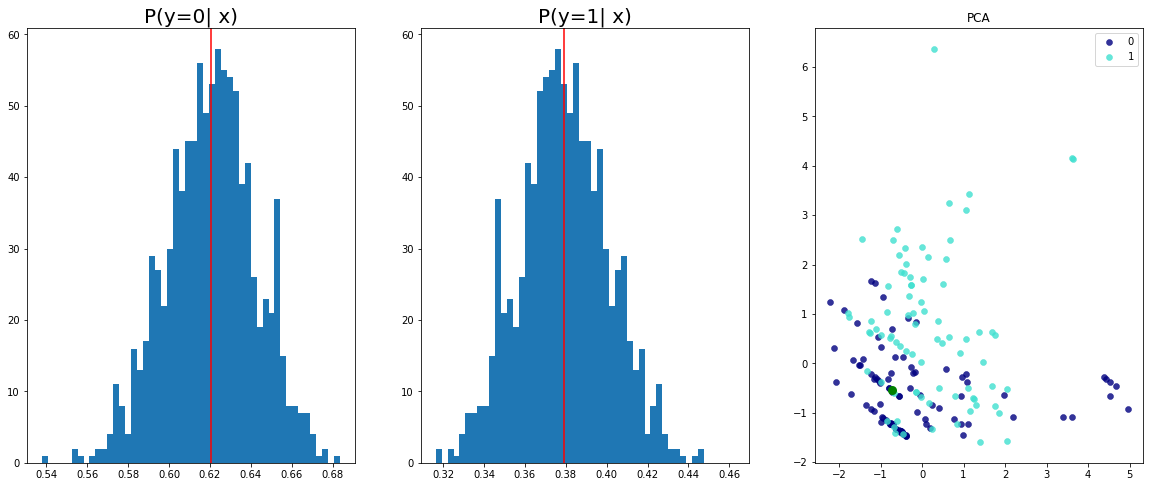

True -> 1
Predicted -> 1
STDS: 0.02952977642416954


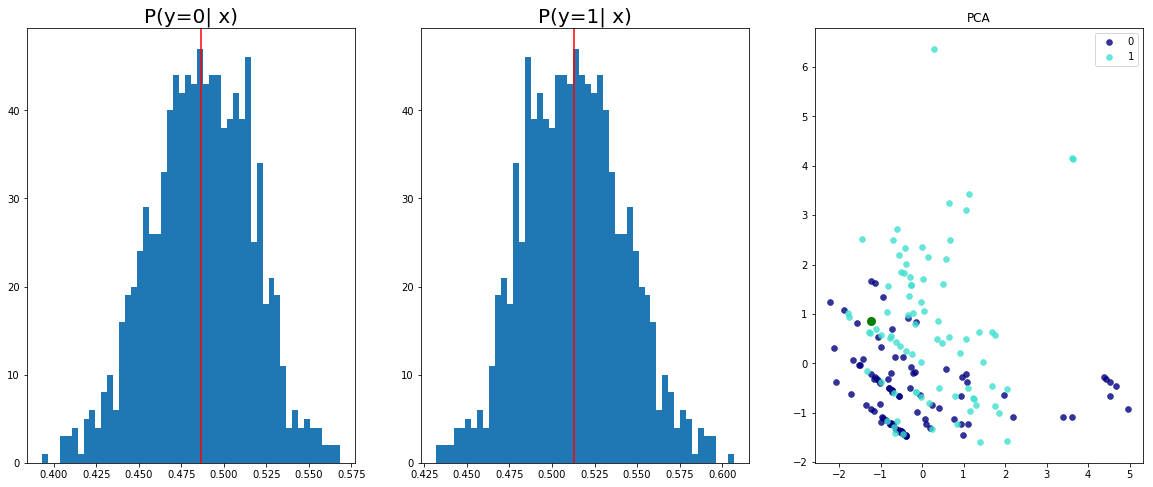

True -> 1
Predicted -> 1
STDS: 0.027110736817121506


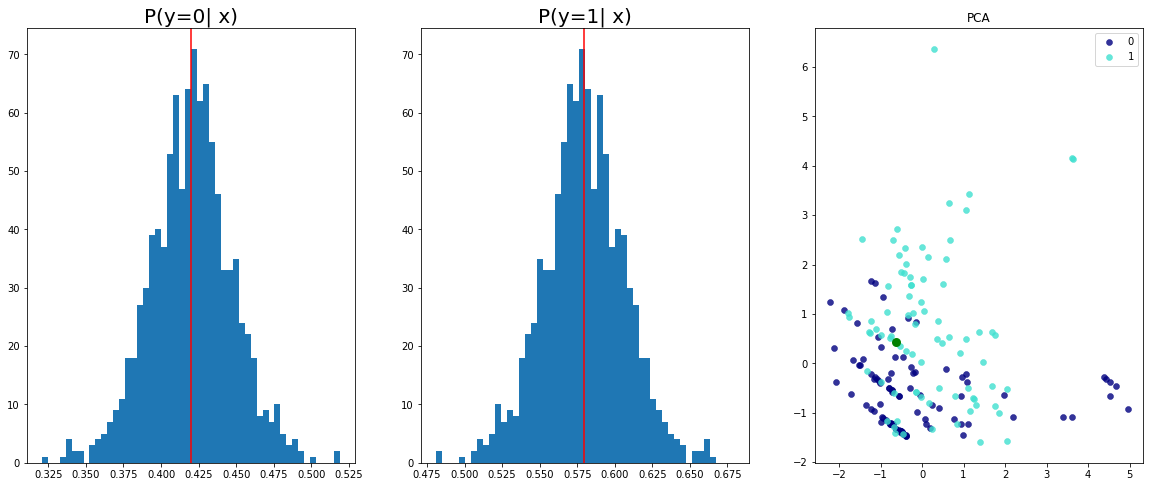

True -> 0
Predicted -> 0
STDS: 0.018970532342791557


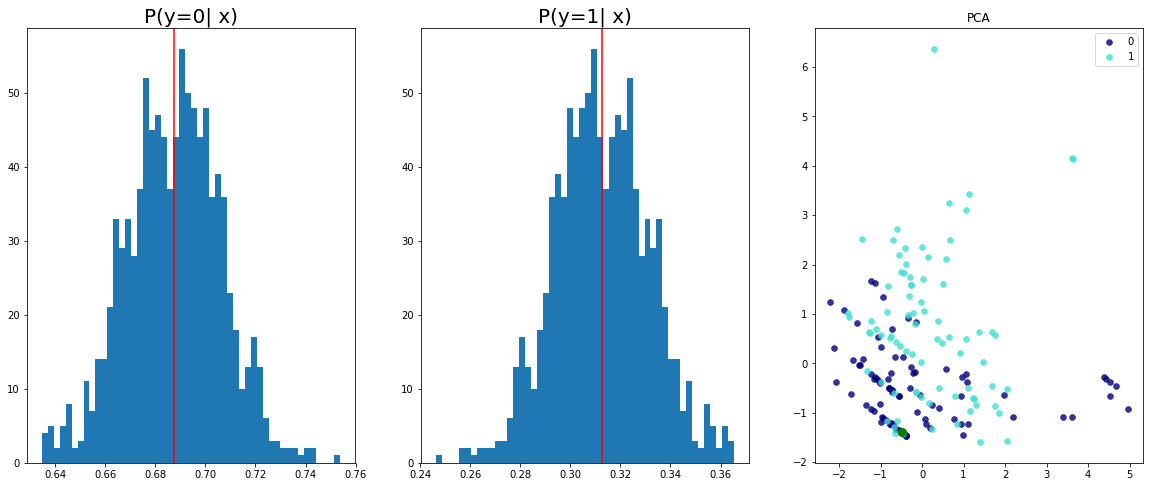

True -> 1
Predicted -> 1
STDS: 0.029005233198404312


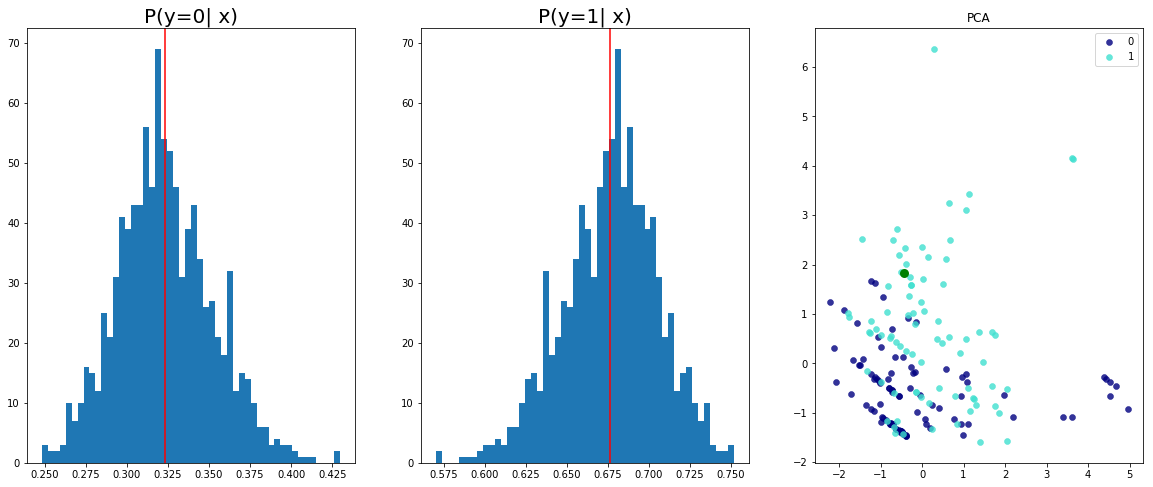

True -> 0
Predicted -> 0
STDS: 0.015047259628772736


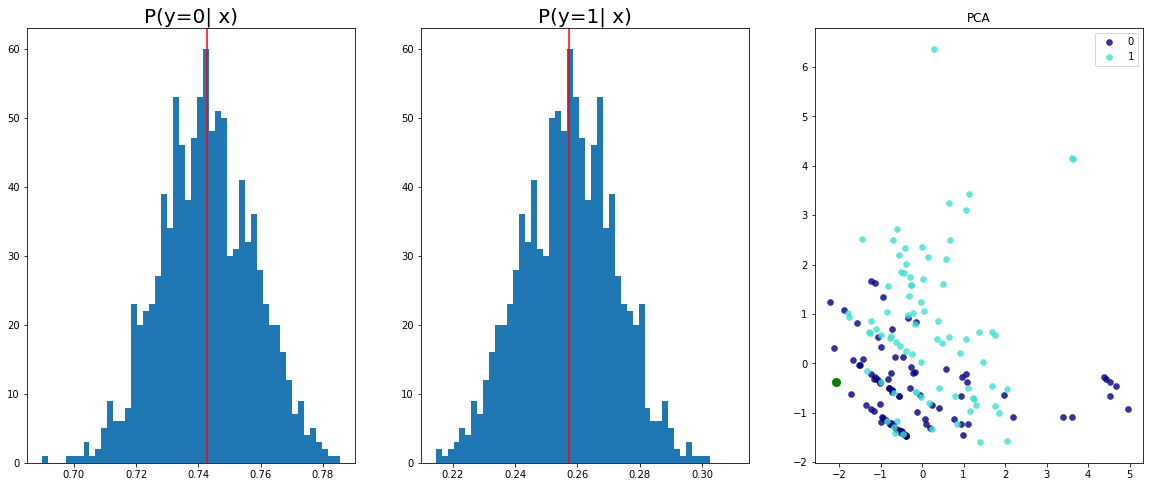

True -> 0
Predicted -> 0
STDS: 0.018897416070103645


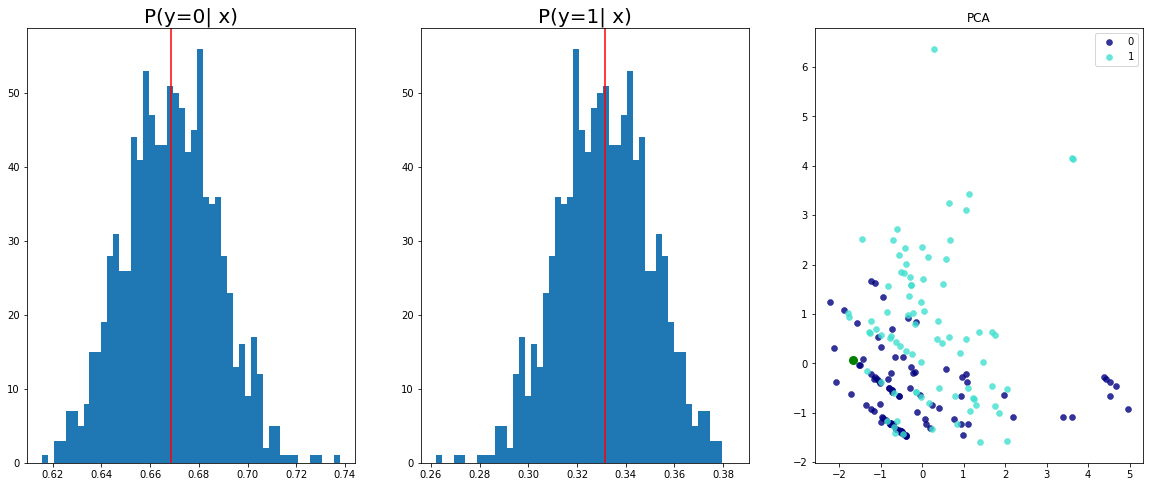

True -> 0
Predicted -> 0
STDS: 0.018806476145982742


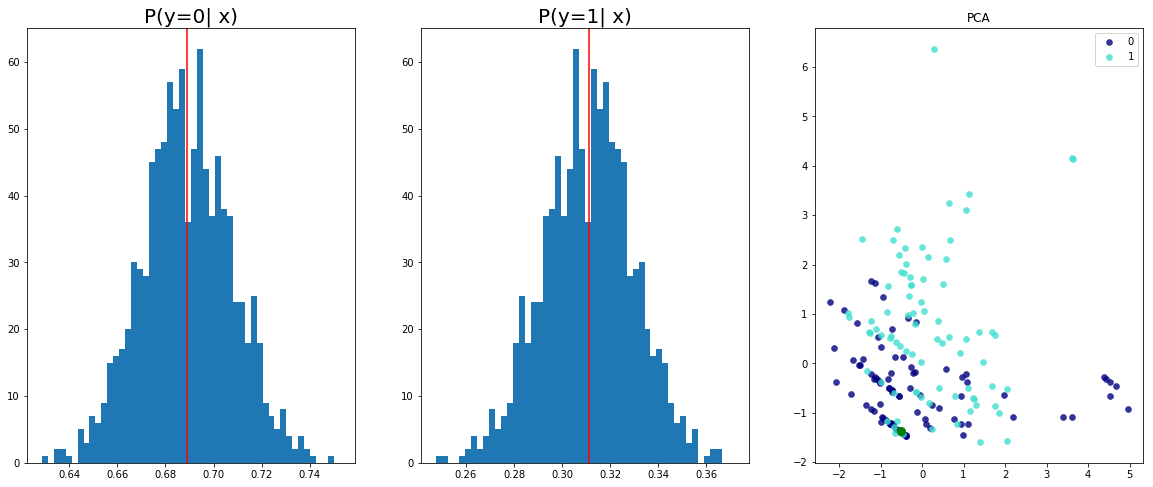

True -> 0
Predicted -> 0
STDS: 0.019153397530317307


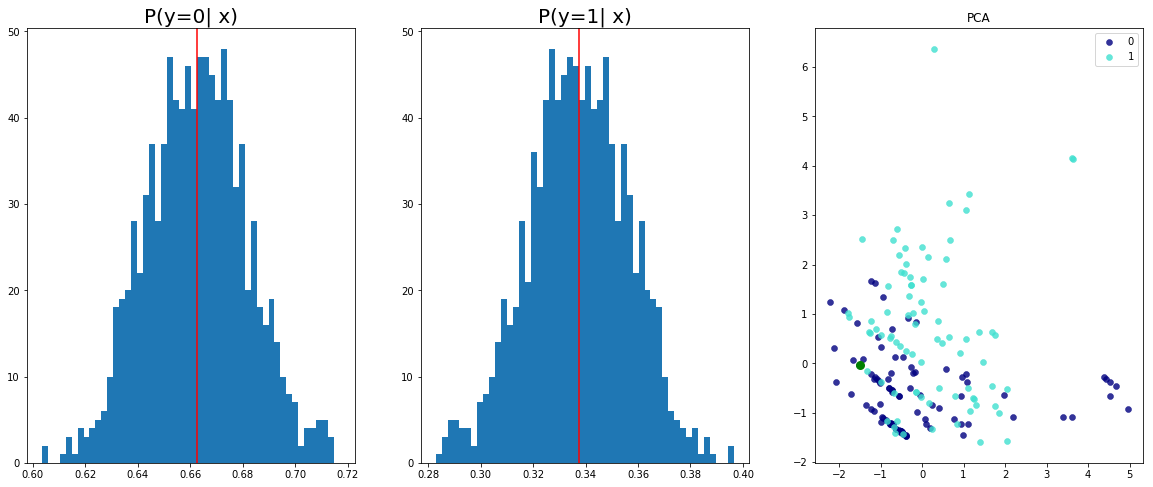

True -> 1
Predicted -> 0
STDS: 0.03447969630360603


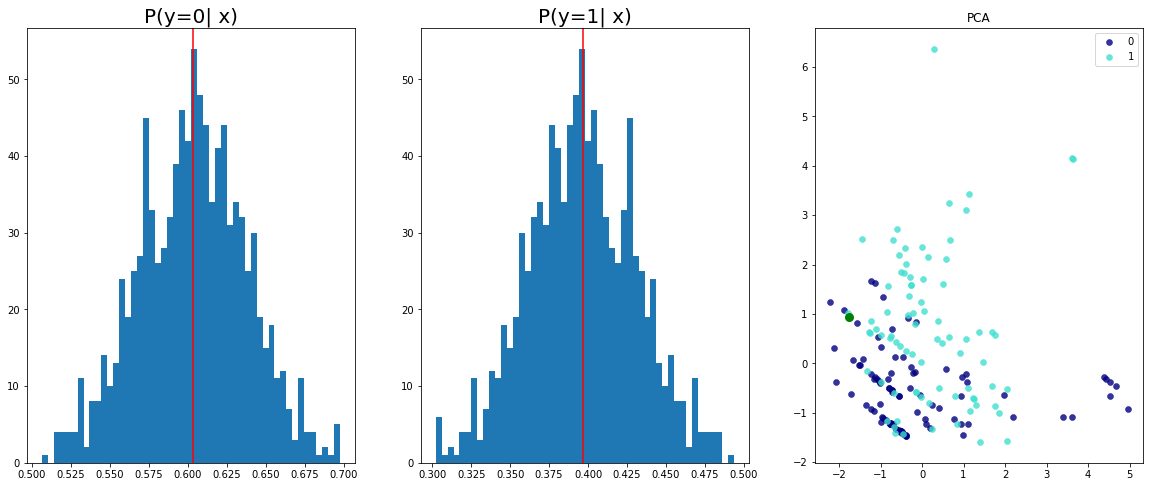

True -> 1
Predicted -> 1
STDS: 0.020462077111005783


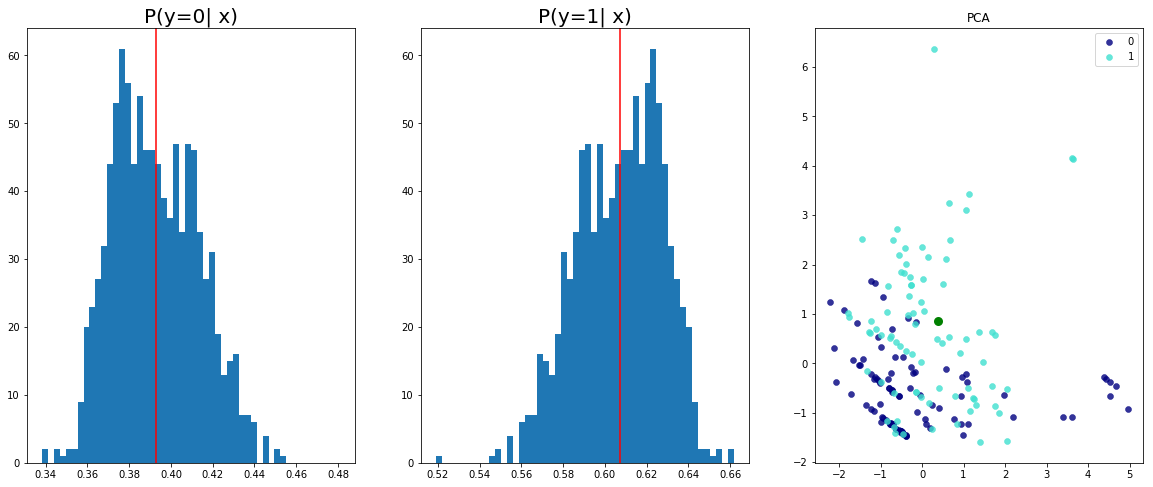

True -> 0
Predicted -> 0
STDS: 0.018470998853445053


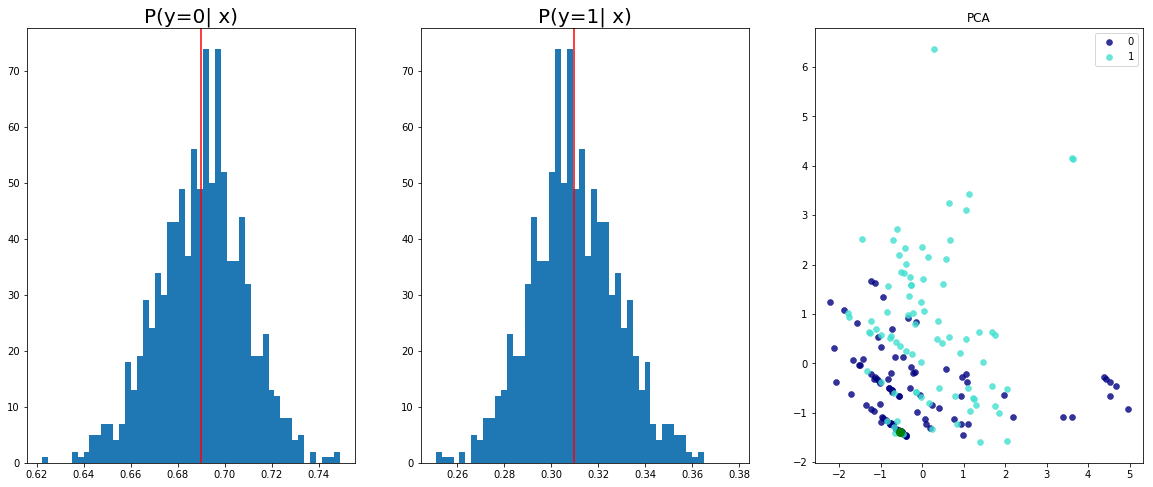

In [17]:
for i in range(len(estimator)):
    plot_prediction_probabilities(estimator=estimator, index_to_plot=i)